# Benchmarking Field Transformations


### DONE - FT-HMC implemented for 8x8 2D QED (using SiLU as activation function).

- [x] Try to minimize size of the force in training. No significant improvements.
- [x]  Some test on ergodicity
- [x] (calculate the probablity of generating the configs obtained via conventional HMC).

### TODO

- [ ] Plot the force size distribution 
- [ ] Is the large force from the original action or Field-Transforma
tion the determinant?
- [ ] If from the determinant, then the fermion force won't cause problem for HMC
- [ ] Use the same Field-Transformation for larger system (say 16x16, 32x32, 64x64, etc)
- [ ] Study how the delta H depends on the system size ( perhaps delta H ~ sqrt(volume) )
- [ ] Study the auto-correlation for observables, topo, plaq, flowed plaq, etc.
- [ ] Improving the Field-Transformation to reduce force.

## Setup, `import`'s, ..., etc

In [2]:
import os
import sys
import torch

from functools import reduce
from IPython.core.interactiveshell import InteractiveShell

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format ='retina'

InteractiveShell.ast_node_interactivity = "all"


project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)

import fthmc.utils.io as io
logger = io.Logger()

torch.manual_seed(9)
# torch.set_default_tensor_type(torch.FloatTensor)

#torch.set_num_threads(param.nth)
#torch.set_num_interop_threads(param.nth_interop)
#os.environ["OMP_NUM_THREADS"] = str(param.nth)
#os.environ["KMP_BLOCKTIME"] = "0"
#os.environ["KMP_SETTINGS"] = "1"
#os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

import matplotlib as mpl
import matplotlib.pyplot as plt

from fthmc.train import train
from fthmc.config import Param, TrainConfig, PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_u1_equiv_layers, set_weights
from fthmc.utils.plot_helpers import save_live_plots

import fthmc.utils.qed_helpers as qed

import datetime

from fthmc.config import LOGS_DIR

mpl.rcParams['text.usetex'] = False
%matplotlib inline
plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')

The autoreload extension is already loaded. To reload it, use:The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TORCH DEVICE: cpu

  %reload_ext autoreload


TORCH DEVICE: cpu


## Setup experiment

- Specify `Param` object for lattice and HMC info

- Specify `TrainConfig` object for training our model

- Note, we train the `pre_flow_model` using the Kullback-Leibler divergence:

$$
D_{\mathrm{KL}} = \left(P\|Q\right) = \sum_{x\in\mathcal{X}} P(x)\log\left(\frac{P(x)}{Q(x)}\right)
$$

[09:00:43]  Param:                                                                           
            ----------------                                                                 
            beta=5.0                                                                         
            L=4                                                                              
            tau=0.5                                                                          
            nstep=5                                                                          
            ntraj=1000                                                                       
            nrun=2                                                                           
            nprint=100                                                                       
            seed=1331                                                                        
            randinit=False                                                                   
            nth_interop=2                                                                    
            nth=2                                                                            
            lat=[4, 4]                                                                       
            nd=2                                                                             
            shape=[2, 4, 4]                                                                  
            volume=16                                                                        
            dt=0.1

            TrainConfig:                                                                     
            ----------------                                                                 
            n_era=10                                                                         
            n_epoch=500                                                                      
            batch_size=64                                                                    
            base_lr=0.001                                                                    
            n_s_nets=2                                                                       
            n_layers=24                                                                      
            kernel_size=3                                                                    
            with_force=False                                                                 
            print_freq=10                                                                    
            plot_freq=10                                                                     
            hidden_sizes=[8, 8]

[09:00:43]  Creating directory: ../../logs/hmc/t4x4_b5.0_n1000_t0.5_s5/2021-06-18-090043

[09:00:43]  Creating directory:                                                              
            ../../logs/hmc/t4x4_b5.0_n1000_t0.5_s5/2021-06-18-090043/plots

[09:00:44]  Param:                                                                           
            ----------------                                                                 
            beta=5.0                                                                         
            L=4                                                                              
            tau=0.5                                                                          
            nstep=5                                                                          
            ntraj=1000                                                                       
            nrun=2                                                                           
            nprint=100                                                                       
            seed=1331                                                                        
            randinit=False                                                                   
            nth_interop=2                                                                    
            nth=2                                                                            
            lat=[4, 4]                                                                       
            nd=2                                                                             
            shape=[2, 4, 4]                                                                  
            volume=16                                                                        
            dt=0.1

──────────────────────────────── RUN: 0, last took: 0 m 0 s ─────────────────────────────────

            plaq=1.000 q=0.000

            traj=2 dt=0.004 acc=1.000 dH=-0.154 q=0 dqsq=0 plaq=0.912

            traj=102 dt=0.003 acc=1.000 dH=-0.190 q=0 dqsq=0 plaq=0.874

            traj=202 dt=0.005 acc=1.000 dH=0.067 q=0 dqsq=0 plaq=0.921

[09:00:45]  traj=302 dt=0.005 acc=1.000 dH=0.148 q=0 dqsq=0 plaq=0.941

            traj=402 dt=0.003 acc=1.000 dH=-0.090 q=0 dqsq=0 plaq=0.911

[09:00:46]  traj=502 dt=0.003 acc=1.000 dH=-0.076 q=0 dqsq=0 plaq=0.871

            traj=602 dt=0.003 acc=1.000 dH=0.031 q=0 dqsq=0 plaq=0.905

[09:00:47]  traj=702 dt=0.003 acc=1.000 dH=-0.047 q=0 dqsq=0 plaq=0.860

            traj=802 dt=0.006 acc=1.000 dH=0.021 q=0 dqsq=0 plaq=0.929

            traj=902 dt=0.006 acc=1.000 dH=0.106 q=0 dqsq=0 plaq=0.927

[09:00:48]  Creating directory:                                                              
            ../../logs/hmc/t4x4_b5.0_n1000_t0.5_s5/2021-06-18-090043/plots/run0

──────────────────────────────── RUN: 1, last took: 0 m 0 s ─────────────────────────────────

[09:00:50]  plaq=1.000 q=0.000

            traj=1002 dt=0.004 acc=1.000 dH=0.037 q=0 dqsq=0 plaq=0.915

            traj=1102 dt=0.003 acc=1.000 dH=0.057 q=0 dqsq=0 plaq=0.885

            traj=1202 dt=0.007 acc=0.000 dH=0.228 q=0 dqsq=0 plaq=0.839

[09:00:51]  traj=1302 dt=0.004 acc=1.000 dH=-0.091 q=0 dqsq=0 plaq=0.917

            traj=1402 dt=0.003 acc=1.000 dH=0.159 q=0 dqsq=0 plaq=0.929

[09:00:52]  traj=1502 dt=0.003 acc=1.000 dH=0.024 q=0 dqsq=0 plaq=0.906

            traj=1602 dt=0.003 acc=1.000 dH=0.091 q=0 dqsq=0 plaq=0.922

            traj=1702 dt=0.004 acc=1.000 dH=-0.081 q=0 dqsq=0 plaq=0.879

[09:00:53]  traj=1802 dt=0.004 acc=1.000 dH=-0.074 q=0 dqsq=0 plaq=0.919

            traj=1902 dt=0.003 acc=1.000 dH=-0.226 q=0 dqsq=0 plaq=0.886

[09:00:53]  Creating directory:                                                              
            ../../logs/hmc/t4x4_b5.0_n1000_t0.5_s5/2021-06-18-090043/plots/run1

[09:00:55]  Run times: ['4.1735', '3.8806']

            Per trajectory: ['0.0042', '0.0039']

[09:00:55]  Saving hmc_histories to                                                          
            ../../logs/hmc/t4x4_b5.0_n1000_t0.5_s5/2021-06-18-090043/hmc_histories.z.

[09:00:56]  Saving hmc_fields_arr to                                                         
            ../../logs/hmc/t4x4_b5.0_n1000_t0.5_s5/2021-06-18-090043/hmc_fields_arr.z.

[09:00:57]  Creating directory:                                                              
            ../../logs/t4x4_b5.0_n1000_t0.5_s5/nb64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500

[09:00:57]  Creating directory: ../../logs/t4x4_b5.0_n1000_t0.5_s5/nb64_nh24_ns2_ks3_hl88_lr0
            .001_era10_epoch500/training

[09:00:57]  Creating directory: ../../logs/t4x4_b5.0_n1000_t0.5_s5/nb64_nh24_ns2_ks3_hl88_lr0
            .001_era10_epoch500/training/plots

[09:00:57]  Creating directory: ../../logs/t4x4_b5.0_n1000_t0.5_s5/nb64_nh24_ns2_ks3_hl88_lr0
            .001_era10_epoch500/training/checkpoints

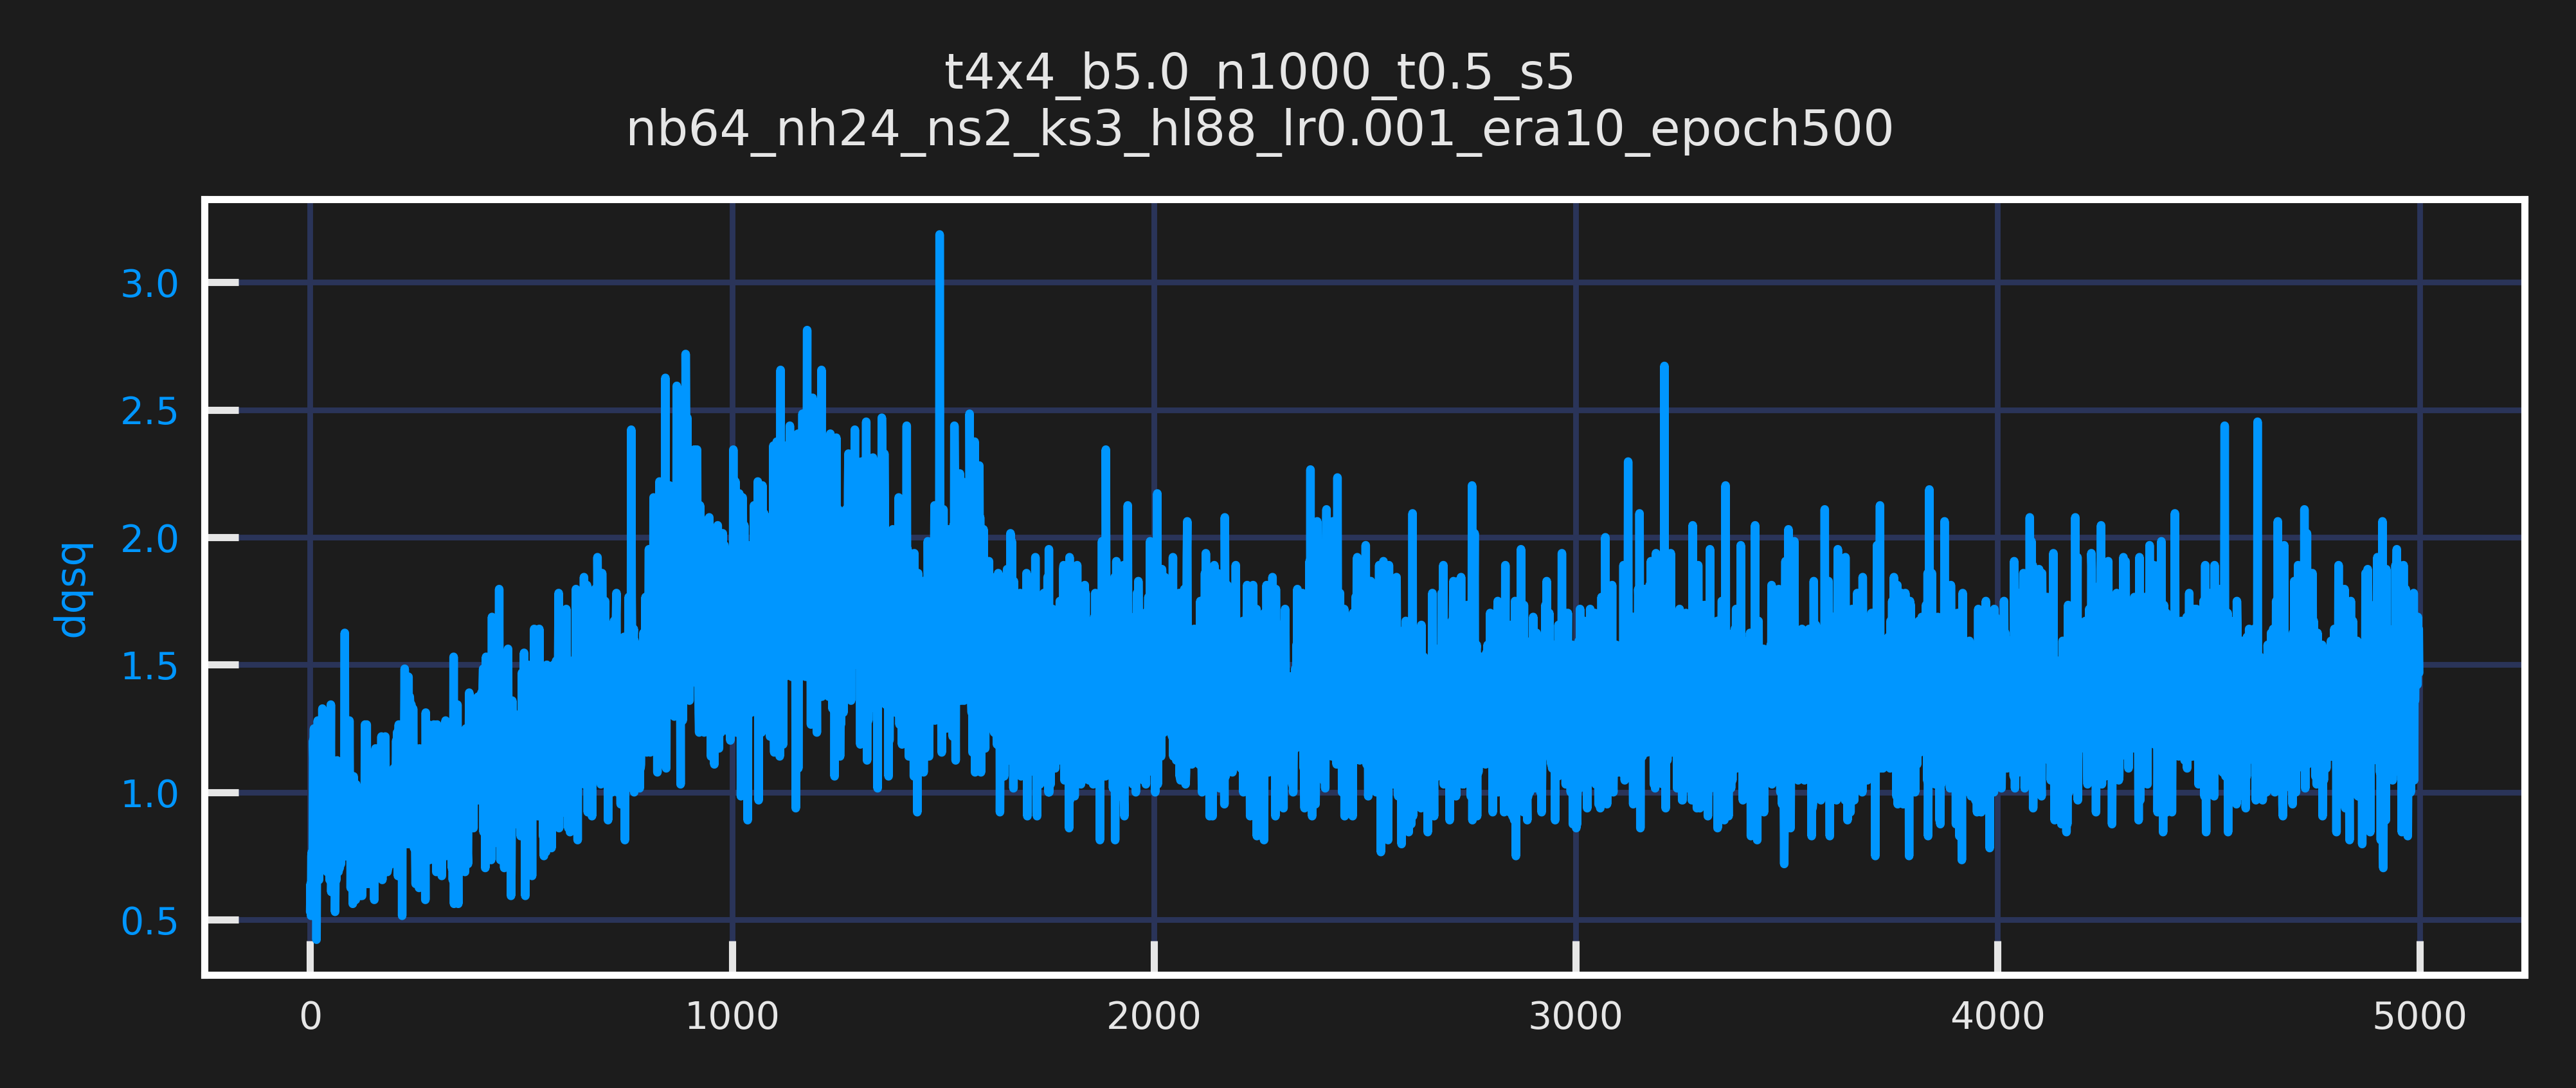

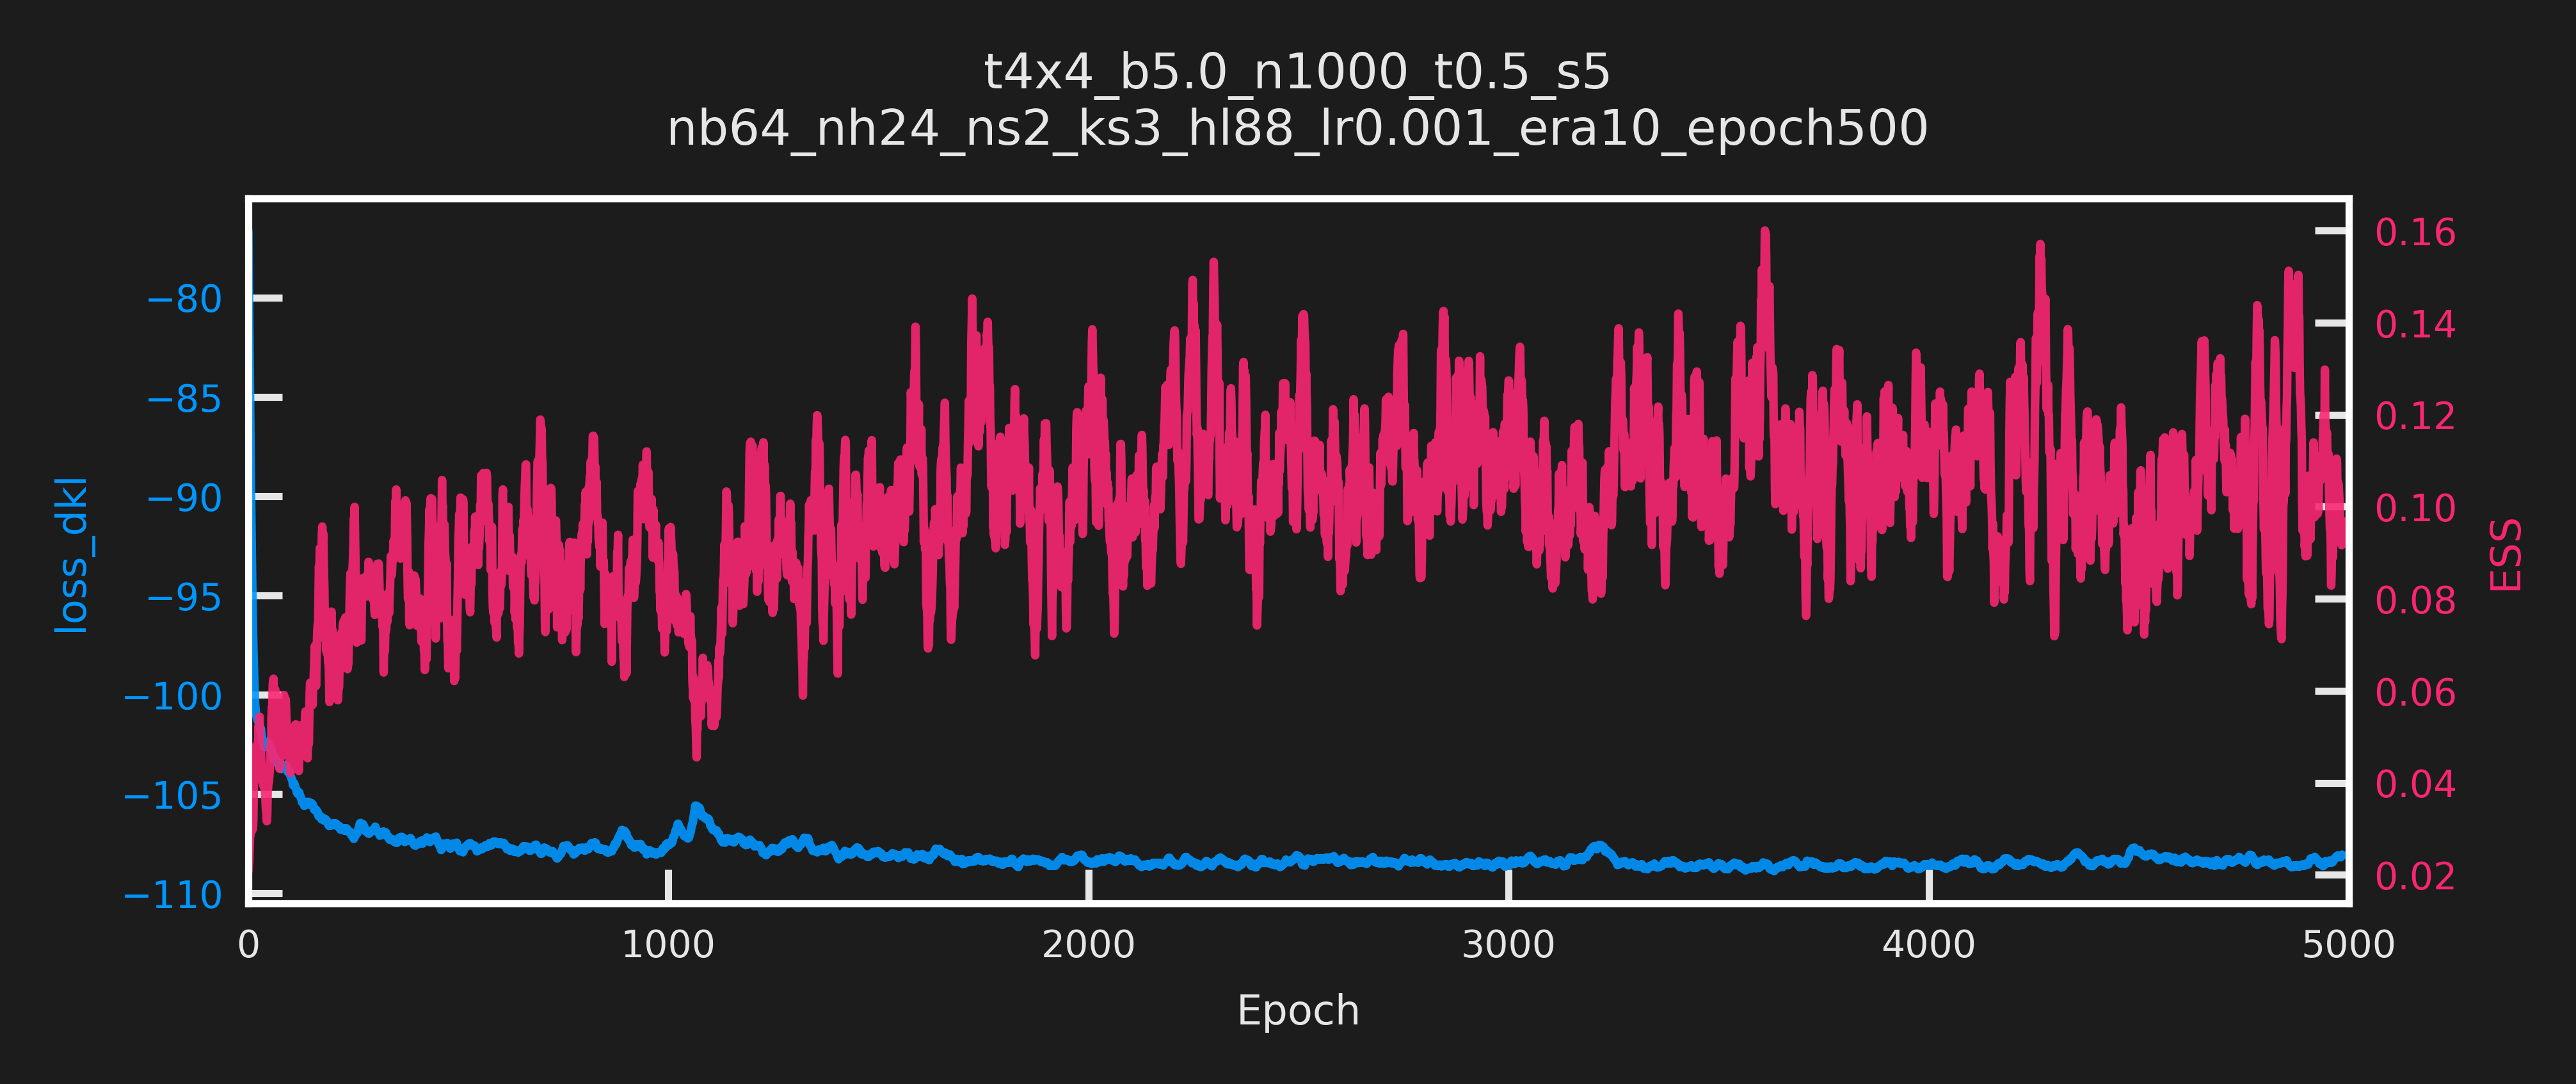

─────────────────────────────── ERA=0, last took: 0 min 0 sec ───────────────────────────────

[09:01:02]  epoch: 9 dt=0.314 ess=0.016 loss_dkl=-81.541 logp=24.407 logq=-57.134 dqsq=1.250 
            plaq=0.305

            (avg) epoch: 9 dt=0.325 ess=0.019 loss_dkl=-71.907 logp=13.894 logq=-58.013      
            dqsq=0.847 plaq=0.174

[09:01:08]  epoch: 19 dt=0.319 ess=0.028 loss_dkl=-100.029 logp=52.046 logq=-47.982          
            dqsq=0.984 plaq=0.651

            (avg) epoch: 19 dt=0.323 ess=0.026 loss_dkl=-82.789 logp=27.309 logq=-55.480     
            dqsq=0.820 plaq=0.341

[09:01:13]  epoch: 29 dt=0.328 ess=0.052 loss_dkl=-102.573 logp=64.977 logq=-37.596          
            dqsq=1.328 plaq=0.812

            (avg) epoch: 29 dt=0.325 ess=0.039 loss_dkl=-96.986 logp=49.460 logq=-47.526     
            dqsq=0.882 plaq=0.618

[09:01:19]  epoch: 39 dt=0.330 ess=0.026 loss_dkl=-102.639 logp=62.746 logq=-39.893          
            dqsq=0.812 plaq=0.784

            (avg) epoch: 39 dt=0.335 ess=0.046 loss_dkl=-101.356 logp=61.559 logq=-39.797    
            dqsq=0.919 plaq=0.769

[09:01:25]  epoch: 49 dt=0.347 ess=0.024 loss_dkl=-101.789 logp=55.814 logq=-45.975          
            dqsq=1.344 plaq=0.698

            (avg) epoch: 49 dt=0.342 ess=0.043 loss_dkl=-101.954 logp=61.526 logq=-40.429    
            dqsq=0.889 plaq=0.769

[09:01:31]  epoch: 59 dt=0.429 ess=0.049 loss_dkl=-102.465 logp=58.777 logq=-43.687          
            dqsq=0.531 plaq=0.735

            (avg) epoch: 59 dt=0.354 ess=0.036 loss_dkl=-102.439 logp=58.445 logq=-43.994    
            dqsq=0.848 plaq=0.731

[09:01:37]  epoch: 69 dt=0.356 ess=0.147 loss_dkl=-101.653 logp=58.778 logq=-42.875          
            dqsq=0.812 plaq=0.735

            (avg) epoch: 69 dt=0.369 ess=0.049 loss_dkl=-102.706 logp=58.738 logq=-43.968    
            dqsq=0.825 plaq=0.734

[09:01:44]  epoch: 79 dt=0.431 ess=0.030 loss_dkl=-103.675 logp=61.223 logq=-42.453          
            dqsq=1.062 plaq=0.765

            (avg) epoch: 79 dt=0.377 ess=0.060 loss_dkl=-103.266 logp=60.929 logq=-42.337    
            dqsq=0.891 plaq=0.762

[09:01:50]  epoch: 89 dt=0.378 ess=0.102 loss_dkl=-104.398 logp=62.278 logq=-42.120          
            dqsq=1.016 plaq=0.778

[09:01:51]  (avg) epoch: 89 dt=0.386 ess=0.048 loss_dkl=-103.571 logp=61.390 logq=-42.181    
            dqsq=0.945 plaq=0.767

[09:01:58]  epoch: 99 dt=0.442 ess=0.109 loss_dkl=-103.075 logp=59.773 logq=-43.302          
            dqsq=0.859 plaq=0.747

            (avg) epoch: 99 dt=0.437 ess=0.055 loss_dkl=-103.580 logp=60.717 logq=-42.863    
            dqsq=0.947 plaq=0.759

[09:02:04]  epoch: 109 dt=0.410 ess=0.026 loss_dkl=-103.646 logp=60.858 logq=-42.787         
            dqsq=1.031 plaq=0.761

            (avg) epoch: 109 dt=0.447 ess=0.051 loss_dkl=-103.814 logp=61.156 logq=-42.658   
            dqsq=0.877 plaq=0.764

[09:02:12]  epoch: 119 dt=0.442 ess=0.083 loss_dkl=-105.187 logp=61.580 logq=-43.607         
            dqsq=0.859 plaq=0.770

            (avg) epoch: 119 dt=0.443 ess=0.045 loss_dkl=-104.284 logp=61.771 logq=-42.513   
            dqsq=0.792 plaq=0.772

[09:02:20]  epoch: 129 dt=0.746 ess=0.045 loss_dkl=-105.369 logp=61.754 logq=-43.615         
            dqsq=0.828 plaq=0.772

            (avg) epoch: 129 dt=0.537 ess=0.050 loss_dkl=-104.612 logp=61.970 logq=-42.642   
            dqsq=0.788 plaq=0.775

[09:02:30]  epoch: 139 dt=0.757 ess=0.068 loss_dkl=-105.406 logp=61.950 logq=-43.455         
            dqsq=0.703 plaq=0.774

            (avg) epoch: 139 dt=0.603 ess=0.049 loss_dkl=-105.079 logp=62.458 logq=-42.622   
            dqsq=0.892 plaq=0.781

[09:02:40]  epoch: 149 dt=0.681 ess=0.074 loss_dkl=-105.042 logp=62.663 logq=-42.379         
            dqsq=1.094 plaq=0.783

            (avg) epoch: 149 dt=0.630 ess=0.049 loss_dkl=-105.401 logp=62.883 logq=-42.518   
            dqsq=0.916 plaq=0.786

[09:02:52]  epoch: 159 dt=0.790 ess=0.102 loss_dkl=-105.421 logp=62.575 logq=-42.846         
            dqsq=1.062 plaq=0.782

            (avg) epoch: 159 dt=0.696 ess=0.050 loss_dkl=-105.448 logp=62.965 logq=-42.483   
            dqsq=0.891 plaq=0.787

[09:03:04]  epoch: 169 dt=1.175 ess=0.034 loss_dkl=-106.418 logp=64.723 logq=-41.695         
            dqsq=1.219 plaq=0.809

            (avg) epoch: 169 dt=0.775 ess=0.057 loss_dkl=-105.590 logp=63.373 logq=-42.217   
            dqsq=0.933 plaq=0.792

[09:03:17]  epoch: 179 dt=0.828 ess=0.079 loss_dkl=-105.556 logp=62.902 logq=-42.654         
            dqsq=0.953 plaq=0.786

            (avg) epoch: 179 dt=0.804 ess=0.072 loss_dkl=-105.886 logp=63.957 logq=-41.929   
            dqsq=0.945 plaq=0.799

[09:03:30]  epoch: 189 dt=0.887 ess=0.117 loss_dkl=-105.492 logp=63.415 logq=-42.077         
            dqsq=0.766 plaq=0.793

            (avg) epoch: 189 dt=0.779 ess=0.089 loss_dkl=-106.137 logp=64.247 logq=-41.890   
            dqsq=0.874 plaq=0.803

[09:03:41]  epoch: 199 dt=0.838 ess=0.024 loss_dkl=-107.025 logp=65.191 logq=-41.834         
            dqsq=0.953 plaq=0.815

            (avg) epoch: 199 dt=0.750 ess=0.078 loss_dkl=-106.352 logp=64.691 logq=-41.661   
            dqsq=0.873 plaq=0.809

[09:03:55]  epoch: 209 dt=0.899 ess=0.069 loss_dkl=-105.773 logp=64.020 logq=-41.753         
            dqsq=1.188 plaq=0.800

            (avg) epoch: 209 dt=0.819 ess=0.066 loss_dkl=-106.501 logp=65.059 logq=-41.442   
            dqsq=0.980 plaq=0.813

[09:04:07]  epoch: 219 dt=0.757 ess=0.041 loss_dkl=-106.737 logp=65.914 logq=-40.823         
            dqsq=1.109 plaq=0.824

            (avg) epoch: 219 dt=0.797 ess=0.068 loss_dkl=-106.540 logp=64.860 logq=-41.680   
            dqsq=0.988 plaq=0.811

[09:04:19]  epoch: 229 dt=0.556 ess=0.053 loss_dkl=-106.996 logp=65.925 logq=-41.072         
            dqsq=1.125 plaq=0.824

            (avg) epoch: 229 dt=0.703 ess=0.065 loss_dkl=-106.611 logp=65.002 logq=-41.610   
            dqsq=1.055 plaq=0.813

[09:04:28]  epoch: 239 dt=0.488 ess=0.098 loss_dkl=-107.126 logp=64.219 logq=-42.907         
            dqsq=1.328 plaq=0.803

            (avg) epoch: 239 dt=0.625 ess=0.072 loss_dkl=-106.762 logp=65.131 logq=-41.631   
            dqsq=1.176 plaq=0.814

[09:04:37]  epoch: 249 dt=0.669 ess=0.019 loss_dkl=-107.217 logp=65.624 logq=-41.593         
            dqsq=0.781 plaq=0.820

            (avg) epoch: 249 dt=0.564 ess=0.069 loss_dkl=-106.798 logp=64.949 logq=-41.849   
            dqsq=1.131 plaq=0.812

[09:04:46]  epoch: 259 dt=0.587 ess=0.087 loss_dkl=-106.728 logp=64.216 logq=-42.512         
            dqsq=1.172 plaq=0.803

            (avg) epoch: 259 dt=0.568 ess=0.080 loss_dkl=-106.946 logp=65.197 logq=-41.749   
            dqsq=0.959 plaq=0.815

[09:04:54]  epoch: 269 dt=0.497 ess=0.022 loss_dkl=-107.186 logp=64.825 logq=-42.361         
            dqsq=0.859 plaq=0.810

            (avg) epoch: 269 dt=0.529 ess=0.089 loss_dkl=-107.073 logp=65.041 logq=-42.032   
            dqsq=0.852 plaq=0.813

[09:05:02]  epoch: 279 dt=0.539 ess=0.072 loss_dkl=-105.981 logp=63.984 logq=-41.997         
            dqsq=0.734 plaq=0.800

            (avg) epoch: 279 dt=0.512 ess=0.076 loss_dkl=-106.724 logp=64.641 logq=-42.083   
            dqsq=0.892 plaq=0.808

[09:05:10]  epoch: 289 dt=0.475 ess=0.131 loss_dkl=-106.937 logp=65.715 logq=-41.222         
            dqsq=0.969 plaq=0.821

            (avg) epoch: 289 dt=0.488 ess=0.080 loss_dkl=-106.637 logp=64.937 logq=-41.699   
            dqsq=0.966 plaq=0.812

[09:05:18]  epoch: 299 dt=0.479 ess=0.102 loss_dkl=-107.626 logp=65.957 logq=-41.669         
            dqsq=0.688 plaq=0.824

            (avg) epoch: 299 dt=0.467 ess=0.085 loss_dkl=-106.908 logp=65.248 logq=-41.660   
            dqsq=0.984 plaq=0.816

[09:05:28]  epoch: 309 dt=0.907 ess=0.109 loss_dkl=-106.516 logp=64.627 logq=-41.888         
            dqsq=0.906 plaq=0.808

            (avg) epoch: 309 dt=0.593 ess=0.081 loss_dkl=-106.852 logp=65.301 logq=-41.552   
            dqsq=0.980 plaq=0.816

[09:05:36]  epoch: 319 dt=0.420 ess=0.108 loss_dkl=-106.967 logp=64.744 logq=-42.223         
            dqsq=1.125 plaq=0.809

            (avg) epoch: 319 dt=0.569 ess=0.083 loss_dkl=-106.834 logp=65.380 logq=-41.454   
            dqsq=1.007 plaq=0.817

[09:05:43]  epoch: 329 dt=0.451 ess=0.060 loss_dkl=-106.281 logp=63.689 logq=-42.592         
            dqsq=0.859 plaq=0.796

            (avg) epoch: 329 dt=0.465 ess=0.079 loss_dkl=-106.933 logp=64.842 logq=-42.091   
            dqsq=1.005 plaq=0.811

[09:05:51]  epoch: 339 dt=0.591 ess=0.110 loss_dkl=-107.707 logp=66.224 logq=-41.483         
            dqsq=0.797 plaq=0.828

            (avg) epoch: 339 dt=0.501 ess=0.074 loss_dkl=-106.984 logp=64.957 logq=-42.026   
            dqsq=0.952 plaq=0.812

[09:06:00]  epoch: 349 dt=0.456 ess=0.053 loss_dkl=-107.359 logp=64.841 logq=-42.518         
            dqsq=1.344 plaq=0.811

            (avg) epoch: 349 dt=0.506 ess=0.078 loss_dkl=-107.132 logp=65.513 logq=-41.619   
            dqsq=0.965 plaq=0.819

[09:06:07]  epoch: 359 dt=0.677 ess=0.124 loss_dkl=-107.858 logp=66.656 logq=-41.201         
            dqsq=1.203 plaq=0.833

            (avg) epoch: 359 dt=0.477 ess=0.087 loss_dkl=-107.336 logp=65.741 logq=-41.595   
            dqsq=0.973 plaq=0.822

[09:06:14]  epoch: 369 dt=0.378 ess=0.080 loss_dkl=-107.368 logp=65.003 logq=-42.365         
            dqsq=1.250 plaq=0.813

            (avg) epoch: 369 dt=0.423 ess=0.096 loss_dkl=-107.391 logp=65.806 logq=-41.585   
            dqsq=0.952 plaq=0.823

[09:06:20]  epoch: 379 dt=0.398 ess=0.139 loss_dkl=-107.311 logp=66.225 logq=-41.086         
            dqsq=0.875 plaq=0.828

            (avg) epoch: 379 dt=0.388 ess=0.099 loss_dkl=-107.238 logp=65.697 logq=-41.540   
            dqsq=1.006 plaq=0.821

[09:06:26]  epoch: 389 dt=0.330 ess=0.036 loss_dkl=-107.386 logp=66.502 logq=-40.884         
            dqsq=1.266 plaq=0.831

            (avg) epoch: 389 dt=0.358 ess=0.094 loss_dkl=-107.236 logp=66.170 logq=-41.066   
            dqsq=1.080 plaq=0.827

[09:06:31]  epoch: 399 dt=0.315 ess=0.136 loss_dkl=-107.261 logp=64.989 logq=-42.272         
            dqsq=1.016 plaq=0.812

            (avg) epoch: 399 dt=0.337 ess=0.082 loss_dkl=-107.325 logp=66.310 logq=-41.016   
            dqsq=1.127 plaq=0.829

[09:06:37]  epoch: 409 dt=0.325 ess=0.085 loss_dkl=-107.226 logp=66.263 logq=-40.963         
            dqsq=1.422 plaq=0.828

            (avg) epoch: 409 dt=0.325 ess=0.081 loss_dkl=-107.460 logp=66.358 logq=-41.102   
            dqsq=1.164 plaq=0.829

[09:06:42]  epoch: 419 dt=0.295 ess=0.146 loss_dkl=-107.177 logp=65.588 logq=-41.588         
            dqsq=0.984 plaq=0.820

            (avg) epoch: 419 dt=0.315 ess=0.080 loss_dkl=-107.508 logp=66.395 logq=-41.113   
            dqsq=1.197 plaq=0.830

[09:06:47]  epoch: 429 dt=0.293 ess=0.047 loss_dkl=-107.916 logp=66.148 logq=-41.768         
            dqsq=0.734 plaq=0.827

            (avg) epoch: 429 dt=0.307 ess=0.072 loss_dkl=-107.436 logp=66.021 logq=-41.415   
            dqsq=1.069 plaq=0.825

[09:06:52]  epoch: 439 dt=0.287 ess=0.135 loss_dkl=-108.351 logp=67.178 logq=-41.173         
            dqsq=1.250 plaq=0.840

            (avg) epoch: 439 dt=0.305 ess=0.073 loss_dkl=-107.321 logp=65.857 logq=-41.464   
            dqsq=1.060 plaq=0.823

[09:06:57]  epoch: 449 dt=0.312 ess=0.040 loss_dkl=-106.830 logp=65.940 logq=-40.890         
            dqsq=1.125 plaq=0.824

            (avg) epoch: 449 dt=0.305 ess=0.090 loss_dkl=-107.295 logp=65.977 logq=-41.318   
            dqsq=1.206 plaq=0.825

[09:07:02]  epoch: 459 dt=0.316 ess=0.036 loss_dkl=-108.715 logp=67.078 logq=-41.638         
            dqsq=1.063 plaq=0.838

            (avg) epoch: 459 dt=0.302 ess=0.090 loss_dkl=-107.307 logp=66.005 logq=-41.302   
            dqsq=1.162 plaq=0.825

[09:07:06]  epoch: 469 dt=0.288 ess=0.069 loss_dkl=-107.633 logp=66.356 logq=-41.277         
            dqsq=1.562 plaq=0.829

            (avg) epoch: 469 dt=0.292 ess=0.081 loss_dkl=-107.418 logp=66.160 logq=-41.259   
            dqsq=1.151 plaq=0.827

[09:07:11]  epoch: 479 dt=0.286 ess=0.099 loss_dkl=-107.007 logp=64.917 logq=-42.090         
            dqsq=1.359 plaq=0.811

            (avg) epoch: 479 dt=0.291 ess=0.093 loss_dkl=-107.569 logp=66.341 logq=-41.228   
            dqsq=1.136 plaq=0.829

[09:07:16]  epoch: 489 dt=0.282 ess=0.114 loss_dkl=-108.031 logp=67.734 logq=-40.296         
            dqsq=1.109 plaq=0.847

            (avg) epoch: 489 dt=0.300 ess=0.085 loss_dkl=-107.602 logp=66.567 logq=-41.035   
            dqsq=1.055 plaq=0.832

[09:07:21]  epoch: 499 dt=0.316 ess=0.021 loss_dkl=-107.991 logp=66.647 logq=-41.344         
            dqsq=0.828 plaq=0.833

            (avg) epoch: 499 dt=0.312 ess=0.068 loss_dkl=-107.649 logp=66.732 logq=-40.917   
            dqsq=1.071 plaq=0.834

[09:07:23]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era0-epoch
            499.tar

───────────────────────────── ERA=1, last took: 6 min 24.35 sec ─────────────────────────────

[09:07:26]  epoch: 9 dt=0.278 ess=0.079 loss_dkl=-107.652 logp=67.083 logq=-40.569 dqsq=1.234
            plaq=0.839

            (avg) epoch: 9 dt=0.281 ess=0.081 loss_dkl=-107.604 logp=66.023 logq=-41.581     
            dqsq=1.276 plaq=0.825

[09:07:31]  epoch: 19 dt=0.271 ess=0.089 loss_dkl=-107.770 logp=66.648 logq=-41.122          
            dqsq=1.016 plaq=0.833

            (avg) epoch: 19 dt=0.295 ess=0.090 loss_dkl=-107.758 logp=66.422 logq=-41.336    
            dqsq=1.182 plaq=0.830

[09:07:36]  epoch: 29 dt=0.267 ess=0.040 loss_dkl=-107.093 logp=65.150 logq=-41.943          
            dqsq=1.000 plaq=0.814

            (avg) epoch: 29 dt=0.290 ess=0.091 loss_dkl=-107.750 logp=66.577 logq=-41.173    
            dqsq=1.066 plaq=0.832

[09:07:40]  epoch: 39 dt=0.273 ess=0.082 loss_dkl=-107.372 logp=66.429 logq=-40.944          
            dqsq=1.062 plaq=0.830

            (avg) epoch: 39 dt=0.277 ess=0.082 loss_dkl=-107.613 logp=66.451 logq=-41.162    
            dqsq=1.143 plaq=0.831

[09:07:45]  epoch: 49 dt=0.270 ess=0.081 loss_dkl=-107.294 logp=65.694 logq=-41.600          
            dqsq=1.172 plaq=0.821

            (avg) epoch: 49 dt=0.276 ess=0.088 loss_dkl=-107.598 logp=66.505 logq=-41.093    
            dqsq=1.218 plaq=0.831

[09:07:49]  epoch: 59 dt=0.255 ess=0.124 loss_dkl=-107.607 logp=65.777 logq=-41.830          
            dqsq=0.766 plaq=0.822

            (avg) epoch: 59 dt=0.264 ess=0.095 loss_dkl=-107.741 logp=66.563 logq=-41.178    
            dqsq=1.083 plaq=0.832

[09:07:53]  epoch: 69 dt=0.255 ess=0.130 loss_dkl=-106.982 logp=64.955 logq=-42.028          
            dqsq=1.062 plaq=0.812

            (avg) epoch: 69 dt=0.259 ess=0.103 loss_dkl=-107.731 logp=66.260 logq=-41.471    
            dqsq=1.107 plaq=0.828

[09:07:58]  epoch: 79 dt=0.258 ess=0.105 loss_dkl=-107.853 logp=67.497 logq=-40.356          
            dqsq=0.969 plaq=0.844

            (avg) epoch: 79 dt=0.272 ess=0.097 loss_dkl=-107.615 logp=66.314 logq=-41.301    
            dqsq=1.175 plaq=0.829

[09:08:03]  epoch: 89 dt=0.291 ess=0.057 loss_dkl=-107.662 logp=66.376 logq=-41.286          
            dqsq=1.781 plaq=0.830

            (avg) epoch: 89 dt=0.286 ess=0.090 loss_dkl=-107.607 logp=66.652 logq=-40.955    
            dqsq=1.227 plaq=0.833

[09:08:07]  epoch: 99 dt=0.275 ess=0.035 loss_dkl=-107.894 logp=67.567 logq=-40.327          
            dqsq=1.406 plaq=0.845

            (avg) epoch: 99 dt=0.281 ess=0.093 loss_dkl=-107.455 logp=66.633 logq=-40.822    
            dqsq=1.300 plaq=0.833

[09:08:12]  epoch: 109 dt=0.257 ess=0.075 loss_dkl=-107.712 logp=66.669 logq=-41.044         
            dqsq=1.391 plaq=0.833

            (avg) epoch: 109 dt=0.271 ess=0.080 loss_dkl=-107.484 logp=66.582 logq=-40.901   
            dqsq=1.270 plaq=0.832

[09:08:16]  epoch: 119 dt=0.254 ess=0.263 loss_dkl=-107.460 logp=66.062 logq=-41.398         
            dqsq=1.078 plaq=0.826

            (avg) epoch: 119 dt=0.262 ess=0.089 loss_dkl=-107.525 logp=66.408 logq=-41.117   
            dqsq=1.230 plaq=0.830

[09:08:20]  epoch: 129 dt=0.254 ess=0.150 loss_dkl=-108.343 logp=66.412 logq=-41.930         
            dqsq=1.172 plaq=0.830

            (avg) epoch: 129 dt=0.257 ess=0.097 loss_dkl=-107.620 logp=66.551 logq=-41.069   
            dqsq=1.230 plaq=0.832

[09:08:25]  epoch: 139 dt=0.255 ess=0.142 loss_dkl=-107.396 logp=65.987 logq=-41.408         
            dqsq=1.219 plaq=0.825

            (avg) epoch: 139 dt=0.256 ess=0.085 loss_dkl=-107.766 logp=66.500 logq=-41.266   
            dqsq=1.260 plaq=0.831

[09:08:29]  epoch: 149 dt=0.256 ess=0.119 loss_dkl=-108.191 logp=66.601 logq=-41.590         
            dqsq=1.844 plaq=0.833

            (avg) epoch: 149 dt=0.255 ess=0.081 loss_dkl=-107.799 logp=66.071 logq=-41.727   
            dqsq=1.309 plaq=0.826

[09:08:33]  epoch: 159 dt=0.243 ess=0.111 loss_dkl=-106.888 logp=64.858 logq=-42.030         
            dqsq=1.406 plaq=0.811

            (avg) epoch: 159 dt=0.256 ess=0.075 loss_dkl=-107.830 logp=66.209 logq=-41.621   
            dqsq=1.330 plaq=0.828

[09:08:37]  epoch: 169 dt=0.241 ess=0.074 loss_dkl=-108.291 logp=66.772 logq=-41.519         
            dqsq=1.375 plaq=0.835

            (avg) epoch: 169 dt=0.250 ess=0.088 loss_dkl=-107.745 logp=66.632 logq=-41.113   
            dqsq=1.280 plaq=0.833

[09:08:41]  epoch: 179 dt=0.244 ess=0.041 loss_dkl=-107.477 logp=65.956 logq=-41.522         
            dqsq=1.141 plaq=0.824

            (avg) epoch: 179 dt=0.244 ess=0.103 loss_dkl=-107.703 logp=66.718 logq=-40.985   
            dqsq=1.374 plaq=0.834

[09:08:45]  epoch: 189 dt=0.221 ess=0.182 loss_dkl=-107.540 logp=66.725 logq=-40.815         
            dqsq=1.031 plaq=0.834

            (avg) epoch: 189 dt=0.237 ess=0.094 loss_dkl=-107.801 logp=66.746 logq=-41.055   
            dqsq=1.431 plaq=0.834

[09:08:49]  epoch: 199 dt=0.221 ess=0.106 loss_dkl=-107.500 logp=65.773 logq=-41.727         
            dqsq=1.750 plaq=0.822

            (avg) epoch: 199 dt=0.227 ess=0.089 loss_dkl=-107.655 logp=66.256 logq=-41.400   
            dqsq=1.484 plaq=0.828

[09:08:53]  epoch: 209 dt=0.232 ess=0.129 loss_dkl=-107.304 logp=66.633 logq=-40.671         
            dqsq=1.359 plaq=0.833

            (avg) epoch: 209 dt=0.221 ess=0.107 loss_dkl=-107.760 logp=66.438 logq=-41.321   
            dqsq=1.425 plaq=0.830

[09:08:56]  epoch: 219 dt=0.215 ess=0.032 loss_dkl=-107.937 logp=66.763 logq=-41.173         
            dqsq=1.578 plaq=0.835

            (avg) epoch: 219 dt=0.223 ess=0.095 loss_dkl=-107.917 logp=66.990 logq=-40.927   
            dqsq=1.259 plaq=0.837

[09:09:00]  epoch: 229 dt=0.220 ess=0.062 loss_dkl=-107.922 logp=65.719 logq=-42.203         
            dqsq=1.484 plaq=0.821

            (avg) epoch: 229 dt=0.227 ess=0.079 loss_dkl=-107.859 logp=66.717 logq=-41.142   
            dqsq=1.309 plaq=0.834

[09:09:04]  epoch: 239 dt=0.232 ess=0.097 loss_dkl=-108.588 logp=67.526 logq=-41.063         
            dqsq=1.484 plaq=0.844

            (avg) epoch: 239 dt=0.226 ess=0.090 loss_dkl=-107.982 logp=66.621 logq=-41.361   
            dqsq=1.295 plaq=0.833

[09:09:08]  epoch: 249 dt=0.228 ess=0.027 loss_dkl=-109.777 logp=68.864 logq=-40.913         
            dqsq=1.469 plaq=0.861

            (avg) epoch: 249 dt=0.226 ess=0.088 loss_dkl=-108.161 logp=66.988 logq=-41.173   
            dqsq=1.284 plaq=0.837

[09:09:12]  epoch: 259 dt=0.292 ess=0.039 loss_dkl=-107.334 logp=64.888 logq=-42.446         
            dqsq=1.344 plaq=0.811

            (avg) epoch: 259 dt=0.236 ess=0.084 loss_dkl=-107.975 logp=66.557 logq=-41.418   
            dqsq=1.366 plaq=0.832

[09:09:16]  epoch: 269 dt=0.254 ess=0.086 loss_dkl=-107.879 logp=65.988 logq=-41.890         
            dqsq=1.594 plaq=0.825

            (avg) epoch: 269 dt=0.246 ess=0.079 loss_dkl=-107.651 logp=65.921 logq=-41.730   
            dqsq=1.457 plaq=0.824

[09:09:20]  epoch: 279 dt=0.247 ess=0.185 loss_dkl=-108.161 logp=67.327 logq=-40.834         
            dqsq=1.312 plaq=0.842

            (avg) epoch: 279 dt=0.252 ess=0.090 loss_dkl=-107.722 logp=66.159 logq=-41.563   
            dqsq=1.458 plaq=0.827

[09:09:24]  epoch: 289 dt=0.244 ess=0.183 loss_dkl=-107.431 logp=66.401 logq=-41.030         
            dqsq=1.562 plaq=0.830

            (avg) epoch: 289 dt=0.252 ess=0.089 loss_dkl=-107.882 logp=66.567 logq=-41.315   
            dqsq=1.331 plaq=0.832

[09:09:28]  epoch: 299 dt=0.265 ess=0.033 loss_dkl=-107.482 logp=66.518 logq=-40.964         
            dqsq=1.234 plaq=0.831

            (avg) epoch: 299 dt=0.255 ess=0.070 loss_dkl=-107.847 logp=66.888 logq=-40.959   
            dqsq=1.352 plaq=0.836

[09:09:33]  epoch: 309 dt=0.255 ess=0.079 loss_dkl=-107.431 logp=66.251 logq=-41.180         
            dqsq=1.188 plaq=0.828

            (avg) epoch: 309 dt=0.262 ess=0.083 loss_dkl=-107.726 logp=66.601 logq=-41.126   
            dqsq=1.462 plaq=0.833

[09:09:37]  epoch: 319 dt=0.253 ess=0.068 loss_dkl=-107.941 logp=67.290 logq=-40.651         
            dqsq=1.234 plaq=0.841

            (avg) epoch: 319 dt=0.260 ess=0.099 loss_dkl=-107.745 logp=66.543 logq=-41.202   
            dqsq=1.571 plaq=0.832

[09:09:42]  epoch: 329 dt=0.254 ess=0.180 loss_dkl=-106.447 logp=64.925 logq=-41.522         
            dqsq=1.766 plaq=0.812

            (avg) epoch: 329 dt=0.272 ess=0.104 loss_dkl=-107.585 logp=66.418 logq=-41.167   
            dqsq=1.641 plaq=0.830

[09:09:46]  epoch: 339 dt=0.266 ess=0.137 loss_dkl=-108.071 logp=66.710 logq=-41.361         
            dqsq=1.875 plaq=0.834

            (avg) epoch: 339 dt=0.283 ess=0.109 loss_dkl=-107.549 logp=66.336 logq=-41.214   
            dqsq=1.662 plaq=0.829

[09:09:51]  epoch: 349 dt=0.290 ess=0.116 loss_dkl=-108.148 logp=67.713 logq=-40.435         
            dqsq=1.641 plaq=0.846

            (avg) epoch: 349 dt=0.288 ess=0.100 loss_dkl=-107.769 logp=66.785 logq=-40.984   
            dqsq=1.678 plaq=0.835

[09:09:56]  epoch: 359 dt=0.295 ess=0.044 loss_dkl=-107.906 logp=66.108 logq=-41.798         
            dqsq=1.516 plaq=0.826

            (avg) epoch: 359 dt=0.319 ess=0.085 loss_dkl=-107.795 logp=66.709 logq=-41.085   
            dqsq=1.710 plaq=0.834

[09:10:01]  epoch: 369 dt=0.287 ess=0.109 loss_dkl=-107.638 logp=66.234 logq=-41.404         
            dqsq=2.594 plaq=0.828

            (avg) epoch: 369 dt=0.315 ess=0.082 loss_dkl=-107.833 logp=66.645 logq=-41.188   
            dqsq=1.779 plaq=0.833

[09:10:06]  epoch: 379 dt=0.329 ess=0.045 loss_dkl=-107.477 logp=66.290 logq=-41.187         
            dqsq=2.172 plaq=0.829

            (avg) epoch: 379 dt=0.306 ess=0.075 loss_dkl=-107.858 logp=66.628 logq=-41.230   
            dqsq=1.701 plaq=0.833

[09:10:12]  epoch: 389 dt=0.310 ess=0.039 loss_dkl=-107.718 logp=66.721 logq=-40.997         
            dqsq=1.625 plaq=0.834

            (avg) epoch: 389 dt=0.342 ess=0.077 loss_dkl=-107.612 logp=66.707 logq=-40.905   
            dqsq=1.659 plaq=0.834

[09:10:19]  epoch: 399 dt=0.483 ess=0.140 loss_dkl=-107.702 logp=67.314 logq=-40.388         
            dqsq=1.359 plaq=0.841

            (avg) epoch: 399 dt=0.398 ess=0.088 loss_dkl=-107.180 logp=66.431 logq=-40.749   
            dqsq=1.893 plaq=0.830

[09:10:24]  epoch: 409 dt=0.348 ess=0.061 loss_dkl=-106.317 logp=65.919 logq=-40.399         
            dqsq=1.781 plaq=0.824

            (avg) epoch: 409 dt=0.389 ess=0.072 loss_dkl=-106.872 logp=66.215 logq=-40.657   
            dqsq=1.941 plaq=0.828

[09:10:30]  epoch: 419 dt=0.336 ess=0.073 loss_dkl=-107.528 logp=65.933 logq=-41.595         
            dqsq=1.422 plaq=0.824

            (avg) epoch: 419 dt=0.355 ess=0.073 loss_dkl=-107.084 logp=66.468 logq=-40.616   
            dqsq=1.856 plaq=0.831

[09:10:36]  epoch: 429 dt=0.334 ess=0.093 loss_dkl=-107.877 logp=66.121 logq=-41.757         
            dqsq=1.734 plaq=0.827

            (avg) epoch: 429 dt=0.358 ess=0.087 loss_dkl=-107.461 logp=66.299 logq=-41.162   
            dqsq=1.773 plaq=0.829

[09:10:42]  epoch: 439 dt=0.348 ess=0.145 loss_dkl=-107.509 logp=65.352 logq=-42.156         
            dqsq=1.562 plaq=0.817

            (avg) epoch: 439 dt=0.360 ess=0.090 loss_dkl=-107.616 logp=66.337 logq=-41.279   
            dqsq=1.626 plaq=0.829

[09:10:48]  epoch: 449 dt=0.338 ess=0.134 loss_dkl=-107.765 logp=66.491 logq=-41.274         
            dqsq=1.344 plaq=0.831

            (avg) epoch: 449 dt=0.363 ess=0.099 loss_dkl=-107.635 logp=66.394 logq=-41.241   
            dqsq=1.594 plaq=0.830

[09:10:53]  epoch: 459 dt=0.320 ess=0.082 loss_dkl=-107.497 logp=65.920 logq=-41.577         
            dqsq=1.859 plaq=0.824

            (avg) epoch: 459 dt=0.340 ess=0.102 loss_dkl=-107.789 logp=66.590 logq=-41.199   
            dqsq=1.578 plaq=0.832

[09:10:58]  epoch: 469 dt=0.298 ess=0.075 loss_dkl=-107.952 logp=66.580 logq=-41.372         
            dqsq=1.172 plaq=0.832

            (avg) epoch: 469 dt=0.312 ess=0.097 loss_dkl=-107.915 logp=66.598 logq=-41.318   
            dqsq=1.600 plaq=0.832

[09:11:03]  epoch: 479 dt=0.328 ess=0.086 loss_dkl=-107.721 logp=65.449 logq=-42.272         
            dqsq=1.641 plaq=0.818

            (avg) epoch: 479 dt=0.303 ess=0.104 loss_dkl=-107.992 logp=66.540 logq=-41.452   
            dqsq=1.624 plaq=0.832

[09:11:08]  epoch: 489 dt=0.280 ess=0.121 loss_dkl=-108.502 logp=67.271 logq=-41.231         
            dqsq=1.922 plaq=0.841

            (avg) epoch: 489 dt=0.299 ess=0.093 loss_dkl=-108.029 logp=66.621 logq=-41.409   
            dqsq=1.629 plaq=0.833

[09:11:13]  epoch: 499 dt=0.288 ess=0.061 loss_dkl=-106.502 logp=64.248 logq=-42.254         
            dqsq=1.781 plaq=0.803

            (avg) epoch: 499 dt=0.291 ess=0.073 loss_dkl=-107.841 logp=66.246 logq=-41.595   
            dqsq=1.632 plaq=0.828

[09:11:15]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era1-epoch
            499.tar

───────────────────────────── ERA=2, last took: 3 min 51.35 sec ─────────────────────────────

[09:11:18]  epoch: 9 dt=0.268 ess=0.040 loss_dkl=-107.799 logp=67.667 logq=-40.132 dqsq=1.828
            plaq=0.846

            (avg) epoch: 9 dt=0.297 ess=0.084 loss_dkl=-107.507 logp=66.122 logq=-41.385     
            dqsq=1.738 plaq=0.827

[09:11:22]  epoch: 19 dt=0.300 ess=0.094 loss_dkl=-107.365 logp=66.652 logq=-40.713          
            dqsq=1.953 plaq=0.833

            (avg) epoch: 19 dt=0.290 ess=0.092 loss_dkl=-107.512 logp=66.430 logq=-41.082    
            dqsq=1.708 plaq=0.830

[09:11:27]  epoch: 29 dt=0.260 ess=0.037 loss_dkl=-106.077 logp=65.611 logq=-40.466          
            dqsq=2.047 plaq=0.820

            (avg) epoch: 29 dt=0.280 ess=0.087 loss_dkl=-107.160 logp=66.596 logq=-40.565    
            dqsq=1.678 plaq=0.832

[09:11:32]  epoch: 39 dt=0.338 ess=0.076 loss_dkl=-106.957 logp=66.549 logq=-40.408          
            dqsq=1.562 plaq=0.832

            (avg) epoch: 39 dt=0.287 ess=0.073 loss_dkl=-106.690 logp=66.551 logq=-40.139    
            dqsq=1.595 plaq=0.832

[09:11:37]  epoch: 49 dt=0.281 ess=0.101 loss_dkl=-107.004 logp=67.213 logq=-39.791          
            dqsq=1.719 plaq=0.840

            (avg) epoch: 49 dt=0.297 ess=0.077 loss_dkl=-106.875 logp=66.867 logq=-40.008    
            dqsq=1.551 plaq=0.836

[09:11:42]  epoch: 59 dt=0.326 ess=0.025 loss_dkl=-107.910 logp=68.238 logq=-39.672          
            dqsq=1.594 plaq=0.853

            (avg) epoch: 59 dt=0.320 ess=0.078 loss_dkl=-107.209 logp=66.965 logq=-40.244    
            dqsq=1.661 plaq=0.837

[09:11:47]  epoch: 69 dt=0.277 ess=0.033 loss_dkl=-105.411 logp=67.637 logq=-37.775          
            dqsq=1.422 plaq=0.845

            (avg) epoch: 69 dt=0.314 ess=0.068 loss_dkl=-106.749 logp=67.133 logq=-39.616    
            dqsq=1.755 plaq=0.839

[09:11:52]  epoch: 79 dt=0.302 ess=0.026 loss_dkl=-106.445 logp=68.776 logq=-37.669          
            dqsq=1.516 plaq=0.860

            (avg) epoch: 79 dt=0.301 ess=0.056 loss_dkl=-105.913 logp=67.104 logq=-38.809    
            dqsq=1.820 plaq=0.839

[09:11:57]  epoch: 89 dt=0.321 ess=0.042 loss_dkl=-106.278 logp=66.526 logq=-39.752          
            dqsq=2.031 plaq=0.832

            (avg) epoch: 89 dt=0.319 ess=0.057 loss_dkl=-105.767 logp=66.727 logq=-39.040    
            dqsq=1.797 plaq=0.834

[09:12:02]  epoch: 99 dt=0.284 ess=0.109 loss_dkl=-105.628 logp=66.203 logq=-39.425          
            dqsq=1.297 plaq=0.828

            (avg) epoch: 99 dt=0.306 ess=0.064 loss_dkl=-106.056 logp=66.616 logq=-39.440    
            dqsq=1.693 plaq=0.833

[09:12:07]  epoch: 109 dt=0.285 ess=0.042 loss_dkl=-106.554 logp=66.357 logq=-40.197         
            dqsq=2.016 plaq=0.829

            (avg) epoch: 109 dt=0.293 ess=0.060 loss_dkl=-106.292 logp=66.530 logq=-39.762   
            dqsq=1.752 plaq=0.832

[09:12:12]  epoch: 119 dt=0.344 ess=0.104 loss_dkl=-106.908 logp=65.619 logq=-41.289         
            dqsq=2.344 plaq=0.820

            (avg) epoch: 119 dt=0.321 ess=0.057 loss_dkl=-106.675 logp=66.445 logq=-40.230   
            dqsq=1.844 plaq=0.831

[09:12:19]  epoch: 129 dt=0.365 ess=0.102 loss_dkl=-107.362 logp=66.405 logq=-40.957         
            dqsq=1.547 plaq=0.830

            (avg) epoch: 129 dt=0.379 ess=0.057 loss_dkl=-106.871 logp=66.055 logq=-40.815   
            dqsq=1.840 plaq=0.826

[09:12:26]  epoch: 139 dt=0.409 ess=0.122 loss_dkl=-107.470 logp=66.452 logq=-41.018         
            dqsq=2.109 plaq=0.831

            (avg) epoch: 139 dt=0.465 ess=0.068 loss_dkl=-107.118 logp=66.201 logq=-40.918   
            dqsq=1.977 plaq=0.828

[09:12:36]  epoch: 149 dt=0.436 ess=0.067 loss_dkl=-108.110 logp=66.906 logq=-41.204         
            dqsq=1.797 plaq=0.836

            (avg) epoch: 149 dt=0.584 ess=0.085 loss_dkl=-107.416 logp=66.608 logq=-40.808   
            dqsq=1.990 plaq=0.833

[09:12:43]  epoch: 159 dt=0.679 ess=0.084 loss_dkl=-107.122 logp=66.376 logq=-40.745         
            dqsq=1.625 plaq=0.830

            (avg) epoch: 159 dt=0.562 ess=0.093 loss_dkl=-107.305 logp=66.469 logq=-40.836   
            dqsq=1.824 plaq=0.831

[09:12:51]  epoch: 169 dt=0.454 ess=0.113 loss_dkl=-107.617 logp=66.823 logq=-40.794         
            dqsq=1.766 plaq=0.835

            (avg) epoch: 169 dt=0.469 ess=0.088 loss_dkl=-107.276 logp=66.428 logq=-40.848   
            dqsq=1.809 plaq=0.830

[09:12:59]  epoch: 179 dt=0.444 ess=0.095 loss_dkl=-106.889 logp=65.183 logq=-41.706         
            dqsq=1.562 plaq=0.815

            (avg) epoch: 179 dt=0.452 ess=0.084 loss_dkl=-107.265 logp=66.392 logq=-40.873   
            dqsq=1.868 plaq=0.830

[09:13:06]  epoch: 189 dt=0.486 ess=0.016 loss_dkl=-108.159 logp=67.893 logq=-40.266         
            dqsq=1.719 plaq=0.849

            (avg) epoch: 189 dt=0.460 ess=0.085 loss_dkl=-107.271 logp=66.498 logq=-40.772   
            dqsq=1.831 plaq=0.831

[09:13:13]  epoch: 199 dt=0.393 ess=0.058 loss_dkl=-106.875 logp=64.897 logq=-41.979         
            dqsq=2.125 plaq=0.811

            (avg) epoch: 199 dt=0.453 ess=0.082 loss_dkl=-107.450 logp=66.574 logq=-40.876   
            dqsq=1.877 plaq=0.832

[09:13:20]  epoch: 209 dt=0.379 ess=0.035 loss_dkl=-107.582 logp=65.590 logq=-41.992         
            dqsq=2.000 plaq=0.820

            (avg) epoch: 209 dt=0.407 ess=0.101 loss_dkl=-107.439 logp=66.238 logq=-41.201   
            dqsq=1.882 plaq=0.828

[09:13:26]  epoch: 219 dt=0.376 ess=0.067 loss_dkl=-107.637 logp=66.328 logq=-41.308         
            dqsq=1.766 plaq=0.829

            (avg) epoch: 219 dt=0.385 ess=0.109 loss_dkl=-107.521 logp=66.161 logq=-41.360   
            dqsq=1.841 plaq=0.827

[09:13:32]  epoch: 229 dt=0.338 ess=0.121 loss_dkl=-107.870 logp=65.862 logq=-42.008         
            dqsq=1.375 plaq=0.823

            (avg) epoch: 229 dt=0.362 ess=0.090 loss_dkl=-107.651 logp=66.194 logq=-41.457   
            dqsq=1.829 plaq=0.827

[09:13:37]  epoch: 239 dt=0.313 ess=0.097 loss_dkl=-107.381 logp=64.934 logq=-42.447         
            dqsq=2.125 plaq=0.812

            (avg) epoch: 239 dt=0.327 ess=0.100 loss_dkl=-107.799 logp=66.237 logq=-41.562   
            dqsq=1.818 plaq=0.828

[09:13:42]  epoch: 249 dt=0.310 ess=0.105 loss_dkl=-106.736 logp=64.629 logq=-42.108         
            dqsq=1.969 plaq=0.808

            (avg) epoch: 249 dt=0.321 ess=0.101 loss_dkl=-107.936 logp=66.317 logq=-41.619   
            dqsq=1.831 plaq=0.829

[09:13:47]  epoch: 259 dt=0.281 ess=0.060 loss_dkl=-107.924 logp=67.018 logq=-40.906         
            dqsq=1.703 plaq=0.838

            (avg) epoch: 259 dt=0.309 ess=0.082 loss_dkl=-107.839 logp=66.352 logq=-41.487   
            dqsq=1.705 plaq=0.829

[09:13:52]  epoch: 269 dt=0.272 ess=0.068 loss_dkl=-107.402 logp=65.704 logq=-41.698         
            dqsq=1.391 plaq=0.821

            (avg) epoch: 269 dt=0.286 ess=0.088 loss_dkl=-107.800 logp=66.538 logq=-41.262   
            dqsq=1.584 plaq=0.832

[09:13:57]  epoch: 279 dt=0.266 ess=0.068 loss_dkl=-107.942 logp=66.991 logq=-40.950         
            dqsq=1.812 plaq=0.837

            (avg) epoch: 279 dt=0.275 ess=0.090 loss_dkl=-107.845 logp=66.438 logq=-41.407   
            dqsq=1.663 plaq=0.830

[09:14:01]  epoch: 289 dt=0.259 ess=0.150 loss_dkl=-107.181 logp=64.835 logq=-42.346         
            dqsq=1.641 plaq=0.810

            (avg) epoch: 289 dt=0.264 ess=0.090 loss_dkl=-107.632 logp=65.833 logq=-41.800   
            dqsq=1.812 plaq=0.823

[09:14:05]  epoch: 299 dt=0.245 ess=0.087 loss_dkl=-107.396 logp=65.579 logq=-41.816         
            dqsq=1.594 plaq=0.820

            (avg) epoch: 299 dt=0.255 ess=0.096 loss_dkl=-107.423 logp=65.608 logq=-41.815   
            dqsq=1.836 plaq=0.820

[09:14:09]  epoch: 309 dt=0.247 ess=0.121 loss_dkl=-106.918 logp=65.304 logq=-41.614         
            dqsq=1.844 plaq=0.816

            (avg) epoch: 309 dt=0.252 ess=0.088 loss_dkl=-107.370 logp=65.606 logq=-41.764   
            dqsq=1.847 plaq=0.820

[09:14:14]  epoch: 319 dt=0.251 ess=0.119 loss_dkl=-107.784 logp=67.662 logq=-40.122         
            dqsq=1.656 plaq=0.846

            (avg) epoch: 319 dt=0.258 ess=0.089 loss_dkl=-107.539 logp=65.924 logq=-41.615   
            dqsq=1.802 plaq=0.824

[09:14:18]  epoch: 329 dt=0.311 ess=0.033 loss_dkl=-107.812 logp=66.659 logq=-41.153         
            dqsq=1.844 plaq=0.833

            (avg) epoch: 329 dt=0.269 ess=0.080 loss_dkl=-107.598 logp=66.395 logq=-41.203   
            dqsq=1.673 plaq=0.830

[09:14:23]  epoch: 339 dt=0.254 ess=0.102 loss_dkl=-106.989 logp=65.374 logq=-41.615         
            dqsq=1.453 plaq=0.817

            (avg) epoch: 339 dt=0.264 ess=0.067 loss_dkl=-107.297 logp=66.204 logq=-41.093   
            dqsq=1.646 plaq=0.828

[09:14:27]  epoch: 349 dt=0.245 ess=0.112 loss_dkl=-108.001 logp=66.495 logq=-41.506         
            dqsq=1.594 plaq=0.831

            (avg) epoch: 349 dt=0.250 ess=0.088 loss_dkl=-107.407 logp=66.177 logq=-41.230   
            dqsq=1.704 plaq=0.827

[09:14:32]  epoch: 359 dt=0.311 ess=0.137 loss_dkl=-107.425 logp=65.952 logq=-41.473         
            dqsq=1.547 plaq=0.824

            (avg) epoch: 359 dt=0.271 ess=0.098 loss_dkl=-107.694 logp=66.112 logq=-41.582   
            dqsq=1.781 plaq=0.826

[09:14:36]  epoch: 369 dt=0.249 ess=0.041 loss_dkl=-107.369 logp=65.465 logq=-41.905         
            dqsq=2.000 plaq=0.818

            (avg) epoch: 369 dt=0.275 ess=0.111 loss_dkl=-107.888 logp=66.184 logq=-41.704   
            dqsq=1.798 plaq=0.827

[09:14:41]  epoch: 379 dt=0.260 ess=0.065 loss_dkl=-108.325 logp=66.650 logq=-41.675         
            dqsq=1.766 plaq=0.833

            (avg) epoch: 379 dt=0.261 ess=0.100 loss_dkl=-107.857 logp=66.195 logq=-41.662   
            dqsq=1.672 plaq=0.827

[09:14:45]  epoch: 389 dt=0.255 ess=0.042 loss_dkl=-106.761 logp=65.484 logq=-41.276         
            dqsq=1.672 plaq=0.819

            (avg) epoch: 389 dt=0.267 ess=0.083 loss_dkl=-107.770 logp=66.252 logq=-41.518   
            dqsq=1.620 plaq=0.828

[09:14:49]  epoch: 399 dt=0.259 ess=0.074 loss_dkl=-107.421 logp=67.576 logq=-39.845         
            dqsq=1.844 plaq=0.845

            (avg) epoch: 399 dt=0.266 ess=0.091 loss_dkl=-107.686 logp=66.935 logq=-40.751   
            dqsq=1.682 plaq=0.837

[09:14:54]  epoch: 409 dt=0.346 ess=0.102 loss_dkl=-107.846 logp=68.118 logq=-39.727         
            dqsq=1.938 plaq=0.851

            (avg) epoch: 409 dt=0.266 ess=0.084 loss_dkl=-107.719 logp=67.596 logq=-40.123   
            dqsq=1.746 plaq=0.845

[09:14:58]  epoch: 419 dt=0.288 ess=0.021 loss_dkl=-108.288 logp=67.736 logq=-40.552         
            dqsq=1.141 plaq=0.847

            (avg) epoch: 419 dt=0.265 ess=0.077 loss_dkl=-108.152 logp=68.030 logq=-40.122   
            dqsq=1.717 plaq=0.850

[09:15:03]  epoch: 429 dt=0.280 ess=0.135 loss_dkl=-107.610 logp=65.776 logq=-41.834         
            dqsq=1.609 plaq=0.822

            (avg) epoch: 429 dt=0.279 ess=0.093 loss_dkl=-108.106 logp=67.330 logq=-40.776   
            dqsq=1.661 plaq=0.842

[09:15:08]  epoch: 439 dt=0.401 ess=0.040 loss_dkl=-108.506 logp=67.840 logq=-40.666         
            dqsq=0.922 plaq=0.848

            (avg) epoch: 439 dt=0.303 ess=0.101 loss_dkl=-107.948 logp=66.726 logq=-41.222   
            dqsq=1.588 plaq=0.834

[09:15:13]  epoch: 449 dt=0.287 ess=0.064 loss_dkl=-107.102 logp=65.546 logq=-41.556         
            dqsq=1.797 plaq=0.819

            (avg) epoch: 449 dt=0.299 ess=0.085 loss_dkl=-108.016 logp=66.868 logq=-41.148   
            dqsq=1.577 plaq=0.836

[09:15:18]  epoch: 459 dt=0.274 ess=0.199 loss_dkl=-108.267 logp=67.254 logq=-41.013         
            dqsq=1.547 plaq=0.841

            (avg) epoch: 459 dt=0.282 ess=0.096 loss_dkl=-107.800 logp=66.332 logq=-41.468   
            dqsq=1.587 plaq=0.829

[09:15:23]  epoch: 469 dt=0.291 ess=0.089 loss_dkl=-108.548 logp=67.438 logq=-41.110         
            dqsq=1.797 plaq=0.843

            (avg) epoch: 469 dt=0.281 ess=0.099 loss_dkl=-107.844 logp=66.295 logq=-41.550   
            dqsq=1.539 plaq=0.829

[09:15:27]  epoch: 479 dt=0.274 ess=0.109 loss_dkl=-108.003 logp=67.661 logq=-40.342         
            dqsq=1.906 plaq=0.846

            (avg) epoch: 479 dt=0.291 ess=0.090 loss_dkl=-108.021 logp=66.803 logq=-41.218   
            dqsq=1.588 plaq=0.835

[09:15:32]  epoch: 489 dt=0.362 ess=0.149 loss_dkl=-107.685 logp=67.150 logq=-40.534         
            dqsq=1.531 plaq=0.839

            (avg) epoch: 489 dt=0.305 ess=0.105 loss_dkl=-108.109 logp=67.091 logq=-41.018   
            dqsq=1.638 plaq=0.839

[09:15:37]  epoch: 499 dt=0.328 ess=0.056 loss_dkl=-107.916 logp=66.172 logq=-41.745         
            dqsq=1.312 plaq=0.827

            (avg) epoch: 499 dt=0.308 ess=0.102 loss_dkl=-108.048 logp=66.942 logq=-41.106   
            dqsq=1.690 plaq=0.837

[09:15:39]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era2-epoch
            499.tar

───────────────────────────── ERA=3, last took: 4 min 24.61 sec ─────────────────────────────

[09:15:43]  epoch: 9 dt=0.323 ess=0.072 loss_dkl=-107.716 logp=66.340 logq=-41.376 dqsq=1.969
            plaq=0.829

            (avg) epoch: 9 dt=0.318 ess=0.111 loss_dkl=-107.938 logp=66.410 logq=-41.528     
            dqsq=1.620 plaq=0.830

[09:15:48]  epoch: 19 dt=0.284 ess=0.062 loss_dkl=-108.416 logp=66.840 logq=-41.576          
            dqsq=1.719 plaq=0.835

            (avg) epoch: 19 dt=0.301 ess=0.099 loss_dkl=-108.016 logp=66.431 logq=-41.585    
            dqsq=1.653 plaq=0.830

[09:15:53]  epoch: 29 dt=0.280 ess=0.052 loss_dkl=-108.249 logp=67.235 logq=-41.014          
            dqsq=1.375 plaq=0.840

            (avg) epoch: 29 dt=0.286 ess=0.087 loss_dkl=-108.114 logp=66.606 logq=-41.507    
            dqsq=1.697 plaq=0.833

[09:15:58]  epoch: 39 dt=0.325 ess=0.087 loss_dkl=-108.935 logp=67.967 logq=-40.968          
            dqsq=1.531 plaq=0.850

            (avg) epoch: 39 dt=0.299 ess=0.098 loss_dkl=-108.180 logp=66.929 logq=-41.251    
            dqsq=1.705 plaq=0.837

[09:16:03]  epoch: 49 dt=0.304 ess=0.172 loss_dkl=-108.471 logp=67.630 logq=-40.842          
            dqsq=1.500 plaq=0.845

            (avg) epoch: 49 dt=0.298 ess=0.102 loss_dkl=-108.072 logp=66.918 logq=-41.154    
            dqsq=1.690 plaq=0.836

[09:16:08]  epoch: 59 dt=0.282 ess=0.167 loss_dkl=-108.075 logp=67.752 logq=-40.323          
            dqsq=1.578 plaq=0.847

            (avg) epoch: 59 dt=0.287 ess=0.101 loss_dkl=-108.075 logp=67.024 logq=-41.051    
            dqsq=1.659 plaq=0.838

[09:16:13]  epoch: 69 dt=0.305 ess=0.028 loss_dkl=-108.261 logp=66.755 logq=-41.506          
            dqsq=1.703 plaq=0.834

            (avg) epoch: 69 dt=0.310 ess=0.098 loss_dkl=-108.150 logp=67.152 logq=-40.997    
            dqsq=1.695 plaq=0.839

[09:16:18]  epoch: 79 dt=0.282 ess=0.150 loss_dkl=-108.624 logp=67.597 logq=-41.027          
            dqsq=1.531 plaq=0.845

            (avg) epoch: 79 dt=0.311 ess=0.103 loss_dkl=-107.988 logp=66.873 logq=-41.114    
            dqsq=1.730 plaq=0.836

[09:16:23]  epoch: 89 dt=0.282 ess=0.230 loss_dkl=-108.696 logp=67.834 logq=-40.863          
            dqsq=1.922 plaq=0.848

            (avg) epoch: 89 dt=0.287 ess=0.110 loss_dkl=-108.104 logp=66.648 logq=-41.455    
            dqsq=1.745 plaq=0.833

[09:16:28]  epoch: 99 dt=0.269 ess=0.168 loss_dkl=-108.877 logp=66.757 logq=-42.120          
            dqsq=1.359 plaq=0.834

            (avg) epoch: 99 dt=0.284 ess=0.121 loss_dkl=-108.252 logp=66.672 logq=-41.580    
            dqsq=1.637 plaq=0.833

[09:16:32]  epoch: 109 dt=0.306 ess=0.101 loss_dkl=-108.210 logp=66.969 logq=-41.240         
            dqsq=1.906 plaq=0.837

            (avg) epoch: 109 dt=0.281 ess=0.123 loss_dkl=-108.089 logp=66.659 logq=-41.430   
            dqsq=1.494 plaq=0.833

[09:16:37]  epoch: 119 dt=0.269 ess=0.071 loss_dkl=-108.016 logp=66.309 logq=-41.707         
            dqsq=1.375 plaq=0.829

            (avg) epoch: 119 dt=0.285 ess=0.103 loss_dkl=-108.017 logp=66.626 logq=-41.391   
            dqsq=1.516 plaq=0.833

[09:16:42]  epoch: 129 dt=0.270 ess=0.082 loss_dkl=-108.194 logp=67.198 logq=-40.996         
            dqsq=1.688 plaq=0.840

            (avg) epoch: 129 dt=0.286 ess=0.089 loss_dkl=-108.201 logp=66.983 logq=-41.218   
            dqsq=1.488 plaq=0.837

[09:16:46]  epoch: 139 dt=0.256 ess=0.098 loss_dkl=-107.408 logp=67.293 logq=-40.115         
            dqsq=1.109 plaq=0.841

            (avg) epoch: 139 dt=0.267 ess=0.078 loss_dkl=-108.240 logp=67.315 logq=-40.925   
            dqsq=1.453 plaq=0.841

[09:16:51]  epoch: 149 dt=0.248 ess=0.144 loss_dkl=-107.492 logp=65.920 logq=-41.572         
            dqsq=1.719 plaq=0.824

            (avg) epoch: 149 dt=0.264 ess=0.089 loss_dkl=-107.923 logp=67.338 logq=-40.586   
            dqsq=1.521 plaq=0.842

[09:16:55]  epoch: 159 dt=0.244 ess=0.105 loss_dkl=-107.464 logp=66.437 logq=-41.027         
            dqsq=1.516 plaq=0.830

            (avg) epoch: 159 dt=0.266 ess=0.097 loss_dkl=-107.836 logp=67.327 logq=-40.509   
            dqsq=1.544 plaq=0.842

[09:16:59]  epoch: 169 dt=0.252 ess=0.142 loss_dkl=-108.065 logp=66.788 logq=-41.277         
            dqsq=1.219 plaq=0.835

            (avg) epoch: 169 dt=0.253 ess=0.108 loss_dkl=-107.977 logp=67.253 logq=-40.724   
            dqsq=1.512 plaq=0.841

[09:17:04]  epoch: 179 dt=0.245 ess=0.060 loss_dkl=-107.860 logp=66.061 logq=-41.800         
            dqsq=1.344 plaq=0.826

            (avg) epoch: 179 dt=0.246 ess=0.107 loss_dkl=-108.030 logp=66.869 logq=-41.162   
            dqsq=1.409 plaq=0.836

[09:17:08]  epoch: 189 dt=0.254 ess=0.077 loss_dkl=-107.971 logp=66.017 logq=-41.954         
            dqsq=1.547 plaq=0.825

            (avg) epoch: 189 dt=0.249 ess=0.080 loss_dkl=-108.135 logp=66.574 logq=-41.561   
            dqsq=1.320 plaq=0.832

[09:17:12]  epoch: 199 dt=0.248 ess=0.054 loss_dkl=-107.715 logp=66.041 logq=-41.674         
            dqsq=1.625 plaq=0.826

            (avg) epoch: 199 dt=0.249 ess=0.086 loss_dkl=-108.258 logp=66.839 logq=-41.419   
            dqsq=1.405 plaq=0.835

[09:17:16]  epoch: 209 dt=0.246 ess=0.020 loss_dkl=-108.038 logp=66.758 logq=-41.280         
            dqsq=1.828 plaq=0.834

[09:17:17]  (avg) epoch: 209 dt=0.247 ess=0.103 loss_dkl=-108.379 logp=67.124 logq=-41.255   
            dqsq=1.469 plaq=0.839

[09:17:21]  epoch: 219 dt=0.240 ess=0.086 loss_dkl=-108.558 logp=67.294 logq=-41.263         
            dqsq=1.922 plaq=0.841

            (avg) epoch: 219 dt=0.244 ess=0.100 loss_dkl=-108.477 logp=67.123 logq=-41.354   
            dqsq=1.490 plaq=0.839

[09:17:25]  epoch: 229 dt=0.242 ess=0.127 loss_dkl=-108.516 logp=67.789 logq=-40.727         
            dqsq=1.625 plaq=0.847

            (avg) epoch: 229 dt=0.240 ess=0.113 loss_dkl=-108.394 logp=67.238 logq=-41.156   
            dqsq=1.434 plaq=0.840

[09:17:29]  epoch: 239 dt=0.235 ess=0.098 loss_dkl=-108.097 logp=66.072 logq=-42.025         
            dqsq=1.781 plaq=0.826

            (avg) epoch: 239 dt=0.239 ess=0.132 loss_dkl=-108.318 logp=67.355 logq=-40.963   
            dqsq=1.318 plaq=0.842

[09:17:33]  epoch: 249 dt=0.234 ess=0.166 loss_dkl=-109.062 logp=68.589 logq=-40.473         
            dqsq=1.172 plaq=0.857

            (avg) epoch: 249 dt=0.237 ess=0.128 loss_dkl=-108.301 logp=67.068 logq=-41.233   
            dqsq=1.366 plaq=0.838

[09:17:37]  epoch: 259 dt=0.308 ess=0.036 loss_dkl=-108.717 logp=67.992 logq=-40.724         
            dqsq=1.469 plaq=0.850

            (avg) epoch: 259 dt=0.243 ess=0.119 loss_dkl=-108.340 logp=66.946 logq=-41.394   
            dqsq=1.370 plaq=0.837

[09:17:42]  epoch: 269 dt=0.234 ess=0.057 loss_dkl=-108.387 logp=67.229 logq=-41.159         
            dqsq=1.688 plaq=0.840

            (avg) epoch: 269 dt=0.249 ess=0.126 loss_dkl=-108.330 logp=66.966 logq=-41.363   
            dqsq=1.389 plaq=0.837

[09:17:46]  epoch: 279 dt=0.246 ess=0.074 loss_dkl=-108.254 logp=66.673 logq=-41.581         
            dqsq=1.125 plaq=0.833

            (avg) epoch: 279 dt=0.248 ess=0.127 loss_dkl=-108.238 logp=66.720 logq=-41.518   
            dqsq=1.459 plaq=0.834

[09:17:50]  epoch: 289 dt=0.259 ess=0.047 loss_dkl=-108.546 logp=67.318 logq=-41.228         
            dqsq=1.438 plaq=0.841

            (avg) epoch: 289 dt=0.252 ess=0.110 loss_dkl=-108.404 logp=67.144 logq=-41.260   
            dqsq=1.420 plaq=0.839

[09:17:54]  epoch: 299 dt=0.251 ess=0.108 loss_dkl=-109.408 logp=68.537 logq=-40.870         
            dqsq=0.859 plaq=0.857

            (avg) epoch: 299 dt=0.254 ess=0.104 loss_dkl=-108.504 logp=67.477 logq=-41.027   
            dqsq=1.359 plaq=0.843

[09:17:59]  epoch: 309 dt=0.260 ess=0.067 loss_dkl=-108.006 logp=67.249 logq=-40.757         
            dqsq=1.281 plaq=0.841

            (avg) epoch: 309 dt=0.255 ess=0.104 loss_dkl=-108.406 logp=67.254 logq=-41.152   
            dqsq=1.333 plaq=0.841

[09:18:03]  epoch: 319 dt=0.257 ess=0.108 loss_dkl=-107.780 logp=66.610 logq=-41.170         
            dqsq=1.562 plaq=0.833

            (avg) epoch: 319 dt=0.261 ess=0.101 loss_dkl=-108.410 logp=67.049 logq=-41.360   
            dqsq=1.391 plaq=0.838

[09:18:08]  epoch: 329 dt=0.257 ess=0.058 loss_dkl=-107.979 logp=66.922 logq=-41.057         
            dqsq=1.344 plaq=0.837

            (avg) epoch: 329 dt=0.269 ess=0.107 loss_dkl=-108.404 logp=67.059 logq=-41.345   
            dqsq=1.415 plaq=0.838

[09:18:12]  epoch: 339 dt=0.389 ess=0.106 loss_dkl=-109.190 logp=68.719 logq=-40.472         
            dqsq=1.500 plaq=0.859

            (avg) epoch: 339 dt=0.277 ess=0.120 loss_dkl=-108.522 logp=67.549 logq=-40.973   
            dqsq=1.418 plaq=0.844

[09:18:18]  epoch: 349 dt=0.269 ess=0.189 loss_dkl=-108.212 logp=66.773 logq=-41.439         
            dqsq=1.250 plaq=0.835

            (avg) epoch: 349 dt=0.301 ess=0.113 loss_dkl=-108.534 logp=67.493 logq=-41.042   
            dqsq=1.412 plaq=0.844

[09:18:23]  epoch: 359 dt=0.293 ess=0.053 loss_dkl=-107.392 logp=66.354 logq=-41.039         
            dqsq=1.688 plaq=0.829

            (avg) epoch: 359 dt=0.306 ess=0.102 loss_dkl=-108.318 logp=67.112 logq=-41.206   
            dqsq=1.341 plaq=0.839

[09:18:27]  epoch: 369 dt=0.266 ess=0.057 loss_dkl=-107.913 logp=66.739 logq=-41.174         
            dqsq=1.078 plaq=0.834

            (avg) epoch: 369 dt=0.280 ess=0.104 loss_dkl=-108.311 logp=67.065 logq=-41.246   
            dqsq=1.355 plaq=0.838

[09:18:32]  epoch: 379 dt=0.278 ess=0.032 loss_dkl=-108.250 logp=67.349 logq=-40.902         
            dqsq=1.516 plaq=0.842

            (avg) epoch: 379 dt=0.272 ess=0.090 loss_dkl=-108.369 logp=67.076 logq=-41.292   
            dqsq=1.387 plaq=0.838

[09:18:37]  epoch: 389 dt=0.280 ess=0.054 loss_dkl=-108.129 logp=66.929 logq=-41.200         
            dqsq=1.250 plaq=0.837

            (avg) epoch: 389 dt=0.278 ess=0.081 loss_dkl=-108.326 logp=67.207 logq=-41.119   
            dqsq=1.432 plaq=0.840

[09:18:41]  epoch: 399 dt=0.275 ess=0.126 loss_dkl=-108.556 logp=67.272 logq=-41.284         
            dqsq=1.656 plaq=0.841

            (avg) epoch: 399 dt=0.280 ess=0.093 loss_dkl=-108.335 logp=67.297 logq=-41.038   
            dqsq=1.465 plaq=0.841

[09:18:46]  epoch: 409 dt=0.278 ess=0.032 loss_dkl=-108.589 logp=67.273 logq=-41.316         
            dqsq=1.797 plaq=0.841

            (avg) epoch: 409 dt=0.286 ess=0.105 loss_dkl=-108.425 logp=67.376 logq=-41.049   
            dqsq=1.389 plaq=0.842

[09:18:51]  epoch: 419 dt=0.293 ess=0.107 loss_dkl=-109.124 logp=67.767 logq=-41.357         
            dqsq=1.125 plaq=0.847

[09:18:52]  (avg) epoch: 419 dt=0.298 ess=0.100 loss_dkl=-108.520 logp=67.405 logq=-41.115   
            dqsq=1.345 plaq=0.843

[09:18:56]  epoch: 429 dt=0.282 ess=0.084 loss_dkl=-107.833 logp=66.311 logq=-41.522         
            dqsq=0.969 plaq=0.829

            (avg) epoch: 429 dt=0.295 ess=0.095 loss_dkl=-108.537 logp=67.366 logq=-41.171   
            dqsq=1.391 plaq=0.842

[09:19:01]  epoch: 439 dt=0.283 ess=0.023 loss_dkl=-107.356 logp=67.198 logq=-40.158         
            dqsq=1.516 plaq=0.840

            (avg) epoch: 439 dt=0.288 ess=0.098 loss_dkl=-108.505 logp=67.580 logq=-40.926   
            dqsq=1.416 plaq=0.845

[09:19:06]  epoch: 449 dt=0.281 ess=0.018 loss_dkl=-107.997 logp=67.379 logq=-40.618         
            dqsq=1.375 plaq=0.842

            (avg) epoch: 449 dt=0.285 ess=0.093 loss_dkl=-108.373 logp=67.742 logq=-40.631   
            dqsq=1.402 plaq=0.847

[09:19:11]  epoch: 459 dt=0.269 ess=0.067 loss_dkl=-107.643 logp=66.866 logq=-40.777         
            dqsq=1.438 plaq=0.836

            (avg) epoch: 459 dt=0.275 ess=0.083 loss_dkl=-108.241 logp=67.698 logq=-40.543   
            dqsq=1.373 plaq=0.846

[09:19:15]  epoch: 469 dt=0.270 ess=0.091 loss_dkl=-109.333 logp=67.963 logq=-41.371         
            dqsq=1.281 plaq=0.850

            (avg) epoch: 469 dt=0.273 ess=0.097 loss_dkl=-108.436 logp=67.726 logq=-40.711   
            dqsq=1.423 plaq=0.847

[09:19:20]  epoch: 479 dt=0.274 ess=0.102 loss_dkl=-108.024 logp=66.079 logq=-41.945         
            dqsq=1.703 plaq=0.826

            (avg) epoch: 479 dt=0.271 ess=0.100 loss_dkl=-108.370 logp=67.407 logq=-40.964   
            dqsq=1.436 plaq=0.843

[09:19:25]  epoch: 489 dt=0.269 ess=0.052 loss_dkl=-108.429 logp=66.987 logq=-41.442         
            dqsq=1.125 plaq=0.837

            (avg) epoch: 489 dt=0.279 ess=0.105 loss_dkl=-108.106 logp=67.002 logq=-41.104   
            dqsq=1.359 plaq=0.838

[09:19:29]  epoch: 499 dt=0.255 ess=0.146 loss_dkl=-108.318 logp=67.140 logq=-41.178         
            dqsq=1.312 plaq=0.839

            (avg) epoch: 499 dt=0.274 ess=0.109 loss_dkl=-108.165 logp=67.110 logq=-41.054   
            dqsq=1.483 plaq=0.839

[09:19:31]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era3-epoch
            499.tar

───────────────────────────── ERA=4, last took: 3 min 51.56 sec ─────────────────────────────

[09:19:34]  epoch: 9 dt=0.262 ess=0.117 loss_dkl=-108.209 logp=67.390 logq=-40.819 dqsq=1.031
            plaq=0.842

            (avg) epoch: 9 dt=0.259 ess=0.116 loss_dkl=-108.408 logp=67.441 logq=-40.967     
            dqsq=1.363 plaq=0.843

[09:19:39]  epoch: 19 dt=0.259 ess=0.045 loss_dkl=-108.703 logp=67.604 logq=-41.098          
            dqsq=1.875 plaq=0.845

            (avg) epoch: 19 dt=0.261 ess=0.124 loss_dkl=-108.481 logp=67.461 logq=-41.020    
            dqsq=1.451 plaq=0.843

[09:19:43]  epoch: 29 dt=0.246 ess=0.146 loss_dkl=-108.227 logp=66.611 logq=-41.616          
            dqsq=1.344 plaq=0.833

            (avg) epoch: 29 dt=0.254 ess=0.116 loss_dkl=-108.470 logp=67.232 logq=-41.239    
            dqsq=1.507 plaq=0.840

[09:19:47]  epoch: 39 dt=0.245 ess=0.192 loss_dkl=-108.224 logp=67.068 logq=-41.156          
            dqsq=1.406 plaq=0.838

            (avg) epoch: 39 dt=0.246 ess=0.114 loss_dkl=-108.374 logp=67.157 logq=-41.217    
            dqsq=1.496 plaq=0.839

[09:19:51]  epoch: 49 dt=0.224 ess=0.154 loss_dkl=-107.968 logp=66.126 logq=-41.842          
            dqsq=1.547 plaq=0.827

            (avg) epoch: 49 dt=0.239 ess=0.118 loss_dkl=-108.325 logp=67.124 logq=-41.201    
            dqsq=1.512 plaq=0.839

[09:19:55]  epoch: 59 dt=0.225 ess=0.118 loss_dkl=-108.260 logp=66.892 logq=-41.368          
            dqsq=1.703 plaq=0.836

            (avg) epoch: 59 dt=0.230 ess=0.106 loss_dkl=-108.273 logp=67.053 logq=-41.220    
            dqsq=1.481 plaq=0.838

[09:19:59]  epoch: 69 dt=0.216 ess=0.104 loss_dkl=-108.555 logp=67.404 logq=-41.151          
            dqsq=1.094 plaq=0.843

            (avg) epoch: 69 dt=0.224 ess=0.094 loss_dkl=-108.302 logp=67.329 logq=-40.973    
            dqsq=1.389 plaq=0.842

[09:20:02]  epoch: 79 dt=0.222 ess=0.184 loss_dkl=-107.974 logp=66.812 logq=-41.161          
            dqsq=2.062 plaq=0.835

            (avg) epoch: 79 dt=0.220 ess=0.092 loss_dkl=-108.337 logp=67.428 logq=-40.909    
            dqsq=1.445 plaq=0.843

[09:20:06]  epoch: 89 dt=0.212 ess=0.083 loss_dkl=-108.601 logp=67.205 logq=-41.396          
            dqsq=1.281 plaq=0.840

            (avg) epoch: 89 dt=0.217 ess=0.093 loss_dkl=-108.213 logp=67.158 logq=-41.055    
            dqsq=1.500 plaq=0.839

[09:20:10]  epoch: 99 dt=0.209 ess=0.175 loss_dkl=-108.543 logp=67.024 logq=-41.519          
            dqsq=1.625 plaq=0.838

            (avg) epoch: 99 dt=0.211 ess=0.089 loss_dkl=-108.240 logp=67.190 logq=-41.050    
            dqsq=1.404 plaq=0.840

[09:20:13]  epoch: 109 dt=0.214 ess=0.040 loss_dkl=-108.842 logp=68.036 logq=-40.806         
            dqsq=1.125 plaq=0.850

            (avg) epoch: 109 dt=0.210 ess=0.095 loss_dkl=-108.368 logp=67.254 logq=-41.114   
            dqsq=1.348 plaq=0.841

[09:20:17]  epoch: 119 dt=0.217 ess=0.057 loss_dkl=-108.021 logp=66.865 logq=-41.157         
            dqsq=1.312 plaq=0.836

            (avg) epoch: 119 dt=0.214 ess=0.098 loss_dkl=-108.306 logp=67.041 logq=-41.265   
            dqsq=1.341 plaq=0.838

[09:20:20]  epoch: 129 dt=0.218 ess=0.124 loss_dkl=-108.167 logp=66.651 logq=-41.516         
            dqsq=1.797 plaq=0.833

            (avg) epoch: 129 dt=0.213 ess=0.102 loss_dkl=-108.360 logp=67.230 logq=-41.129   
            dqsq=1.429 plaq=0.840

[09:20:24]  epoch: 139 dt=0.212 ess=0.185 loss_dkl=-108.475 logp=67.380 logq=-41.095         
            dqsq=0.906 plaq=0.842

            (avg) epoch: 139 dt=0.210 ess=0.109 loss_dkl=-108.579 logp=67.468 logq=-41.111   
            dqsq=1.387 plaq=0.843

[09:20:28]  epoch: 149 dt=0.213 ess=0.043 loss_dkl=-108.487 logp=65.929 logq=-42.557         
            dqsq=1.531 plaq=0.824

            (avg) epoch: 149 dt=0.210 ess=0.100 loss_dkl=-108.631 logp=67.199 logq=-41.432   
            dqsq=1.328 plaq=0.840

[09:20:31]  epoch: 159 dt=0.210 ess=0.088 loss_dkl=-108.636 logp=67.533 logq=-41.103         
            dqsq=1.312 plaq=0.844

            (avg) epoch: 159 dt=0.212 ess=0.086 loss_dkl=-108.603 logp=67.185 logq=-41.418   
            dqsq=1.444 plaq=0.840

[09:20:35]  epoch: 169 dt=0.216 ess=0.121 loss_dkl=-108.740 logp=67.601 logq=-41.139         
            dqsq=1.719 plaq=0.845

            (avg) epoch: 169 dt=0.215 ess=0.092 loss_dkl=-108.543 logp=67.348 logq=-41.195   
            dqsq=1.484 plaq=0.842

[09:20:39]  epoch: 179 dt=0.221 ess=0.051 loss_dkl=-108.339 logp=66.990 logq=-41.349         
            dqsq=1.406 plaq=0.837

            (avg) epoch: 179 dt=0.217 ess=0.100 loss_dkl=-108.510 logp=67.114 logq=-41.396   
            dqsq=1.428 plaq=0.839

[09:20:42]  epoch: 189 dt=0.215 ess=0.132 loss_dkl=-108.811 logp=67.457 logq=-41.353         
            dqsq=1.609 plaq=0.843

            (avg) epoch: 189 dt=0.217 ess=0.109 loss_dkl=-108.535 logp=67.065 logq=-41.469   
            dqsq=1.391 plaq=0.838

[09:20:46]  epoch: 199 dt=0.219 ess=0.121 loss_dkl=-108.136 logp=66.408 logq=-41.727         
            dqsq=1.188 plaq=0.830

            (avg) epoch: 199 dt=0.219 ess=0.121 loss_dkl=-108.405 logp=66.962 logq=-41.444   
            dqsq=1.380 plaq=0.837

[09:20:50]  epoch: 209 dt=0.216 ess=0.152 loss_dkl=-108.618 logp=67.757 logq=-40.862         
            dqsq=1.641 plaq=0.847

            (avg) epoch: 209 dt=0.219 ess=0.126 loss_dkl=-108.348 logp=66.813 logq=-41.534   
            dqsq=1.349 plaq=0.835

[09:20:54]  epoch: 219 dt=0.215 ess=0.075 loss_dkl=-108.478 logp=66.358 logq=-42.120         
            dqsq=1.453 plaq=0.829

            (avg) epoch: 219 dt=0.222 ess=0.129 loss_dkl=-108.447 logp=66.968 logq=-41.479   
            dqsq=1.367 plaq=0.837

[09:20:58]  epoch: 229 dt=0.246 ess=0.104 loss_dkl=-108.471 logp=67.465 logq=-41.006         
            dqsq=0.953 plaq=0.843

            (avg) epoch: 229 dt=0.236 ess=0.113 loss_dkl=-108.575 logp=67.158 logq=-41.417   
            dqsq=1.386 plaq=0.839

[09:21:02]  epoch: 239 dt=0.236 ess=0.074 loss_dkl=-108.029 logp=66.239 logq=-41.791         
            dqsq=1.672 plaq=0.828

            (avg) epoch: 239 dt=0.242 ess=0.094 loss_dkl=-108.456 logp=66.999 logq=-41.457   
            dqsq=1.359 plaq=0.837

[09:21:06]  epoch: 249 dt=0.245 ess=0.061 loss_dkl=-108.745 logp=67.562 logq=-41.184         
            dqsq=1.375 plaq=0.845

            (avg) epoch: 249 dt=0.242 ess=0.108 loss_dkl=-108.302 logp=66.757 logq=-41.545   
            dqsq=1.312 plaq=0.834

[09:21:10]  epoch: 259 dt=0.296 ess=0.134 loss_dkl=-109.199 logp=68.316 logq=-40.883         
            dqsq=1.469 plaq=0.854

            (avg) epoch: 259 dt=0.262 ess=0.134 loss_dkl=-108.347 logp=66.759 logq=-41.588   
            dqsq=1.271 plaq=0.834

[09:21:14]  epoch: 269 dt=0.243 ess=0.183 loss_dkl=-108.811 logp=68.197 logq=-40.614         
            dqsq=1.297 plaq=0.852

            (avg) epoch: 269 dt=0.262 ess=0.140 loss_dkl=-108.479 logp=67.028 logq=-41.452   
            dqsq=1.348 plaq=0.838

[09:21:19]  epoch: 279 dt=0.252 ess=0.156 loss_dkl=-108.692 logp=66.893 logq=-41.798         
            dqsq=1.312 plaq=0.836

            (avg) epoch: 279 dt=0.244 ess=0.111 loss_dkl=-108.626 logp=67.153 logq=-41.474   
            dqsq=1.348 plaq=0.839

[09:21:23]  epoch: 289 dt=0.263 ess=0.055 loss_dkl=-107.798 logp=66.408 logq=-41.390         
            dqsq=1.797 plaq=0.830

            (avg) epoch: 289 dt=0.249 ess=0.101 loss_dkl=-108.499 logp=66.989 logq=-41.510   
            dqsq=1.391 plaq=0.837

[09:21:27]  epoch: 299 dt=0.262 ess=0.165 loss_dkl=-108.751 logp=68.330 logq=-40.421         
            dqsq=1.469 plaq=0.854

            (avg) epoch: 299 dt=0.252 ess=0.116 loss_dkl=-108.504 logp=67.381 logq=-41.123   
            dqsq=1.408 plaq=0.842

[09:21:31]  epoch: 309 dt=0.247 ess=0.231 loss_dkl=-108.271 logp=67.128 logq=-41.143         
            dqsq=1.328 plaq=0.839

            (avg) epoch: 309 dt=0.251 ess=0.129 loss_dkl=-108.577 logp=67.464 logq=-41.113   
            dqsq=1.332 plaq=0.843

[09:21:36]  epoch: 319 dt=0.249 ess=0.042 loss_dkl=-108.445 logp=67.237 logq=-41.208         
            dqsq=1.203 plaq=0.840

            (avg) epoch: 319 dt=0.256 ess=0.131 loss_dkl=-108.409 logp=66.837 logq=-41.572   
            dqsq=1.362 plaq=0.835

[09:21:40]  epoch: 329 dt=0.258 ess=0.228 loss_dkl=-108.408 logp=67.116 logq=-41.293         
            dqsq=1.344 plaq=0.839

            (avg) epoch: 329 dt=0.261 ess=0.121 loss_dkl=-108.241 logp=66.823 logq=-41.418   
            dqsq=1.331 plaq=0.835

[09:21:45]  epoch: 339 dt=0.249 ess=0.154 loss_dkl=-108.360 logp=67.202 logq=-41.158         
            dqsq=1.500 plaq=0.840

            (avg) epoch: 339 dt=0.259 ess=0.105 loss_dkl=-108.353 logp=67.206 logq=-41.147   
            dqsq=1.312 plaq=0.840

[09:21:49]  epoch: 349 dt=0.244 ess=0.118 loss_dkl=-108.730 logp=67.521 logq=-41.209         
            dqsq=1.312 plaq=0.844

            (avg) epoch: 349 dt=0.251 ess=0.106 loss_dkl=-108.517 logp=67.286 logq=-41.231   
            dqsq=1.393 plaq=0.841

[09:21:54]  epoch: 359 dt=0.286 ess=0.216 loss_dkl=-109.010 logp=67.713 logq=-41.297         
            dqsq=1.672 plaq=0.846

            (avg) epoch: 359 dt=0.261 ess=0.116 loss_dkl=-108.570 logp=67.330 logq=-41.241   
            dqsq=1.405 plaq=0.842

[09:21:58]  epoch: 369 dt=0.267 ess=0.067 loss_dkl=-108.673 logp=67.601 logq=-41.072         
            dqsq=1.906 plaq=0.845

            (avg) epoch: 369 dt=0.281 ess=0.102 loss_dkl=-108.635 logp=67.377 logq=-41.258   
            dqsq=1.373 plaq=0.842

[09:22:03]  epoch: 379 dt=0.320 ess=0.086 loss_dkl=-108.042 logp=65.943 logq=-42.099         
            dqsq=1.031 plaq=0.824

            (avg) epoch: 379 dt=0.279 ess=0.107 loss_dkl=-108.482 logp=67.087 logq=-41.395   
            dqsq=1.347 plaq=0.839

[09:22:07]  epoch: 389 dt=0.258 ess=0.034 loss_dkl=-108.696 logp=67.221 logq=-41.474         
            dqsq=1.672 plaq=0.840

            (avg) epoch: 389 dt=0.266 ess=0.118 loss_dkl=-108.340 logp=66.810 logq=-41.530   
            dqsq=1.355 plaq=0.835

[09:22:12]  epoch: 399 dt=0.254 ess=0.094 loss_dkl=-108.834 logp=67.796 logq=-41.038         
            dqsq=1.438 plaq=0.847

            (avg) epoch: 399 dt=0.257 ess=0.106 loss_dkl=-108.435 logp=66.962 logq=-41.472   
            dqsq=1.430 plaq=0.837

[09:22:16]  epoch: 409 dt=0.266 ess=0.118 loss_dkl=-109.245 logp=68.141 logq=-41.104         
            dqsq=2.109 plaq=0.852

            (avg) epoch: 409 dt=0.265 ess=0.090 loss_dkl=-108.594 logp=67.362 logq=-41.233   
            dqsq=1.420 plaq=0.842

[09:22:21]  epoch: 419 dt=0.258 ess=0.069 loss_dkl=-108.211 logp=66.102 logq=-42.109         
            dqsq=1.453 plaq=0.826

            (avg) epoch: 419 dt=0.269 ess=0.082 loss_dkl=-108.523 logp=67.166 logq=-41.357   
            dqsq=1.420 plaq=0.840

[09:22:25]  epoch: 429 dt=0.256 ess=0.139 loss_dkl=-108.603 logp=67.785 logq=-40.818         
            dqsq=1.328 plaq=0.847

            (avg) epoch: 429 dt=0.262 ess=0.099 loss_dkl=-108.385 logp=66.837 logq=-41.549   
            dqsq=1.427 plaq=0.835

[09:22:30]  epoch: 439 dt=0.263 ess=0.069 loss_dkl=-108.376 logp=67.370 logq=-41.006         
            dqsq=1.375 plaq=0.842

            (avg) epoch: 439 dt=0.266 ess=0.110 loss_dkl=-108.436 logp=67.094 logq=-41.342   
            dqsq=1.461 plaq=0.839

[09:22:35]  epoch: 449 dt=0.283 ess=0.105 loss_dkl=-108.942 logp=68.300 logq=-40.642         
            dqsq=1.062 plaq=0.854

            (avg) epoch: 449 dt=0.287 ess=0.099 loss_dkl=-108.550 logp=67.376 logq=-41.174   
            dqsq=1.442 plaq=0.842

[09:22:39]  epoch: 459 dt=0.253 ess=0.108 loss_dkl=-108.616 logp=67.928 logq=-40.688         
            dqsq=1.172 plaq=0.849

            (avg) epoch: 459 dt=0.281 ess=0.100 loss_dkl=-108.501 logp=67.326 logq=-41.175   
            dqsq=1.369 plaq=0.842

[09:22:43]  epoch: 469 dt=0.261 ess=0.098 loss_dkl=-108.890 logp=67.962 logq=-40.928         
            dqsq=0.984 plaq=0.850

[09:22:44]  (avg) epoch: 469 dt=0.260 ess=0.112 loss_dkl=-108.578 logp=67.262 logq=-41.317   
            dqsq=1.313 plaq=0.841

[09:22:48]  epoch: 479 dt=0.248 ess=0.121 loss_dkl=-108.451 logp=67.214 logq=-41.238         
            dqsq=1.734 plaq=0.840

            (avg) epoch: 479 dt=0.260 ess=0.119 loss_dkl=-108.539 logp=67.060 logq=-41.479   
            dqsq=1.316 plaq=0.838

[09:22:52]  epoch: 489 dt=0.250 ess=0.119 loss_dkl=-108.614 logp=67.681 logq=-40.933         
            dqsq=1.469 plaq=0.846

            (avg) epoch: 489 dt=0.259 ess=0.114 loss_dkl=-108.389 logp=66.905 logq=-41.485   
            dqsq=1.441 plaq=0.836

[09:22:57]  epoch: 499 dt=0.254 ess=0.094 loss_dkl=-108.096 logp=67.176 logq=-40.921         
            dqsq=1.344 plaq=0.840

            (avg) epoch: 499 dt=0.266 ess=0.109 loss_dkl=-108.336 logp=66.894 logq=-41.442   
            dqsq=1.516 plaq=0.836

[09:22:59]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era4-epoch
            499.tar

───────────────────────────── ERA=5, last took: 3 min 26.84 sec ─────────────────────────────

[09:23:02]  epoch: 9 dt=0.249 ess=0.069 loss_dkl=-108.265 logp=66.569 logq=-41.695 dqsq=1.016
            plaq=0.832

            (avg) epoch: 9 dt=0.287 ess=0.110 loss_dkl=-108.084 logp=66.903 logq=-41.181     
            dqsq=1.361 plaq=0.836

[09:23:06]  epoch: 19 dt=0.245 ess=0.101 loss_dkl=-108.406 logp=67.166 logq=-41.240          
            dqsq=1.578 plaq=0.840

            (avg) epoch: 19 dt=0.266 ess=0.119 loss_dkl=-108.260 logp=67.223 logq=-41.037    
            dqsq=1.400 plaq=0.840

[09:23:10]  epoch: 29 dt=0.246 ess=0.019 loss_dkl=-109.082 logp=68.207 logq=-40.875          
            dqsq=1.141 plaq=0.853

            (avg) epoch: 29 dt=0.249 ess=0.133 loss_dkl=-108.498 logp=67.465 logq=-41.033    
            dqsq=1.387 plaq=0.843

[09:23:14]  epoch: 39 dt=0.252 ess=0.039 loss_dkl=-108.384 logp=67.421 logq=-40.963          
            dqsq=1.016 plaq=0.843

            (avg) epoch: 39 dt=0.252 ess=0.116 loss_dkl=-108.439 logp=67.331 logq=-41.108    
            dqsq=1.336 plaq=0.842

[09:23:19]  epoch: 49 dt=0.262 ess=0.045 loss_dkl=-108.083 logp=66.753 logq=-41.330          
            dqsq=1.109 plaq=0.834

            (avg) epoch: 49 dt=0.257 ess=0.096 loss_dkl=-108.271 logp=67.047 logq=-41.224    
            dqsq=1.338 plaq=0.838

[09:23:23]  epoch: 59 dt=0.244 ess=0.154 loss_dkl=-108.027 logp=67.146 logq=-40.881          
            dqsq=1.516 plaq=0.839

            (avg) epoch: 59 dt=0.255 ess=0.114 loss_dkl=-108.235 logp=66.849 logq=-41.386    
            dqsq=1.357 plaq=0.836

[09:23:27]  epoch: 69 dt=0.251 ess=0.123 loss_dkl=-108.709 logp=67.175 logq=-41.534          
            dqsq=1.187 plaq=0.840

            (avg) epoch: 69 dt=0.250 ess=0.116 loss_dkl=-108.310 logp=66.958 logq=-41.352    
            dqsq=1.399 plaq=0.837

[09:23:32]  epoch: 79 dt=0.250 ess=0.127 loss_dkl=-108.571 logp=66.714 logq=-41.856          
            dqsq=0.984 plaq=0.834

            (avg) epoch: 79 dt=0.261 ess=0.097 loss_dkl=-108.278 logp=66.963 logq=-41.315    
            dqsq=1.421 plaq=0.837

[09:23:36]  epoch: 89 dt=0.248 ess=0.063 loss_dkl=-108.135 logp=66.464 logq=-41.671          
            dqsq=1.281 plaq=0.831

            (avg) epoch: 89 dt=0.266 ess=0.097 loss_dkl=-108.159 logp=66.759 logq=-41.399    
            dqsq=1.265 plaq=0.834

[09:23:41]  epoch: 99 dt=0.255 ess=0.126 loss_dkl=-108.736 logp=67.462 logq=-41.275          
            dqsq=1.453 plaq=0.843

            (avg) epoch: 99 dt=0.256 ess=0.111 loss_dkl=-108.230 logp=66.795 logq=-41.435    
            dqsq=1.230 plaq=0.835

[09:23:45]  epoch: 109 dt=0.247 ess=0.123 loss_dkl=-108.594 logp=66.521 logq=-42.073         
            dqsq=1.141 plaq=0.832

            (avg) epoch: 109 dt=0.252 ess=0.108 loss_dkl=-108.394 logp=67.081 logq=-41.313   
            dqsq=1.262 plaq=0.839

[09:23:49]  epoch: 119 dt=0.253 ess=0.058 loss_dkl=-108.445 logp=67.168 logq=-41.277         
            dqsq=1.250 plaq=0.840

            (avg) epoch: 119 dt=0.253 ess=0.087 loss_dkl=-108.376 logp=66.929 logq=-41.447   
            dqsq=1.230 plaq=0.837

[09:23:54]  epoch: 129 dt=0.259 ess=0.050 loss_dkl=-108.193 logp=67.117 logq=-41.075         
            dqsq=0.984 plaq=0.839

            (avg) epoch: 129 dt=0.257 ess=0.081 loss_dkl=-108.291 logp=66.879 logq=-41.412   
            dqsq=1.195 plaq=0.836

[09:23:58]  epoch: 139 dt=0.246 ess=0.061 loss_dkl=-107.653 logp=65.646 logq=-42.007         
            dqsq=1.500 plaq=0.821

            (avg) epoch: 139 dt=0.258 ess=0.103 loss_dkl=-108.433 logp=67.135 logq=-41.298   
            dqsq=1.222 plaq=0.839

[09:24:03]  epoch: 149 dt=0.315 ess=0.020 loss_dkl=-108.446 logp=66.957 logq=-41.489         
            dqsq=0.844 plaq=0.837

            (avg) epoch: 149 dt=0.278 ess=0.118 loss_dkl=-108.478 logp=66.994 logq=-41.484   
            dqsq=1.279 plaq=0.837

[09:24:08]  epoch: 159 dt=0.258 ess=0.122 loss_dkl=-108.211 logp=65.934 logq=-42.277         
            dqsq=1.484 plaq=0.824

            (avg) epoch: 159 dt=0.282 ess=0.111 loss_dkl=-108.433 logp=66.908 logq=-41.525   
            dqsq=1.199 plaq=0.836

[09:24:12]  epoch: 169 dt=0.272 ess=0.074 loss_dkl=-108.318 logp=66.580 logq=-41.737         
            dqsq=1.422 plaq=0.832

            (avg) epoch: 169 dt=0.280 ess=0.102 loss_dkl=-108.469 logp=67.001 logq=-41.469   
            dqsq=1.240 plaq=0.838

[09:24:17]  epoch: 179 dt=0.270 ess=0.159 loss_dkl=-107.890 logp=66.973 logq=-40.917         
            dqsq=1.203 plaq=0.837

            (avg) epoch: 179 dt=0.282 ess=0.101 loss_dkl=-108.429 logp=67.035 logq=-41.393   
            dqsq=1.312 plaq=0.838

[09:24:21]  epoch: 189 dt=0.284 ess=0.085 loss_dkl=-108.237 logp=66.648 logq=-41.589         
            dqsq=1.312 plaq=0.833

            (avg) epoch: 189 dt=0.264 ess=0.099 loss_dkl=-108.278 logp=67.162 logq=-41.116   
            dqsq=1.373 plaq=0.840

[09:24:26]  epoch: 199 dt=0.255 ess=0.046 loss_dkl=-108.064 logp=67.017 logq=-41.047         
            dqsq=1.422 plaq=0.838

            (avg) epoch: 199 dt=0.261 ess=0.093 loss_dkl=-108.328 logp=67.393 logq=-40.936   
            dqsq=1.402 plaq=0.842

[09:24:30]  epoch: 209 dt=0.281 ess=0.102 loss_dkl=-107.864 logp=66.090 logq=-41.774         
            dqsq=1.703 plaq=0.826

            (avg) epoch: 209 dt=0.264 ess=0.106 loss_dkl=-108.471 logp=67.304 logq=-41.167   
            dqsq=1.353 plaq=0.841

[09:24:35]  epoch: 219 dt=0.254 ess=0.141 loss_dkl=-108.874 logp=67.928 logq=-40.946         
            dqsq=1.281 plaq=0.849

            (avg) epoch: 219 dt=0.265 ess=0.114 loss_dkl=-108.441 logp=67.192 logq=-41.248   
            dqsq=1.373 plaq=0.840

[09:24:39]  epoch: 229 dt=0.255 ess=0.106 loss_dkl=-108.299 logp=67.398 logq=-40.901         
            dqsq=1.422 plaq=0.842

            (avg) epoch: 229 dt=0.260 ess=0.118 loss_dkl=-108.456 logp=67.537 logq=-40.919   
            dqsq=1.435 plaq=0.844

[09:24:44]  epoch: 239 dt=0.254 ess=0.273 loss_dkl=-109.188 logp=67.942 logq=-41.246         
            dqsq=1.172 plaq=0.849

            (avg) epoch: 239 dt=0.256 ess=0.119 loss_dkl=-108.483 logp=67.737 logq=-40.747   
            dqsq=1.380 plaq=0.847

[09:24:48]  epoch: 249 dt=0.244 ess=0.296 loss_dkl=-108.947 logp=67.684 logq=-41.263         
            dqsq=1.250 plaq=0.846

            (avg) epoch: 249 dt=0.250 ess=0.114 loss_dkl=-108.511 logp=67.601 logq=-40.911   
            dqsq=1.285 plaq=0.845

[09:24:52]  epoch: 259 dt=0.224 ess=0.141 loss_dkl=-108.172 logp=67.050 logq=-41.122         
            dqsq=1.719 plaq=0.838

            (avg) epoch: 259 dt=0.237 ess=0.134 loss_dkl=-108.420 logp=67.264 logq=-41.156   
            dqsq=1.331 plaq=0.841

[09:24:56]  epoch: 269 dt=0.216 ess=0.084 loss_dkl=-108.632 logp=68.384 logq=-40.248         
            dqsq=1.078 plaq=0.855

            (avg) epoch: 269 dt=0.225 ess=0.118 loss_dkl=-108.341 logp=67.232 logq=-41.109   
            dqsq=1.387 plaq=0.840

[09:24:59]  epoch: 279 dt=0.258 ess=0.108 loss_dkl=-108.295 logp=67.612 logq=-40.683         
            dqsq=1.125 plaq=0.845

[09:25:00]  (avg) epoch: 279 dt=0.219 ess=0.096 loss_dkl=-108.376 logp=67.552 logq=-40.824   
            dqsq=1.340 plaq=0.844

[09:25:03]  epoch: 289 dt=0.207 ess=0.067 loss_dkl=-107.459 logp=66.136 logq=-41.324         
            dqsq=1.469 plaq=0.827

            (avg) epoch: 289 dt=0.213 ess=0.113 loss_dkl=-108.374 logp=67.492 logq=-40.882   
            dqsq=1.312 plaq=0.844

[09:25:07]  epoch: 299 dt=0.206 ess=0.190 loss_dkl=-108.515 logp=67.537 logq=-40.977         
            dqsq=1.359 plaq=0.844

            (avg) epoch: 299 dt=0.208 ess=0.104 loss_dkl=-108.387 logp=67.044 logq=-41.343   
            dqsq=1.355 plaq=0.838

[09:25:10]  epoch: 309 dt=0.192 ess=0.165 loss_dkl=-108.753 logp=67.603 logq=-41.150         
            dqsq=1.375 plaq=0.845

            (avg) epoch: 309 dt=0.204 ess=0.091 loss_dkl=-108.353 logp=67.064 logq=-41.289   
            dqsq=1.297 plaq=0.838

[09:25:13]  epoch: 319 dt=0.190 ess=0.186 loss_dkl=-108.666 logp=68.274 logq=-40.392         
            dqsq=1.312 plaq=0.853

            (avg) epoch: 319 dt=0.196 ess=0.102 loss_dkl=-108.425 logp=67.602 logq=-40.823   
            dqsq=1.242 plaq=0.845

[09:25:17]  epoch: 329 dt=0.216 ess=0.123 loss_dkl=-108.448 logp=66.634 logq=-41.814         
            dqsq=1.484 plaq=0.833

            (avg) epoch: 329 dt=0.196 ess=0.109 loss_dkl=-108.405 logp=67.456 logq=-40.950   
            dqsq=1.353 plaq=0.843

[09:25:20]  epoch: 339 dt=0.225 ess=0.168 loss_dkl=-107.806 logp=67.098 logq=-40.708         
            dqsq=1.219 plaq=0.839

            (avg) epoch: 339 dt=0.204 ess=0.101 loss_dkl=-108.450 logp=67.404 logq=-41.046   
            dqsq=1.337 plaq=0.843

[09:25:24]  epoch: 349 dt=0.206 ess=0.038 loss_dkl=-108.684 logp=67.948 logq=-40.736         
            dqsq=1.078 plaq=0.849

            (avg) epoch: 349 dt=0.207 ess=0.104 loss_dkl=-108.624 logp=67.683 logq=-40.941   
            dqsq=1.303 plaq=0.846

[09:25:28]  epoch: 359 dt=0.209 ess=0.111 loss_dkl=-108.835 logp=67.509 logq=-41.326         
            dqsq=1.141 plaq=0.844

            (avg) epoch: 359 dt=0.214 ess=0.134 loss_dkl=-108.587 logp=67.443 logq=-41.145   
            dqsq=1.266 plaq=0.843

[09:25:31]  epoch: 369 dt=0.207 ess=0.074 loss_dkl=-109.341 logp=68.462 logq=-40.878         
            dqsq=1.437 plaq=0.856

            (avg) epoch: 369 dt=0.216 ess=0.121 loss_dkl=-108.620 logp=67.290 logq=-41.330   
            dqsq=1.285 plaq=0.841

[09:25:35]  epoch: 379 dt=0.219 ess=0.139 loss_dkl=-108.297 logp=67.001 logq=-41.297         
            dqsq=1.297 plaq=0.838

            (avg) epoch: 379 dt=0.216 ess=0.102 loss_dkl=-108.531 logp=67.118 logq=-41.414   
            dqsq=1.364 plaq=0.839

[09:25:39]  epoch: 389 dt=0.218 ess=0.154 loss_dkl=-109.076 logp=67.808 logq=-41.269         
            dqsq=1.203 plaq=0.848

            (avg) epoch: 389 dt=0.219 ess=0.126 loss_dkl=-108.553 logp=67.293 logq=-41.259   
            dqsq=1.299 plaq=0.841

[09:25:43]  epoch: 399 dt=0.213 ess=0.021 loss_dkl=-108.780 logp=66.600 logq=-42.179         
            dqsq=1.688 plaq=0.833

            (avg) epoch: 399 dt=0.217 ess=0.116 loss_dkl=-108.667 logp=67.631 logq=-41.036   
            dqsq=1.305 plaq=0.845

[09:25:46]  epoch: 409 dt=0.217 ess=0.084 loss_dkl=-108.350 logp=67.571 logq=-40.779         
            dqsq=1.062 plaq=0.845

            (avg) epoch: 409 dt=0.217 ess=0.105 loss_dkl=-108.517 logp=67.587 logq=-40.931   
            dqsq=1.294 plaq=0.845

[09:25:50]  epoch: 419 dt=0.210 ess=0.109 loss_dkl=-108.840 logp=68.808 logq=-40.032         
            dqsq=0.922 plaq=0.860

            (avg) epoch: 419 dt=0.218 ess=0.123 loss_dkl=-108.508 logp=67.637 logq=-40.870   
            dqsq=1.248 plaq=0.845

[09:25:54]  epoch: 429 dt=0.216 ess=0.104 loss_dkl=-109.244 logp=68.546 logq=-40.697         
            dqsq=1.516 plaq=0.857

            (avg) epoch: 429 dt=0.221 ess=0.121 loss_dkl=-108.575 logp=67.860 logq=-40.714   
            dqsq=1.305 plaq=0.848

[09:25:58]  epoch: 439 dt=0.217 ess=0.067 loss_dkl=-108.399 logp=66.793 logq=-41.605         
            dqsq=1.141 plaq=0.835

            (avg) epoch: 439 dt=0.221 ess=0.108 loss_dkl=-108.494 logp=67.652 logq=-40.842   
            dqsq=1.366 plaq=0.846

[09:26:01]  epoch: 449 dt=0.216 ess=0.199 loss_dkl=-108.496 logp=67.646 logq=-40.850         
            dqsq=1.156 plaq=0.846

            (avg) epoch: 449 dt=0.219 ess=0.124 loss_dkl=-108.497 logp=67.416 logq=-41.081   
            dqsq=1.312 plaq=0.843

[09:26:05]  epoch: 459 dt=0.216 ess=0.056 loss_dkl=-108.975 logp=68.088 logq=-40.887         
            dqsq=1.656 plaq=0.851

            (avg) epoch: 459 dt=0.219 ess=0.117 loss_dkl=-108.532 logp=67.472 logq=-41.060   
            dqsq=1.312 plaq=0.843

[09:26:09]  epoch: 469 dt=0.215 ess=0.133 loss_dkl=-108.577 logp=68.267 logq=-40.310         
            dqsq=1.172 plaq=0.853

            (avg) epoch: 469 dt=0.219 ess=0.100 loss_dkl=-108.512 logp=67.426 logq=-41.087   
            dqsq=1.383 plaq=0.843

[09:26:13]  epoch: 479 dt=0.219 ess=0.131 loss_dkl=-108.282 logp=66.665 logq=-41.618         
            dqsq=1.562 plaq=0.833

            (avg) epoch: 479 dt=0.223 ess=0.108 loss_dkl=-108.560 logp=67.501 logq=-41.059   
            dqsq=1.347 plaq=0.844

[09:26:17]  epoch: 489 dt=0.220 ess=0.197 loss_dkl=-108.340 logp=66.877 logq=-41.463         
            dqsq=1.234 plaq=0.836

            (avg) epoch: 489 dt=0.226 ess=0.112 loss_dkl=-108.506 logp=67.486 logq=-41.020   
            dqsq=1.277 plaq=0.844

[09:26:20]  epoch: 499 dt=0.216 ess=0.150 loss_dkl=-108.037 logp=66.751 logq=-41.286         
            dqsq=1.109 plaq=0.834

            (avg) epoch: 499 dt=0.221 ess=0.104 loss_dkl=-108.459 logp=67.269 logq=-41.190   
            dqsq=1.271 plaq=0.841

[09:26:22]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era5-epoch
            499.tar

───────────────────────────── ERA=6, last took: 3 min 23.15 sec ─────────────────────────────

[09:26:25]  epoch: 9 dt=0.268 ess=0.098 loss_dkl=-108.188 logp=67.166 logq=-41.021 dqsq=1.016
            plaq=0.840

            (avg) epoch: 9 dt=0.240 ess=0.115 loss_dkl=-108.735 logp=67.724 logq=-41.010     
            dqsq=1.146 plaq=0.847

[09:26:29]  epoch: 19 dt=0.233 ess=0.092 loss_dkl=-108.177 logp=67.210 logq=-40.966          
            dqsq=1.312 plaq=0.840

            (avg) epoch: 19 dt=0.236 ess=0.120 loss_dkl=-108.565 logp=67.374 logq=-41.191    
            dqsq=1.237 plaq=0.842

[09:26:33]  epoch: 29 dt=0.234 ess=0.105 loss_dkl=-107.693 logp=66.942 logq=-40.751          
            dqsq=1.078 plaq=0.837

            (avg) epoch: 29 dt=0.233 ess=0.117 loss_dkl=-108.452 logp=67.318 logq=-41.134    
            dqsq=1.290 plaq=0.841

[09:26:37]  epoch: 39 dt=0.226 ess=0.145 loss_dkl=-108.589 logp=67.541 logq=-41.048          
            dqsq=1.578 plaq=0.844

            (avg) epoch: 39 dt=0.230 ess=0.120 loss_dkl=-108.427 logp=67.473 logq=-40.954    
            dqsq=1.341 plaq=0.843

[09:26:41]  epoch: 49 dt=0.227 ess=0.058 loss_dkl=-108.467 logp=67.470 logq=-40.997          
            dqsq=1.266 plaq=0.843

            (avg) epoch: 49 dt=0.226 ess=0.117 loss_dkl=-108.388 logp=67.347 logq=-41.040    
            dqsq=1.385 plaq=0.842

[09:26:45]  epoch: 59 dt=0.223 ess=0.112 loss_dkl=-107.625 logp=67.460 logq=-40.165          
            dqsq=1.062 plaq=0.843

            (avg) epoch: 59 dt=0.227 ess=0.097 loss_dkl=-108.288 logp=67.336 logq=-40.952    
            dqsq=1.301 plaq=0.842

[09:26:49]  epoch: 69 dt=0.224 ess=0.062 loss_dkl=-108.403 logp=68.610 logq=-39.793          
            dqsq=1.328 plaq=0.858

            (avg) epoch: 69 dt=0.235 ess=0.104 loss_dkl=-108.239 logp=67.573 logq=-40.667    
            dqsq=1.306 plaq=0.845

[09:26:52]  epoch: 79 dt=0.210 ess=0.104 loss_dkl=-108.450 logp=67.621 logq=-40.829          
            dqsq=1.344 plaq=0.845

            (avg) epoch: 79 dt=0.229 ess=0.106 loss_dkl=-108.385 logp=67.786 logq=-40.598    
            dqsq=1.384 plaq=0.847

[09:26:56]  epoch: 89 dt=0.207 ess=0.052 loss_dkl=-108.110 logp=66.472 logq=-41.638          
            dqsq=1.000 plaq=0.831

            (avg) epoch: 89 dt=0.215 ess=0.092 loss_dkl=-108.416 logp=67.548 logq=-40.868    
            dqsq=1.357 plaq=0.844

[09:27:00]  epoch: 99 dt=0.227 ess=0.088 loss_dkl=-108.423 logp=67.441 logq=-40.982          
            dqsq=1.266 plaq=0.843

            (avg) epoch: 99 dt=0.212 ess=0.109 loss_dkl=-108.371 logp=67.464 logq=-40.908    
            dqsq=1.323 plaq=0.843

[09:27:03]  epoch: 109 dt=0.208 ess=0.134 loss_dkl=-108.443 logp=67.623 logq=-40.820         
            dqsq=1.562 plaq=0.845

            (avg) epoch: 109 dt=0.211 ess=0.108 loss_dkl=-108.402 logp=67.592 logq=-40.810   
            dqsq=1.313 plaq=0.845

[09:27:07]  epoch: 119 dt=0.207 ess=0.039 loss_dkl=-108.935 logp=68.090 logq=-40.845         
            dqsq=1.891 plaq=0.851

            (avg) epoch: 119 dt=0.212 ess=0.081 loss_dkl=-108.497 logp=67.749 logq=-40.747   
            dqsq=1.362 plaq=0.847

[09:27:11]  epoch: 129 dt=0.213 ess=0.130 loss_dkl=-108.029 logp=67.036 logq=-40.993         
            dqsq=1.562 plaq=0.838

            (avg) epoch: 129 dt=0.213 ess=0.093 loss_dkl=-108.428 logp=67.641 logq=-40.787   
            dqsq=1.417 plaq=0.846

[09:27:14]  epoch: 139 dt=0.210 ess=0.133 loss_dkl=-108.610 logp=68.008 logq=-40.602         
            dqsq=1.562 plaq=0.850

            (avg) epoch: 139 dt=0.214 ess=0.102 loss_dkl=-108.428 logp=67.559 logq=-40.868   
            dqsq=1.421 plaq=0.844

[09:27:18]  epoch: 149 dt=0.208 ess=0.043 loss_dkl=-108.090 logp=66.942 logq=-41.148         
            dqsq=1.750 plaq=0.837

            (avg) epoch: 149 dt=0.212 ess=0.093 loss_dkl=-108.539 logp=67.839 logq=-40.700   
            dqsq=1.455 plaq=0.848

[09:27:22]  epoch: 159 dt=0.208 ess=0.181 loss_dkl=-108.140 logp=67.483 logq=-40.657         
            dqsq=1.375 plaq=0.844

            (avg) epoch: 159 dt=0.209 ess=0.096 loss_dkl=-108.339 logp=67.529 logq=-40.810   
            dqsq=1.424 plaq=0.844

[09:27:25]  epoch: 169 dt=0.210 ess=0.093 loss_dkl=-108.490 logp=67.610 logq=-40.880         
            dqsq=1.156 plaq=0.845

            (avg) epoch: 169 dt=0.211 ess=0.111 loss_dkl=-108.276 logp=67.415 logq=-40.860   
            dqsq=1.451 plaq=0.843

[09:27:29]  epoch: 179 dt=0.208 ess=0.122 loss_dkl=-108.082 logp=67.060 logq=-41.021         
            dqsq=1.531 plaq=0.838

            (avg) epoch: 179 dt=0.211 ess=0.113 loss_dkl=-108.289 logp=67.508 logq=-40.781   
            dqsq=1.558 plaq=0.844

[09:27:32]  epoch: 189 dt=0.201 ess=0.098 loss_dkl=-108.127 logp=67.889 logq=-40.238         
            dqsq=1.609 plaq=0.849

[09:27:33]  (avg) epoch: 189 dt=0.209 ess=0.104 loss_dkl=-108.288 logp=67.450 logq=-40.838   
            dqsq=1.475 plaq=0.843

[09:27:36]  epoch: 199 dt=0.207 ess=0.153 loss_dkl=-107.968 logp=67.182 logq=-40.786         
            dqsq=1.375 plaq=0.840

            (avg) epoch: 199 dt=0.219 ess=0.097 loss_dkl=-108.178 logp=67.308 logq=-40.870   
            dqsq=1.389 plaq=0.841

[09:27:40]  epoch: 209 dt=0.201 ess=0.046 loss_dkl=-106.936 logp=67.012 logq=-39.925         
            dqsq=1.594 plaq=0.838

            (avg) epoch: 209 dt=0.217 ess=0.091 loss_dkl=-107.802 logp=67.297 logq=-40.505   
            dqsq=1.393 plaq=0.841

[09:27:43]  epoch: 219 dt=0.210 ess=0.240 loss_dkl=-108.262 logp=68.335 logq=-39.927         
            dqsq=1.250 plaq=0.854

            (avg) epoch: 219 dt=0.207 ess=0.095 loss_dkl=-107.752 logp=67.607 logq=-40.145   
            dqsq=1.440 plaq=0.845

[09:27:47]  epoch: 229 dt=0.210 ess=0.104 loss_dkl=-107.050 logp=66.818 logq=-40.232         
            dqsq=1.469 plaq=0.835

            (avg) epoch: 229 dt=0.211 ess=0.082 loss_dkl=-107.634 logp=67.172 logq=-40.463   
            dqsq=1.509 plaq=0.840

[09:27:51]  epoch: 239 dt=0.212 ess=0.187 loss_dkl=-107.950 logp=67.120 logq=-40.831         
            dqsq=1.672 plaq=0.839

            (avg) epoch: 239 dt=0.212 ess=0.084 loss_dkl=-107.655 logp=66.894 logq=-40.761   
            dqsq=1.419 plaq=0.836

[09:27:55]  epoch: 249 dt=0.223 ess=0.085 loss_dkl=-108.090 logp=66.860 logq=-41.230         
            dqsq=1.219 plaq=0.836

            (avg) epoch: 249 dt=0.217 ess=0.107 loss_dkl=-107.895 logp=66.925 logq=-40.971   
            dqsq=1.334 plaq=0.837

[09:27:58]  epoch: 259 dt=0.216 ess=0.033 loss_dkl=-108.549 logp=68.279 logq=-40.270         
            dqsq=1.078 plaq=0.853

            (avg) epoch: 259 dt=0.219 ess=0.100 loss_dkl=-107.997 logp=67.124 logq=-40.872   
            dqsq=1.299 plaq=0.839

[09:28:02]  epoch: 269 dt=0.212 ess=0.168 loss_dkl=-108.665 logp=68.037 logq=-40.628         
            dqsq=1.078 plaq=0.850

            (avg) epoch: 269 dt=0.221 ess=0.121 loss_dkl=-108.309 logp=67.595 logq=-40.713   
            dqsq=1.270 plaq=0.845

[09:28:06]  epoch: 279 dt=0.218 ess=0.115 loss_dkl=-107.820 logp=67.366 logq=-40.454         
            dqsq=1.203 plaq=0.842

            (avg) epoch: 279 dt=0.222 ess=0.131 loss_dkl=-108.479 logp=67.871 logq=-40.608   
            dqsq=1.351 plaq=0.848

[09:28:10]  epoch: 289 dt=0.226 ess=0.118 loss_dkl=-108.479 logp=67.441 logq=-41.039         
            dqsq=1.031 plaq=0.843

            (avg) epoch: 289 dt=0.220 ess=0.112 loss_dkl=-108.494 logp=67.951 logq=-40.543   
            dqsq=1.321 plaq=0.849

[09:28:14]  epoch: 299 dt=0.216 ess=0.149 loss_dkl=-108.997 logp=68.543 logq=-40.454         
            dqsq=1.516 plaq=0.857

            (avg) epoch: 299 dt=0.220 ess=0.113 loss_dkl=-108.529 logp=67.782 logq=-40.747   
            dqsq=1.322 plaq=0.847

[09:28:18]  epoch: 309 dt=0.240 ess=0.068 loss_dkl=-108.622 logp=67.709 logq=-40.914         
            dqsq=0.969 plaq=0.846

            (avg) epoch: 309 dt=0.235 ess=0.108 loss_dkl=-108.444 logp=67.528 logq=-40.917   
            dqsq=1.416 plaq=0.844

[09:28:22]  epoch: 319 dt=0.242 ess=0.055 loss_dkl=-108.923 logp=68.181 logq=-40.741         
            dqsq=1.578 plaq=0.852

            (avg) epoch: 319 dt=0.247 ess=0.119 loss_dkl=-108.532 logp=67.359 logq=-41.174   
            dqsq=1.400 plaq=0.842

[09:28:27]  epoch: 329 dt=0.259 ess=0.155 loss_dkl=-108.785 logp=68.228 logq=-40.558         
            dqsq=1.516 plaq=0.853

            (avg) epoch: 329 dt=0.252 ess=0.123 loss_dkl=-108.651 logp=67.521 logq=-41.130   
            dqsq=1.343 plaq=0.844

[09:28:31]  epoch: 339 dt=0.264 ess=0.072 loss_dkl=-108.542 logp=67.561 logq=-40.981         
            dqsq=1.266 plaq=0.845

            (avg) epoch: 339 dt=0.256 ess=0.121 loss_dkl=-108.680 logp=67.683 logq=-40.997   
            dqsq=1.267 plaq=0.846

[09:28:35]  epoch: 349 dt=0.246 ess=0.034 loss_dkl=-108.326 logp=66.447 logq=-41.879         
            dqsq=1.297 plaq=0.831

[09:28:36]  (avg) epoch: 349 dt=0.252 ess=0.119 loss_dkl=-108.686 logp=67.548 logq=-41.138   
            dqsq=1.293 plaq=0.844

[09:28:40]  epoch: 359 dt=0.244 ess=0.177 loss_dkl=-108.292 logp=67.143 logq=-41.149         
            dqsq=1.625 plaq=0.839

            (avg) epoch: 359 dt=0.249 ess=0.108 loss_dkl=-108.628 logp=67.460 logq=-41.168   
            dqsq=1.360 plaq=0.843

[09:28:44]  epoch: 369 dt=0.243 ess=0.085 loss_dkl=-108.452 logp=67.592 logq=-40.859         
            dqsq=1.266 plaq=0.845

            (avg) epoch: 369 dt=0.247 ess=0.110 loss_dkl=-108.644 logp=67.578 logq=-41.066   
            dqsq=1.274 plaq=0.845

[09:28:48]  epoch: 379 dt=0.245 ess=0.080 loss_dkl=-108.624 logp=67.389 logq=-41.235         
            dqsq=1.438 plaq=0.842

            (avg) epoch: 379 dt=0.246 ess=0.099 loss_dkl=-108.604 logp=67.323 logq=-41.281   
            dqsq=1.247 plaq=0.842

[09:28:53]  epoch: 389 dt=0.233 ess=0.112 loss_dkl=-109.292 logp=68.264 logq=-41.028         
            dqsq=1.656 plaq=0.853

            (avg) epoch: 389 dt=0.245 ess=0.094 loss_dkl=-108.522 logp=67.270 logq=-41.253   
            dqsq=1.341 plaq=0.841

[09:28:57]  epoch: 399 dt=0.227 ess=0.102 loss_dkl=-108.731 logp=68.007 logq=-40.724         
            dqsq=1.438 plaq=0.850

            (avg) epoch: 399 dt=0.239 ess=0.102 loss_dkl=-108.458 logp=67.500 logq=-40.958   
            dqsq=1.376 plaq=0.844

[09:29:01]  epoch: 409 dt=0.226 ess=0.129 loss_dkl=-109.047 logp=68.458 logq=-40.589         
            dqsq=1.297 plaq=0.856

            (avg) epoch: 409 dt=0.229 ess=0.110 loss_dkl=-108.380 logp=67.463 logq=-40.917   
            dqsq=1.383 plaq=0.843

[09:29:04]  epoch: 419 dt=0.213 ess=0.079 loss_dkl=-108.700 logp=67.941 logq=-40.760         
            dqsq=1.109 plaq=0.849

            (avg) epoch: 419 dt=0.220 ess=0.125 loss_dkl=-108.481 logp=67.637 logq=-40.844   
            dqsq=1.340 plaq=0.845

[09:29:08]  epoch: 429 dt=0.205 ess=0.156 loss_dkl=-108.923 logp=68.307 logq=-40.616         
            dqsq=1.391 plaq=0.854

            (avg) epoch: 429 dt=0.212 ess=0.122 loss_dkl=-108.653 logp=67.711 logq=-40.942   
            dqsq=1.334 plaq=0.846

[09:29:12]  epoch: 439 dt=0.207 ess=0.073 loss_dkl=-108.088 logp=66.489 logq=-41.599         
            dqsq=1.219 plaq=0.831

            (avg) epoch: 439 dt=0.209 ess=0.112 loss_dkl=-108.660 logp=67.566 logq=-41.093   
            dqsq=1.342 plaq=0.845

[09:29:15]  epoch: 449 dt=0.199 ess=0.127 loss_dkl=-108.986 logp=67.808 logq=-41.177         
            dqsq=1.219 plaq=0.848

            (avg) epoch: 449 dt=0.205 ess=0.108 loss_dkl=-108.660 logp=67.576 logq=-41.084   
            dqsq=1.297 plaq=0.845

[09:29:19]  epoch: 459 dt=0.193 ess=0.117 loss_dkl=-108.599 logp=68.230 logq=-40.368         
            dqsq=1.453 plaq=0.853

            (avg) epoch: 459 dt=0.200 ess=0.122 loss_dkl=-108.706 logp=67.762 logq=-40.945   
            dqsq=1.262 plaq=0.847

[09:29:22]  epoch: 469 dt=0.192 ess=0.041 loss_dkl=-108.498 logp=66.575 logq=-41.923         
            dqsq=1.297 plaq=0.832

            (avg) epoch: 469 dt=0.196 ess=0.117 loss_dkl=-108.585 logp=67.620 logq=-40.965   
            dqsq=1.284 plaq=0.845

[09:29:26]  epoch: 479 dt=0.195 ess=0.091 loss_dkl=-108.153 logp=66.399 logq=-41.753         
            dqsq=1.469 plaq=0.830

            (avg) epoch: 479 dt=0.207 ess=0.105 loss_dkl=-108.531 logp=67.495 logq=-41.036   
            dqsq=1.345 plaq=0.844

[09:29:29]  epoch: 489 dt=0.192 ess=0.181 loss_dkl=-108.810 logp=69.101 logq=-39.709         
            dqsq=0.953 plaq=0.864

            (avg) epoch: 489 dt=0.207 ess=0.109 loss_dkl=-108.535 logp=67.581 logq=-40.954   
            dqsq=1.373 plaq=0.845

[09:29:33]  epoch: 499 dt=0.192 ess=0.190 loss_dkl=-108.847 logp=68.417 logq=-40.429         
            dqsq=1.109 plaq=0.855

            (avg) epoch: 499 dt=0.194 ess=0.103 loss_dkl=-108.632 logp=67.801 logq=-40.831   
            dqsq=1.316 plaq=0.848

[09:29:34]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era6-epoch
            499.tar

───────────────────────────── ERA=7, last took: 3 min 11.7 sec ──────────────────────────────

[09:29:36]  epoch: 9 dt=0.194 ess=0.267 loss_dkl=-108.568 logp=68.552 logq=-40.016 dqsq=0.859
            plaq=0.857

            (avg) epoch: 9 dt=0.194 ess=0.107 loss_dkl=-108.610 logp=68.006 logq=-40.604     
            dqsq=1.377 plaq=0.850

[09:29:40]  epoch: 19 dt=0.194 ess=0.072 loss_dkl=-108.141 logp=67.295 logq=-40.845          
            dqsq=1.281 plaq=0.841

            (avg) epoch: 19 dt=0.194 ess=0.092 loss_dkl=-108.569 logp=67.850 logq=-40.719    
            dqsq=1.421 plaq=0.848

[09:29:43]  epoch: 29 dt=0.193 ess=0.071 loss_dkl=-108.522 logp=67.915 logq=-40.607          
            dqsq=1.062 plaq=0.849

            (avg) epoch: 29 dt=0.194 ess=0.089 loss_dkl=-108.656 logp=67.960 logq=-40.695    
            dqsq=1.414 plaq=0.850

[09:29:47]  epoch: 39 dt=0.193 ess=0.097 loss_dkl=-108.672 logp=68.614 logq=-40.058          
            dqsq=1.531 plaq=0.858

            (avg) epoch: 39 dt=0.194 ess=0.096 loss_dkl=-108.717 logp=68.130 logq=-40.586    
            dqsq=1.369 plaq=0.852

[09:29:50]  epoch: 49 dt=0.193 ess=0.135 loss_dkl=-107.998 logp=66.375 logq=-41.623          
            dqsq=1.063 plaq=0.830

            (avg) epoch: 49 dt=0.194 ess=0.104 loss_dkl=-108.573 logp=67.830 logq=-40.743    
            dqsq=1.297 plaq=0.848

[09:29:53]  epoch: 59 dt=0.186 ess=0.171 loss_dkl=-109.261 logp=69.441 logq=-39.820          
            dqsq=0.828 plaq=0.868

            (avg) epoch: 59 dt=0.193 ess=0.133 loss_dkl=-108.560 logp=67.643 logq=-40.917    
            dqsq=1.293 plaq=0.846

[09:29:57]  epoch: 69 dt=0.186 ess=0.082 loss_dkl=-108.893 logp=67.800 logq=-41.093          
            dqsq=1.656 plaq=0.847

            (avg) epoch: 69 dt=0.189 ess=0.129 loss_dkl=-108.681 logp=67.655 logq=-41.026    
            dqsq=1.335 plaq=0.846

[09:30:00]  epoch: 79 dt=0.186 ess=0.059 loss_dkl=-108.234 logp=66.553 logq=-41.681          
            dqsq=1.328 plaq=0.832

            (avg) epoch: 79 dt=0.186 ess=0.115 loss_dkl=-108.718 logp=67.517 logq=-41.201    
            dqsq=1.273 plaq=0.844

[09:30:03]  epoch: 89 dt=0.187 ess=0.129 loss_dkl=-108.801 logp=67.867 logq=-40.934          
            dqsq=1.062 plaq=0.848

            (avg) epoch: 89 dt=0.186 ess=0.115 loss_dkl=-108.728 logp=67.752 logq=-40.976    
            dqsq=1.229 plaq=0.847

[09:30:06]  epoch: 99 dt=0.191 ess=0.118 loss_dkl=-109.031 logp=68.334 logq=-40.697          
            dqsq=1.828 plaq=0.854

            (avg) epoch: 99 dt=0.188 ess=0.118 loss_dkl=-108.718 logp=67.880 logq=-40.838    
            dqsq=1.362 plaq=0.848

[09:30:10]  epoch: 109 dt=0.186 ess=0.026 loss_dkl=-108.239 logp=66.521 logq=-41.718         
            dqsq=1.562 plaq=0.832

            (avg) epoch: 109 dt=0.187 ess=0.128 loss_dkl=-108.668 logp=67.689 logq=-40.979   
            dqsq=1.411 plaq=0.846

[09:30:13]  epoch: 119 dt=0.191 ess=0.130 loss_dkl=-108.028 logp=67.202 logq=-40.825         
            dqsq=1.219 plaq=0.840

            (avg) epoch: 119 dt=0.187 ess=0.143 loss_dkl=-108.594 logp=67.793 logq=-40.802   
            dqsq=1.289 plaq=0.847

[09:30:16]  epoch: 129 dt=0.186 ess=0.092 loss_dkl=-108.091 logp=66.364 logq=-41.727         
            dqsq=1.484 plaq=0.830

            (avg) epoch: 129 dt=0.188 ess=0.142 loss_dkl=-108.534 logp=67.678 logq=-40.857   
            dqsq=1.315 plaq=0.846

[09:30:20]  epoch: 139 dt=0.187 ess=0.105 loss_dkl=-109.138 logp=68.214 logq=-40.923         
            dqsq=1.922 plaq=0.853

            (avg) epoch: 139 dt=0.188 ess=0.135 loss_dkl=-108.740 logp=67.708 logq=-41.032   
            dqsq=1.337 plaq=0.846

[09:30:23]  epoch: 149 dt=0.187 ess=0.103 loss_dkl=-108.077 logp=67.593 logq=-40.483         
            dqsq=1.547 plaq=0.845

            (avg) epoch: 149 dt=0.187 ess=0.123 loss_dkl=-108.781 logp=67.824 logq=-40.957   
            dqsq=1.288 plaq=0.848

[09:30:26]  epoch: 159 dt=0.186 ess=0.120 loss_dkl=-108.875 logp=66.658 logq=-42.217         
            dqsq=1.406 plaq=0.833

            (avg) epoch: 159 dt=0.188 ess=0.109 loss_dkl=-108.646 logp=67.319 logq=-41.326   
            dqsq=1.262 plaq=0.841

[09:30:30]  epoch: 169 dt=0.242 ess=0.082 loss_dkl=-107.827 logp=66.419 logq=-41.408         
            dqsq=1.172 plaq=0.830

            (avg) epoch: 169 dt=0.195 ess=0.106 loss_dkl=-108.635 logp=67.113 logq=-41.522   
            dqsq=1.318 plaq=0.839

[09:30:33]  epoch: 179 dt=0.189 ess=0.137 loss_dkl=-108.916 logp=68.681 logq=-40.235         
            dqsq=1.000 plaq=0.859

            (avg) epoch: 179 dt=0.201 ess=0.110 loss_dkl=-108.582 logp=67.381 logq=-41.202   
            dqsq=1.373 plaq=0.842

[09:30:36]  epoch: 189 dt=0.195 ess=0.121 loss_dkl=-108.433 logp=66.840 logq=-41.593         
            dqsq=1.578 plaq=0.835

[09:30:37]  (avg) epoch: 189 dt=0.198 ess=0.115 loss_dkl=-108.405 logp=67.113 logq=-41.292   
            dqsq=1.434 plaq=0.839

[09:30:40]  epoch: 199 dt=0.192 ess=0.058 loss_dkl=-108.748 logp=68.033 logq=-40.715         
            dqsq=1.609 plaq=0.850

            (avg) epoch: 199 dt=0.193 ess=0.102 loss_dkl=-108.409 logp=67.177 logq=-41.231   
            dqsq=1.464 plaq=0.840

[09:30:43]  epoch: 209 dt=0.200 ess=0.023 loss_dkl=-109.074 logp=68.759 logq=-40.315         
            dqsq=1.344 plaq=0.859

            (avg) epoch: 209 dt=0.202 ess=0.104 loss_dkl=-108.643 logp=67.889 logq=-40.754   
            dqsq=1.404 plaq=0.849

[09:30:47]  epoch: 219 dt=0.220 ess=0.101 loss_dkl=-109.016 logp=68.387 logq=-40.629         
            dqsq=1.453 plaq=0.855

            (avg) epoch: 219 dt=0.216 ess=0.097 loss_dkl=-108.611 logp=67.857 logq=-40.754   
            dqsq=1.370 plaq=0.848

[09:30:51]  epoch: 229 dt=0.231 ess=0.081 loss_dkl=-108.371 logp=67.446 logq=-40.925         
            dqsq=1.234 plaq=0.843

            (avg) epoch: 229 dt=0.226 ess=0.103 loss_dkl=-108.424 logp=67.321 logq=-41.103   
            dqsq=1.375 plaq=0.842

[09:30:55]  epoch: 239 dt=0.236 ess=0.056 loss_dkl=-107.911 logp=67.170 logq=-40.741         
            dqsq=1.375 plaq=0.840

[09:30:56]  (avg) epoch: 239 dt=0.230 ess=0.114 loss_dkl=-108.419 logp=67.485 logq=-40.934   
            dqsq=1.370 plaq=0.844

[09:31:00]  epoch: 249 dt=0.305 ess=0.039 loss_dkl=-109.244 logp=68.687 logq=-40.557         
            dqsq=1.141 plaq=0.859

            (avg) epoch: 249 dt=0.239 ess=0.103 loss_dkl=-108.550 logp=67.664 logq=-40.886   
            dqsq=1.374 plaq=0.846

[09:31:05]  epoch: 259 dt=0.297 ess=0.139 loss_dkl=-108.257 logp=67.247 logq=-41.010         
            dqsq=1.250 plaq=0.841

            (avg) epoch: 259 dt=0.271 ess=0.116 loss_dkl=-108.636 logp=67.622 logq=-41.014   
            dqsq=1.413 plaq=0.845

[09:31:09]  epoch: 269 dt=0.268 ess=0.073 loss_dkl=-108.902 logp=67.847 logq=-41.055         
            dqsq=1.203 plaq=0.848

            (avg) epoch: 269 dt=0.280 ess=0.106 loss_dkl=-108.722 logp=67.821 logq=-40.900   
            dqsq=1.357 plaq=0.848

[09:31:14]  epoch: 279 dt=0.262 ess=0.031 loss_dkl=-109.049 logp=68.143 logq=-40.906         
            dqsq=1.078 plaq=0.852

            (avg) epoch: 279 dt=0.265 ess=0.087 loss_dkl=-108.694 logp=67.876 logq=-40.819   
            dqsq=1.313 plaq=0.848

[09:31:19]  epoch: 289 dt=0.263 ess=0.126 loss_dkl=-108.364 logp=67.297 logq=-41.067         
            dqsq=1.469 plaq=0.841

            (avg) epoch: 289 dt=0.263 ess=0.116 loss_dkl=-108.669 logp=67.777 logq=-40.891   
            dqsq=1.360 plaq=0.847

[09:31:23]  epoch: 299 dt=0.264 ess=0.096 loss_dkl=-109.014 logp=68.259 logq=-40.755         
            dqsq=1.141 plaq=0.853

            (avg) epoch: 299 dt=0.263 ess=0.129 loss_dkl=-108.627 logp=67.711 logq=-40.916   
            dqsq=1.330 plaq=0.846

[09:31:28]  epoch: 309 dt=0.255 ess=0.075 loss_dkl=-108.346 logp=67.411 logq=-40.935         
            dqsq=1.109 plaq=0.843

            (avg) epoch: 309 dt=0.258 ess=0.120 loss_dkl=-108.609 logp=67.659 logq=-40.950   
            dqsq=1.291 plaq=0.846

[09:31:32]  epoch: 319 dt=0.238 ess=0.165 loss_dkl=-107.930 logp=67.506 logq=-40.423         
            dqsq=1.359 plaq=0.844

            (avg) epoch: 319 dt=0.249 ess=0.118 loss_dkl=-108.663 logp=67.693 logq=-40.969   
            dqsq=1.363 plaq=0.846

[09:31:36]  epoch: 329 dt=0.230 ess=0.084 loss_dkl=-108.449 logp=68.411 logq=-40.038         
            dqsq=1.281 plaq=0.855

            (avg) epoch: 329 dt=0.241 ess=0.094 loss_dkl=-108.615 logp=67.935 logq=-40.681   
            dqsq=1.426 plaq=0.849

[09:31:40]  epoch: 339 dt=0.232 ess=0.156 loss_dkl=-109.227 logp=68.727 logq=-40.500         
            dqsq=1.391 plaq=0.859

            (avg) epoch: 339 dt=0.232 ess=0.106 loss_dkl=-108.514 logp=68.076 logq=-40.438   
            dqsq=1.446 plaq=0.851

[09:31:44]  epoch: 349 dt=0.210 ess=0.051 loss_dkl=-108.935 logp=68.095 logq=-40.840         
            dqsq=1.438 plaq=0.851

            (avg) epoch: 349 dt=0.225 ess=0.109 loss_dkl=-108.549 logp=68.114 logq=-40.435   
            dqsq=1.390 plaq=0.851

[09:31:48]  epoch: 359 dt=0.213 ess=0.163 loss_dkl=-108.700 logp=68.398 logq=-40.302         
            dqsq=1.344 plaq=0.855

            (avg) epoch: 359 dt=0.216 ess=0.099 loss_dkl=-108.638 logp=67.968 logq=-40.670   
            dqsq=1.322 plaq=0.850

[09:31:52]  epoch: 369 dt=0.214 ess=0.141 loss_dkl=-108.260 logp=67.555 logq=-40.704         
            dqsq=1.438 plaq=0.844

            (avg) epoch: 369 dt=0.213 ess=0.112 loss_dkl=-108.680 logp=68.024 logq=-40.656   
            dqsq=1.275 plaq=0.850

[09:31:55]  epoch: 379 dt=0.211 ess=0.165 loss_dkl=-109.151 logp=68.881 logq=-40.270         
            dqsq=1.203 plaq=0.861

            (avg) epoch: 379 dt=0.214 ess=0.094 loss_dkl=-108.745 logp=67.963 logq=-40.782   
            dqsq=1.309 plaq=0.850

[09:31:59]  epoch: 389 dt=0.211 ess=0.041 loss_dkl=-108.948 logp=68.045 logq=-40.903         
            dqsq=1.812 plaq=0.851

            (avg) epoch: 389 dt=0.213 ess=0.099 loss_dkl=-108.745 logp=67.674 logq=-41.071   
            dqsq=1.347 plaq=0.846

[09:32:03]  epoch: 399 dt=0.204 ess=0.027 loss_dkl=-108.779 logp=68.082 logq=-40.697         
            dqsq=1.031 plaq=0.851

            (avg) epoch: 399 dt=0.208 ess=0.110 loss_dkl=-108.642 logp=67.899 logq=-40.743   
            dqsq=1.277 plaq=0.849

[09:32:06]  epoch: 409 dt=0.194 ess=0.168 loss_dkl=-108.360 logp=67.783 logq=-40.577         
            dqsq=0.828 plaq=0.847

            (avg) epoch: 409 dt=0.203 ess=0.116 loss_dkl=-108.484 logp=68.164 logq=-40.319   
            dqsq=1.283 plaq=0.852

[09:32:10]  epoch: 419 dt=0.197 ess=0.066 loss_dkl=-108.710 logp=68.346 logq=-40.364         
            dqsq=1.000 plaq=0.854

            (avg) epoch: 419 dt=0.199 ess=0.115 loss_dkl=-108.456 logp=68.182 logq=-40.275   
            dqsq=1.273 plaq=0.852

[09:32:13]  epoch: 429 dt=0.195 ess=0.031 loss_dkl=-108.440 logp=68.445 logq=-39.996         
            dqsq=1.188 plaq=0.856

            (avg) epoch: 429 dt=0.197 ess=0.107 loss_dkl=-108.469 logp=68.036 logq=-40.433   
            dqsq=1.261 plaq=0.850

[09:32:17]  epoch: 439 dt=0.196 ess=0.162 loss_dkl=-108.536 logp=67.477 logq=-41.059         
            dqsq=1.203 plaq=0.843

            (avg) epoch: 439 dt=0.197 ess=0.107 loss_dkl=-108.433 logp=67.847 logq=-40.585   
            dqsq=1.289 plaq=0.848

[09:32:20]  epoch: 449 dt=0.197 ess=0.061 loss_dkl=-108.477 logp=68.152 logq=-40.325         
            dqsq=1.250 plaq=0.852

            (avg) epoch: 449 dt=0.200 ess=0.106 loss_dkl=-108.463 logp=67.946 logq=-40.517   
            dqsq=1.269 plaq=0.849

[09:32:24]  epoch: 459 dt=0.196 ess=0.132 loss_dkl=-108.831 logp=68.395 logq=-40.435         
            dqsq=1.000 plaq=0.855

            (avg) epoch: 459 dt=0.201 ess=0.115 loss_dkl=-108.544 logp=68.158 logq=-40.386   
            dqsq=1.277 plaq=0.852

[09:32:27]  epoch: 469 dt=0.191 ess=0.076 loss_dkl=-108.539 logp=67.918 logq=-40.621         
            dqsq=1.500 plaq=0.849

            (avg) epoch: 469 dt=0.201 ess=0.102 loss_dkl=-108.642 logp=68.176 logq=-40.466   
            dqsq=1.311 plaq=0.852

[09:32:31]  epoch: 479 dt=0.199 ess=0.078 loss_dkl=-108.955 logp=68.361 logq=-40.594         
            dqsq=1.000 plaq=0.855

            (avg) epoch: 479 dt=0.200 ess=0.100 loss_dkl=-108.712 logp=68.067 logq=-40.645   
            dqsq=1.260 plaq=0.851

[09:32:34]  epoch: 489 dt=0.192 ess=0.130 loss_dkl=-109.009 logp=68.805 logq=-40.204         
            dqsq=1.547 plaq=0.860

            (avg) epoch: 489 dt=0.195 ess=0.121 loss_dkl=-108.724 logp=67.908 logq=-40.816   
            dqsq=1.294 plaq=0.849

[09:32:38]  epoch: 499 dt=0.196 ess=0.075 loss_dkl=-108.345 logp=67.655 logq=-40.690         
            dqsq=1.094 plaq=0.846

            (avg) epoch: 499 dt=0.196 ess=0.122 loss_dkl=-108.630 logp=67.811 logq=-40.819   
            dqsq=1.366 plaq=0.848

[09:32:39]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era7-epoch
            499.tar

───────────────────────────── ERA=8, last took: 3 min 4.976 sec ─────────────────────────────

[09:32:42]  epoch: 9 dt=0.197 ess=0.192 loss_dkl=-108.110 logp=66.418 logq=-41.692 dqsq=1.016
            plaq=0.830

            (avg) epoch: 9 dt=0.197 ess=0.105 loss_dkl=-108.689 logp=67.772 logq=-40.917     
            dqsq=1.283 plaq=0.847

[09:32:45]  epoch: 19 dt=0.197 ess=0.145 loss_dkl=-108.035 logp=65.697 logq=-42.338          
            dqsq=1.344 plaq=0.821

            (avg) epoch: 19 dt=0.197 ess=0.108 loss_dkl=-108.587 logp=67.415 logq=-41.172    
            dqsq=1.351 plaq=0.843

[09:32:49]  epoch: 29 dt=0.197 ess=0.189 loss_dkl=-108.381 logp=67.772 logq=-40.609          
            dqsq=1.188 plaq=0.847

            (avg) epoch: 29 dt=0.197 ess=0.118 loss_dkl=-108.569 logp=67.195 logq=-41.374    
            dqsq=1.368 plaq=0.840

[09:32:52]  epoch: 39 dt=0.202 ess=0.137 loss_dkl=-109.377 logp=69.002 logq=-40.375          
            dqsq=1.906 plaq=0.863

            (avg) epoch: 39 dt=0.198 ess=0.113 loss_dkl=-108.611 logp=67.468 logq=-41.143    
            dqsq=1.360 plaq=0.843

[09:32:56]  epoch: 49 dt=0.198 ess=0.058 loss_dkl=-108.362 logp=67.926 logq=-40.435          
            dqsq=1.156 plaq=0.849

            (avg) epoch: 49 dt=0.199 ess=0.112 loss_dkl=-108.613 logp=67.749 logq=-40.864    
            dqsq=1.338 plaq=0.847

[09:32:59]  epoch: 59 dt=0.198 ess=0.137 loss_dkl=-108.363 logp=67.162 logq=-41.200          
            dqsq=1.406 plaq=0.840

            (avg) epoch: 59 dt=0.198 ess=0.104 loss_dkl=-108.667 logp=67.761 logq=-40.906    
            dqsq=1.319 plaq=0.847

[09:33:03]  epoch: 69 dt=0.198 ess=0.060 loss_dkl=-108.579 logp=68.003 logq=-40.576          
            dqsq=1.469 plaq=0.850

            (avg) epoch: 69 dt=0.198 ess=0.098 loss_dkl=-108.641 logp=67.785 logq=-40.856    
            dqsq=1.355 plaq=0.847

[09:33:06]  epoch: 79 dt=0.195 ess=0.194 loss_dkl=-108.517 logp=68.198 logq=-40.320          
            dqsq=1.328 plaq=0.852

            (avg) epoch: 79 dt=0.198 ess=0.114 loss_dkl=-108.585 logp=67.816 logq=-40.769    
            dqsq=1.452 plaq=0.848

[09:33:10]  epoch: 89 dt=0.195 ess=0.091 loss_dkl=-108.312 logp=68.138 logq=-40.174          
            dqsq=1.344 plaq=0.852

            (avg) epoch: 89 dt=0.197 ess=0.106 loss_dkl=-108.435 logp=67.610 logq=-40.825    
            dqsq=1.502 plaq=0.845

[09:33:13]  epoch: 99 dt=0.197 ess=0.040 loss_dkl=-108.444 logp=67.632 logq=-40.812          
            dqsq=1.266 plaq=0.845

            (avg) epoch: 99 dt=0.198 ess=0.105 loss_dkl=-108.310 logp=67.374 logq=-40.936    
            dqsq=1.426 plaq=0.842

[09:33:17]  epoch: 109 dt=0.197 ess=0.159 loss_dkl=-108.539 logp=67.651 logq=-40.887         
            dqsq=1.297 plaq=0.846

            (avg) epoch: 109 dt=0.198 ess=0.114 loss_dkl=-108.378 logp=67.394 logq=-40.984   
            dqsq=1.363 plaq=0.842

[09:33:20]  epoch: 119 dt=0.195 ess=0.105 loss_dkl=-108.499 logp=67.181 logq=-41.318         
            dqsq=1.391 plaq=0.840

            (avg) epoch: 119 dt=0.197 ess=0.113 loss_dkl=-108.415 logp=67.366 logq=-41.048   
            dqsq=1.387 plaq=0.842

[09:33:24]  epoch: 129 dt=0.197 ess=0.100 loss_dkl=-108.503 logp=67.261 logq=-41.241         
            dqsq=1.359 plaq=0.841

            (avg) epoch: 129 dt=0.197 ess=0.115 loss_dkl=-108.429 logp=67.401 logq=-41.028   
            dqsq=1.387 plaq=0.843

[09:33:27]  epoch: 139 dt=0.191 ess=0.172 loss_dkl=-108.887 logp=67.803 logq=-41.084         
            dqsq=0.984 plaq=0.848

            (avg) epoch: 139 dt=0.194 ess=0.120 loss_dkl=-108.590 logp=67.558 logq=-41.032   
            dqsq=1.314 plaq=0.844

[09:33:30]  epoch: 149 dt=0.183 ess=0.093 loss_dkl=-107.753 logp=66.381 logq=-41.372         
            dqsq=1.047 plaq=0.830

            (avg) epoch: 149 dt=0.188 ess=0.114 loss_dkl=-108.679 logp=67.466 logq=-41.213   
            dqsq=1.282 plaq=0.843

[09:33:33]  epoch: 159 dt=0.182 ess=0.074 loss_dkl=-109.027 logp=68.255 logq=-40.772         
            dqsq=1.109 plaq=0.853

            (avg) epoch: 159 dt=0.185 ess=0.111 loss_dkl=-108.689 logp=67.520 logq=-41.168   
            dqsq=1.205 plaq=0.844

[09:33:37]  epoch: 169 dt=0.183 ess=0.074 loss_dkl=-109.242 logp=68.932 logq=-40.309         
            dqsq=1.000 plaq=0.862

            (avg) epoch: 169 dt=0.184 ess=0.099 loss_dkl=-108.702 logp=67.661 logq=-41.041   
            dqsq=1.206 plaq=0.846

[09:33:40]  epoch: 179 dt=0.185 ess=0.047 loss_dkl=-108.638 logp=67.499 logq=-41.139         
            dqsq=1.516 plaq=0.844

            (avg) epoch: 179 dt=0.184 ess=0.087 loss_dkl=-108.620 logp=67.848 logq=-40.773   
            dqsq=1.252 plaq=0.848

[09:33:43]  epoch: 189 dt=0.180 ess=0.119 loss_dkl=-108.671 logp=68.536 logq=-40.135         
            dqsq=1.922 plaq=0.857

            (avg) epoch: 189 dt=0.184 ess=0.090 loss_dkl=-108.461 logp=67.992 logq=-40.469   
            dqsq=1.351 plaq=0.850

[09:33:46]  epoch: 199 dt=0.185 ess=0.137 loss_dkl=-108.345 logp=68.282 logq=-40.063         
            dqsq=1.453 plaq=0.854

            (avg) epoch: 199 dt=0.185 ess=0.093 loss_dkl=-108.278 logp=67.875 logq=-40.402   
            dqsq=1.410 plaq=0.848

[09:33:50]  epoch: 209 dt=0.185 ess=0.031 loss_dkl=-108.546 logp=67.745 logq=-40.801         
            dqsq=1.469 plaq=0.847

            (avg) epoch: 209 dt=0.185 ess=0.109 loss_dkl=-108.338 logp=67.798 logq=-40.539   
            dqsq=1.350 plaq=0.847

[09:33:53]  epoch: 219 dt=0.184 ess=0.162 loss_dkl=-108.865 logp=68.010 logq=-40.855         
            dqsq=1.406 plaq=0.850

            (avg) epoch: 219 dt=0.184 ess=0.117 loss_dkl=-108.512 logp=67.794 logq=-40.718   
            dqsq=1.344 plaq=0.847

[09:33:56]  epoch: 229 dt=0.184 ess=0.083 loss_dkl=-108.356 logp=67.224 logq=-41.132         
            dqsq=1.484 plaq=0.840

            (avg) epoch: 229 dt=0.184 ess=0.121 loss_dkl=-108.574 logp=67.654 logq=-40.920   
            dqsq=1.467 plaq=0.846

[09:33:59]  epoch: 239 dt=0.184 ess=0.169 loss_dkl=-108.016 logp=67.296 logq=-40.721         
            dqsq=1.438 plaq=0.841

            (avg) epoch: 239 dt=0.184 ess=0.129 loss_dkl=-108.504 logp=67.410 logq=-41.094   
            dqsq=1.462 plaq=0.843

[09:34:02]  epoch: 249 dt=0.184 ess=0.075 loss_dkl=-108.253 logp=66.773 logq=-41.480         
            dqsq=1.203 plaq=0.835

[09:34:03]  (avg) epoch: 249 dt=0.184 ess=0.112 loss_dkl=-108.378 logp=67.366 logq=-41.012   
            dqsq=1.367 plaq=0.842

[09:34:06]  epoch: 259 dt=0.184 ess=0.074 loss_dkl=-108.231 logp=67.350 logq=-40.881         
            dqsq=1.812 plaq=0.842

            (avg) epoch: 259 dt=0.185 ess=0.094 loss_dkl=-108.310 logp=67.439 logq=-40.872   
            dqsq=1.428 plaq=0.843

[09:34:09]  epoch: 269 dt=0.179 ess=0.187 loss_dkl=-108.521 logp=67.224 logq=-41.297         
            dqsq=1.453 plaq=0.840

            (avg) epoch: 269 dt=0.184 ess=0.118 loss_dkl=-108.367 logp=67.402 logq=-40.965   
            dqsq=1.427 plaq=0.843

[09:34:12]  epoch: 279 dt=0.180 ess=0.144 loss_dkl=-108.638 logp=67.877 logq=-40.761         
            dqsq=1.547 plaq=0.848

            (avg) epoch: 279 dt=0.182 ess=0.145 loss_dkl=-108.505 logp=67.694 logq=-40.811   
            dqsq=1.380 plaq=0.846

[09:34:15]  epoch: 289 dt=0.179 ess=0.067 loss_dkl=-108.530 logp=68.013 logq=-40.517         
            dqsq=1.312 plaq=0.850

            (avg) epoch: 289 dt=0.180 ess=0.133 loss_dkl=-108.552 logp=67.892 logq=-40.660   
            dqsq=1.386 plaq=0.849

[09:34:18]  epoch: 299 dt=0.179 ess=0.072 loss_dkl=-108.636 logp=67.770 logq=-40.867         
            dqsq=1.484 plaq=0.847

            (avg) epoch: 299 dt=0.179 ess=0.127 loss_dkl=-108.603 logp=67.846 logq=-40.757   
            dqsq=1.433 plaq=0.848

[09:34:22]  epoch: 309 dt=0.177 ess=0.051 loss_dkl=-108.703 logp=68.056 logq=-40.646         
            dqsq=1.516 plaq=0.851

            (avg) epoch: 309 dt=0.178 ess=0.105 loss_dkl=-108.663 logp=67.862 logq=-40.800   
            dqsq=1.457 plaq=0.848

[09:34:25]  epoch: 319 dt=0.186 ess=0.226 loss_dkl=-109.041 logp=68.578 logq=-40.463         
            dqsq=1.172 plaq=0.857

            (avg) epoch: 319 dt=0.184 ess=0.097 loss_dkl=-108.605 logp=67.796 logq=-40.809   
            dqsq=1.412 plaq=0.847

[09:34:28]  epoch: 329 dt=0.195 ess=0.063 loss_dkl=-109.018 logp=67.725 logq=-41.293         
            dqsq=1.594 plaq=0.847

            (avg) epoch: 329 dt=0.187 ess=0.100 loss_dkl=-108.645 logp=67.847 logq=-40.798   
            dqsq=1.445 plaq=0.848

[09:34:32]  epoch: 339 dt=0.219 ess=0.210 loss_dkl=-108.258 logp=68.118 logq=-40.139         
            dqsq=1.266 plaq=0.851

            (avg) epoch: 339 dt=0.202 ess=0.108 loss_dkl=-108.537 logp=67.812 logq=-40.725   
            dqsq=1.447 plaq=0.848

[09:34:35]  epoch: 349 dt=0.211 ess=0.208 loss_dkl=-107.764 logp=66.550 logq=-41.213         
            dqsq=1.766 plaq=0.832

            (avg) epoch: 349 dt=0.217 ess=0.130 loss_dkl=-108.348 logp=67.712 logq=-40.636   
            dqsq=1.347 plaq=0.846

[09:34:39]  epoch: 359 dt=0.212 ess=0.161 loss_dkl=-108.220 logp=67.636 logq=-40.584         
            dqsq=1.203 plaq=0.845

            (avg) epoch: 359 dt=0.213 ess=0.108 loss_dkl=-108.178 logp=67.537 logq=-40.641   
            dqsq=1.347 plaq=0.844

[09:34:43]  epoch: 369 dt=0.211 ess=0.076 loss_dkl=-107.972 logp=67.229 logq=-40.743         
            dqsq=1.531 plaq=0.840

            (avg) epoch: 369 dt=0.213 ess=0.090 loss_dkl=-107.969 logp=67.217 logq=-40.752   
            dqsq=1.465 plaq=0.840

[09:34:47]  epoch: 379 dt=0.213 ess=0.205 loss_dkl=-107.886 logp=67.051 logq=-40.834         
            dqsq=0.922 plaq=0.838

            (avg) epoch: 379 dt=0.214 ess=0.096 loss_dkl=-108.088 logp=67.244 logq=-40.844   
            dqsq=1.482 plaq=0.841

[09:34:50]  epoch: 389 dt=0.213 ess=0.118 loss_dkl=-108.198 logp=66.934 logq=-41.264         
            dqsq=1.469 plaq=0.837

            (avg) epoch: 389 dt=0.213 ess=0.110 loss_dkl=-108.343 logp=67.383 logq=-40.960   
            dqsq=1.441 plaq=0.842

[09:34:54]  epoch: 399 dt=0.213 ess=0.074 loss_dkl=-108.872 logp=68.045 logq=-40.827         
            dqsq=1.500 plaq=0.851

            (avg) epoch: 399 dt=0.213 ess=0.100 loss_dkl=-108.566 logp=67.603 logq=-40.963   
            dqsq=1.441 plaq=0.845

[09:34:58]  epoch: 409 dt=0.212 ess=0.047 loss_dkl=-108.438 logp=67.902 logq=-40.536         
            dqsq=1.250 plaq=0.849

            (avg) epoch: 409 dt=0.213 ess=0.099 loss_dkl=-108.544 logp=67.787 logq=-40.757   
            dqsq=1.337 plaq=0.847

[09:35:02]  epoch: 419 dt=0.211 ess=0.166 loss_dkl=-108.369 logp=67.313 logq=-41.056         
            dqsq=1.312 plaq=0.841

            (avg) epoch: 419 dt=0.213 ess=0.119 loss_dkl=-108.393 logp=67.700 logq=-40.694   
            dqsq=1.284 plaq=0.846

[09:35:05]  epoch: 429 dt=0.212 ess=0.086 loss_dkl=-108.687 logp=67.915 logq=-40.772         
            dqsq=1.141 plaq=0.849

            (avg) epoch: 429 dt=0.212 ess=0.103 loss_dkl=-108.323 logp=67.498 logq=-40.825   
            dqsq=1.394 plaq=0.844

[09:35:09]  epoch: 439 dt=0.214 ess=0.023 loss_dkl=-107.901 logp=67.655 logq=-40.246         
            dqsq=1.344 plaq=0.846

            (avg) epoch: 439 dt=0.213 ess=0.091 loss_dkl=-108.397 logp=67.820 logq=-40.577   
            dqsq=1.466 plaq=0.848

[09:35:13]  epoch: 449 dt=0.212 ess=0.161 loss_dkl=-108.831 logp=68.394 logq=-40.437         
            dqsq=1.094 plaq=0.855

            (avg) epoch: 449 dt=0.213 ess=0.102 loss_dkl=-108.497 logp=67.904 logq=-40.593   
            dqsq=1.415 plaq=0.849

[09:35:17]  epoch: 459 dt=0.207 ess=0.123 loss_dkl=-108.801 logp=68.386 logq=-40.415         
            dqsq=1.312 plaq=0.855

            (avg) epoch: 459 dt=0.212 ess=0.102 loss_dkl=-108.341 logp=67.333 logq=-41.008   
            dqsq=1.436 plaq=0.842

[09:35:20]  epoch: 469 dt=0.205 ess=0.177 loss_dkl=-109.061 logp=68.376 logq=-40.685         
            dqsq=1.625 plaq=0.855

            (avg) epoch: 469 dt=0.208 ess=0.109 loss_dkl=-108.328 logp=67.404 logq=-40.923   
            dqsq=1.409 plaq=0.843

[09:35:24]  epoch: 479 dt=0.205 ess=0.073 loss_dkl=-109.036 logp=68.255 logq=-40.782         
            dqsq=1.312 plaq=0.853

            (avg) epoch: 479 dt=0.205 ess=0.101 loss_dkl=-108.468 logp=67.489 logq=-40.979   
            dqsq=1.337 plaq=0.844

[09:35:28]  epoch: 489 dt=0.197 ess=0.054 loss_dkl=-107.489 logp=66.826 logq=-40.663         
            dqsq=1.594 plaq=0.835

            (avg) epoch: 489 dt=0.205 ess=0.091 loss_dkl=-108.260 logp=67.277 logq=-40.984   
            dqsq=1.402 plaq=0.841

[09:35:31]  epoch: 499 dt=0.198 ess=0.174 loss_dkl=-107.586 logp=66.171 logq=-41.416         
            dqsq=1.703 plaq=0.827

            (avg) epoch: 499 dt=0.200 ess=0.090 loss_dkl=-107.873 logp=67.215 logq=-40.657   
            dqsq=1.376 plaq=0.840

[09:35:33]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era8-epoch
            499.tar

───────────────────────────── ERA=9, last took: 2 min 52.79 sec ─────────────────────────────

[09:35:35]  epoch: 9 dt=0.196 ess=0.060 loss_dkl=-107.502 logp=66.519 logq=-40.983 dqsq=1.203
            plaq=0.831

            (avg) epoch: 9 dt=0.197 ess=0.098 loss_dkl=-107.837 logp=66.988 logq=-40.848     
            dqsq=1.455 plaq=0.837

[09:35:38]  epoch: 19 dt=0.199 ess=0.019 loss_dkl=-107.853 logp=67.869 logq=-39.983          
            dqsq=1.531 plaq=0.848

[09:35:39]  (avg) epoch: 19 dt=0.198 ess=0.096 loss_dkl=-107.904 logp=67.200 logq=-40.704    
            dqsq=1.434 plaq=0.840

[09:35:42]  epoch: 29 dt=0.199 ess=0.031 loss_dkl=-108.117 logp=67.716 logq=-40.401          
            dqsq=1.719 plaq=0.846

            (avg) epoch: 29 dt=0.198 ess=0.081 loss_dkl=-108.077 logp=67.568 logq=-40.509    
            dqsq=1.466 plaq=0.845

[09:35:45]  epoch: 39 dt=0.198 ess=0.118 loss_dkl=-108.336 logp=67.807 logq=-40.529          
            dqsq=1.359 plaq=0.848

[09:35:46]  (avg) epoch: 39 dt=0.198 ess=0.088 loss_dkl=-108.082 logp=67.779 logq=-40.303    
            dqsq=1.545 plaq=0.847

[09:35:49]  epoch: 49 dt=0.197 ess=0.064 loss_dkl=-107.668 logp=66.447 logq=-41.221          
            dqsq=1.422 plaq=0.831

            (avg) epoch: 49 dt=0.198 ess=0.100 loss_dkl=-108.002 logp=67.593 logq=-40.409    
            dqsq=1.398 plaq=0.845

[09:35:53]  epoch: 59 dt=0.197 ess=0.066 loss_dkl=-108.246 logp=68.917 logq=-39.329          
            dqsq=1.125 plaq=0.861

            (avg) epoch: 59 dt=0.198 ess=0.083 loss_dkl=-108.215 logp=67.655 logq=-40.560    
            dqsq=1.253 plaq=0.846

[09:35:56]  epoch: 69 dt=0.195 ess=0.071 loss_dkl=-108.335 logp=67.349 logq=-40.985          
            dqsq=1.125 plaq=0.842

            (avg) epoch: 69 dt=0.197 ess=0.100 loss_dkl=-108.287 logp=67.812 logq=-40.475    
            dqsq=1.312 plaq=0.848

[09:35:59]  epoch: 79 dt=0.190 ess=0.107 loss_dkl=-107.667 logp=66.787 logq=-40.880          
            dqsq=1.516 plaq=0.835

            (avg) epoch: 79 dt=0.194 ess=0.107 loss_dkl=-108.145 logp=67.474 logq=-40.670    
            dqsq=1.321 plaq=0.843

[09:36:03]  epoch: 89 dt=0.190 ess=0.163 loss_dkl=-108.148 logp=67.732 logq=-40.416          
            dqsq=1.312 plaq=0.847

            (avg) epoch: 89 dt=0.191 ess=0.103 loss_dkl=-108.215 logp=67.459 logq=-40.755    
            dqsq=1.298 plaq=0.843

[09:36:06]  epoch: 99 dt=0.189 ess=0.091 loss_dkl=-108.269 logp=67.518 logq=-40.750          
            dqsq=1.172 plaq=0.844

            (avg) epoch: 99 dt=0.191 ess=0.101 loss_dkl=-108.302 logp=67.459 logq=-40.843    
            dqsq=1.348 plaq=0.843

[09:36:10]  epoch: 109 dt=0.190 ess=0.191 loss_dkl=-108.279 logp=67.728 logq=-40.551         
            dqsq=1.281 plaq=0.847

            (avg) epoch: 109 dt=0.191 ess=0.098 loss_dkl=-108.343 logp=67.479 logq=-40.864   
            dqsq=1.381 plaq=0.843

[09:36:13]  epoch: 119 dt=0.188 ess=0.084 loss_dkl=-107.575 logp=66.024 logq=-41.551         
            dqsq=1.297 plaq=0.825

            (avg) epoch: 119 dt=0.190 ess=0.102 loss_dkl=-108.340 logp=67.556 logq=-40.784   
            dqsq=1.363 plaq=0.844

[09:36:16]  epoch: 129 dt=0.189 ess=0.071 loss_dkl=-108.900 logp=67.510 logq=-41.390         
            dqsq=1.328 plaq=0.844

            (avg) epoch: 129 dt=0.191 ess=0.098 loss_dkl=-108.284 logp=67.443 logq=-40.841   
            dqsq=1.314 plaq=0.843

[09:36:20]  epoch: 139 dt=0.192 ess=0.080 loss_dkl=-108.017 logp=66.958 logq=-41.058         
            dqsq=1.188 plaq=0.837

            (avg) epoch: 139 dt=0.191 ess=0.100 loss_dkl=-108.357 logp=67.675 logq=-40.683   
            dqsq=1.230 plaq=0.846

[09:36:23]  epoch: 149 dt=0.190 ess=0.137 loss_dkl=-107.686 logp=66.855 logq=-40.831         
            dqsq=1.594 plaq=0.836

            (avg) epoch: 149 dt=0.191 ess=0.097 loss_dkl=-108.405 logp=67.826 logq=-40.579   
            dqsq=1.290 plaq=0.848

[09:36:27]  epoch: 159 dt=0.191 ess=0.247 loss_dkl=-108.366 logp=67.084 logq=-41.282         
            dqsq=1.281 plaq=0.839

            (avg) epoch: 159 dt=0.191 ess=0.116 loss_dkl=-108.422 logp=67.472 logq=-40.951   
            dqsq=1.325 plaq=0.843

[09:36:30]  epoch: 169 dt=0.188 ess=0.130 loss_dkl=-108.283 logp=67.414 logq=-40.868         
            dqsq=1.609 plaq=0.843

            (avg) epoch: 169 dt=0.191 ess=0.125 loss_dkl=-108.434 logp=67.032 logq=-41.401   
            dqsq=1.371 plaq=0.838

[09:36:33]  epoch: 179 dt=0.196 ess=0.040 loss_dkl=-108.179 logp=67.237 logq=-40.942         
            dqsq=1.969 plaq=0.840

            (avg) epoch: 179 dt=0.195 ess=0.111 loss_dkl=-108.384 logp=67.214 logq=-41.170   
            dqsq=1.380 plaq=0.840

[09:36:37]  epoch: 189 dt=0.196 ess=0.146 loss_dkl=-108.166 logp=66.185 logq=-41.982         
            dqsq=1.328 plaq=0.827

            (avg) epoch: 189 dt=0.198 ess=0.115 loss_dkl=-108.461 logp=67.469 logq=-40.992   
            dqsq=1.291 plaq=0.843

[09:36:40]  epoch: 199 dt=0.197 ess=0.169 loss_dkl=-107.809 logp=66.097 logq=-41.712         
            dqsq=0.953 plaq=0.826

            (avg) epoch: 199 dt=0.197 ess=0.123 loss_dkl=-108.520 logp=67.405 logq=-41.115   
            dqsq=1.256 plaq=0.843

[09:36:44]  epoch: 209 dt=0.198 ess=0.053 loss_dkl=-109.326 logp=68.448 logq=-40.878         
            dqsq=1.766 plaq=0.856

            (avg) epoch: 209 dt=0.198 ess=0.122 loss_dkl=-108.562 logp=67.529 logq=-41.033   
            dqsq=1.328 plaq=0.844

[09:36:47]  epoch: 219 dt=0.197 ess=0.139 loss_dkl=-107.767 logp=67.407 logq=-40.360         
            dqsq=1.547 plaq=0.843

            (avg) epoch: 219 dt=0.196 ess=0.116 loss_dkl=-108.445 logp=67.674 logq=-40.770   
            dqsq=1.473 plaq=0.846

[09:36:51]  epoch: 229 dt=0.204 ess=0.113 loss_dkl=-107.983 logp=67.657 logq=-40.326         
            dqsq=1.016 plaq=0.846

            (avg) epoch: 229 dt=0.200 ess=0.113 loss_dkl=-108.340 logp=67.544 logq=-40.797   
            dqsq=1.447 plaq=0.844

[09:36:55]  epoch: 239 dt=0.206 ess=0.156 loss_dkl=-108.319 logp=67.215 logq=-41.104         
            dqsq=1.266 plaq=0.840

            (avg) epoch: 239 dt=0.205 ess=0.100 loss_dkl=-108.425 logp=67.628 logq=-40.797   
            dqsq=1.434 plaq=0.845

[09:36:58]  epoch: 249 dt=0.204 ess=0.174 loss_dkl=-108.064 logp=66.838 logq=-41.227         
            dqsq=1.672 plaq=0.835

            (avg) epoch: 249 dt=0.206 ess=0.098 loss_dkl=-108.313 logp=67.677 logq=-40.636   
            dqsq=1.457 plaq=0.846

[09:37:02]  epoch: 259 dt=0.205 ess=0.101 loss_dkl=-108.603 logp=68.800 logq=-39.802         
            dqsq=1.125 plaq=0.860

            (avg) epoch: 259 dt=0.205 ess=0.114 loss_dkl=-108.270 logp=67.705 logq=-40.565   
            dqsq=1.349 plaq=0.846

[09:37:06]  epoch: 269 dt=0.223 ess=0.100 loss_dkl=-107.813 logp=67.174 logq=-40.639         
            dqsq=1.578 plaq=0.840

            (avg) epoch: 269 dt=0.206 ess=0.107 loss_dkl=-108.336 logp=67.729 logq=-40.607   
            dqsq=1.308 plaq=0.847

[09:37:09]  epoch: 279 dt=0.205 ess=0.095 loss_dkl=-108.419 logp=67.923 logq=-40.496         
            dqsq=1.094 plaq=0.849

            (avg) epoch: 279 dt=0.206 ess=0.083 loss_dkl=-108.174 logp=67.352 logq=-40.822   
            dqsq=1.258 plaq=0.842

[09:37:13]  epoch: 289 dt=0.205 ess=0.216 loss_dkl=-108.801 logp=68.261 logq=-40.540         
            dqsq=1.141 plaq=0.853

            (avg) epoch: 289 dt=0.205 ess=0.103 loss_dkl=-108.267 logp=67.604 logq=-40.663   
            dqsq=1.248 plaq=0.845

[09:37:17]  epoch: 299 dt=0.202 ess=0.134 loss_dkl=-107.958 logp=67.478 logq=-40.480         
            dqsq=1.188 plaq=0.843

            (avg) epoch: 299 dt=0.205 ess=0.130 loss_dkl=-108.488 logp=67.845 logq=-40.643   
            dqsq=1.365 plaq=0.848

[09:37:20]  epoch: 309 dt=0.204 ess=0.131 loss_dkl=-108.879 logp=67.508 logq=-41.371         
            dqsq=1.203 plaq=0.844

            (avg) epoch: 309 dt=0.205 ess=0.118 loss_dkl=-108.456 logp=67.660 logq=-40.796   
            dqsq=1.375 plaq=0.846

[09:37:24]  epoch: 319 dt=0.211 ess=0.131 loss_dkl=-108.386 logp=68.149 logq=-40.237         
            dqsq=1.266 plaq=0.852

            (avg) epoch: 319 dt=0.206 ess=0.094 loss_dkl=-108.354 logp=67.463 logq=-40.891   
            dqsq=1.335 plaq=0.843

[09:37:28]  epoch: 329 dt=0.237 ess=0.154 loss_dkl=-108.619 logp=67.729 logq=-40.890         
            dqsq=1.359 plaq=0.847

            (avg) epoch: 329 dt=0.209 ess=0.093 loss_dkl=-108.390 logp=67.434 logq=-40.957   
            dqsq=1.327 plaq=0.843

[09:37:32]  epoch: 339 dt=0.208 ess=0.071 loss_dkl=-107.827 logp=66.388 logq=-41.438         
            dqsq=1.375 plaq=0.830

            (avg) epoch: 339 dt=0.212 ess=0.118 loss_dkl=-108.509 logp=67.309 logq=-41.200   
            dqsq=1.310 plaq=0.841

[09:37:35]  epoch: 349 dt=0.211 ess=0.050 loss_dkl=-109.048 logp=67.450 logq=-41.598         
            dqsq=1.422 plaq=0.843

            (avg) epoch: 349 dt=0.213 ess=0.099 loss_dkl=-108.522 logp=67.116 logq=-41.405   
            dqsq=1.325 plaq=0.839

[09:37:39]  epoch: 359 dt=0.221 ess=0.122 loss_dkl=-108.679 logp=66.901 logq=-41.778         
            dqsq=1.547 plaq=0.836

            (avg) epoch: 359 dt=0.218 ess=0.088 loss_dkl=-108.432 logp=67.083 logq=-41.349   
            dqsq=1.366 plaq=0.839

[09:37:43]  epoch: 369 dt=0.224 ess=0.140 loss_dkl=-108.281 logp=66.247 logq=-42.033         
            dqsq=1.438 plaq=0.828

            (avg) epoch: 369 dt=0.222 ess=0.122 loss_dkl=-108.418 logp=67.186 logq=-41.232   
            dqsq=1.289 plaq=0.840

[09:37:47]  epoch: 379 dt=0.220 ess=0.137 loss_dkl=-108.333 logp=67.334 logq=-40.999         
            dqsq=1.578 plaq=0.842

            (avg) epoch: 379 dt=0.220 ess=0.136 loss_dkl=-108.597 logp=67.589 logq=-41.009   
            dqsq=1.309 plaq=0.845

[09:37:51]  epoch: 389 dt=0.220 ess=0.181 loss_dkl=-108.564 logp=67.437 logq=-41.127         
            dqsq=1.688 plaq=0.843

            (avg) epoch: 389 dt=0.221 ess=0.146 loss_dkl=-108.645 logp=67.659 logq=-40.986   
            dqsq=1.373 plaq=0.846

[09:37:55]  epoch: 399 dt=0.220 ess=0.070 loss_dkl=-109.134 logp=68.444 logq=-40.690         
            dqsq=1.766 plaq=0.856

            (avg) epoch: 399 dt=0.222 ess=0.128 loss_dkl=-108.609 logp=67.591 logq=-41.017   
            dqsq=1.382 plaq=0.845

[09:37:59]  epoch: 409 dt=0.220 ess=0.071 loss_dkl=-108.062 logp=66.882 logq=-41.180         
            dqsq=1.688 plaq=0.836

            (avg) epoch: 409 dt=0.222 ess=0.102 loss_dkl=-108.609 logp=67.766 logq=-40.843   
            dqsq=1.394 plaq=0.847

[09:38:03]  epoch: 419 dt=0.221 ess=0.062 loss_dkl=-107.502 logp=66.508 logq=-40.994         
            dqsq=1.266 plaq=0.831

            (avg) epoch: 419 dt=0.222 ess=0.101 loss_dkl=-108.468 logp=67.734 logq=-40.734   
            dqsq=1.309 plaq=0.847

[09:38:07]  epoch: 429 dt=0.220 ess=0.158 loss_dkl=-108.184 logp=68.032 logq=-40.152         
            dqsq=1.078 plaq=0.850

            (avg) epoch: 429 dt=0.221 ess=0.100 loss_dkl=-108.264 logp=67.404 logq=-40.860   
            dqsq=1.308 plaq=0.843

[09:38:11]  epoch: 439 dt=0.220 ess=0.038 loss_dkl=-108.638 logp=67.895 logq=-40.743         
            dqsq=1.078 plaq=0.849

            (avg) epoch: 439 dt=0.221 ess=0.100 loss_dkl=-108.292 logp=67.404 logq=-40.888   
            dqsq=1.318 plaq=0.843

[09:38:15]  epoch: 449 dt=0.212 ess=0.126 loss_dkl=-109.307 logp=68.629 logq=-40.678         
            dqsq=1.469 plaq=0.858

            (avg) epoch: 449 dt=0.218 ess=0.110 loss_dkl=-108.498 logp=67.696 logq=-40.801   
            dqsq=1.411 plaq=0.846

[09:38:18]  epoch: 459 dt=0.213 ess=0.062 loss_dkl=-108.013 logp=66.831 logq=-41.181         
            dqsq=1.078 plaq=0.835

[09:38:19]  (avg) epoch: 459 dt=0.214 ess=0.118 loss_dkl=-108.490 logp=67.514 logq=-40.976   
            dqsq=1.445 plaq=0.844

[09:38:22]  epoch: 469 dt=0.212 ess=0.045 loss_dkl=-108.779 logp=67.817 logq=-40.962         
            dqsq=1.531 plaq=0.848

            (avg) epoch: 469 dt=0.214 ess=0.100 loss_dkl=-108.428 logp=67.217 logq=-41.211   
            dqsq=1.390 plaq=0.840

[09:38:26]  epoch: 479 dt=0.212 ess=0.103 loss_dkl=-107.903 logp=67.304 logq=-40.599         
            dqsq=1.000 plaq=0.841

            (avg) epoch: 479 dt=0.214 ess=0.097 loss_dkl=-108.343 logp=67.265 logq=-41.078   
            dqsq=1.288 plaq=0.841

[09:38:30]  epoch: 489 dt=0.206 ess=0.243 loss_dkl=-108.616 logp=68.513 logq=-40.104         
            dqsq=1.359 plaq=0.856

            (avg) epoch: 489 dt=0.210 ess=0.105 loss_dkl=-108.175 logp=67.480 logq=-40.695   
            dqsq=1.230 plaq=0.844

[09:38:33]  epoch: 499 dt=0.204 ess=0.099 loss_dkl=-107.778 logp=67.565 logq=-40.213         
            dqsq=1.469 plaq=0.845

[09:38:34]  (avg) epoch: 499 dt=0.205 ess=0.093 loss_dkl=-108.080 logp=67.663 logq=-40.417   
            dqsq=1.433 plaq=0.846

[09:38:35]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era9-epoch
            499.tar

[09:38:36]  Saving checkpoint to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/checkpoints/ckpt-era10-epoc
            h501.tar

[09:38:36]  Saving live plots to: /Users/saforem2/nftqcd/fthmc/logs/t4x4_b5.0_n1000_t0.5_s5/n
            b64_nh24_ns2_ks3_hl88_lr0.001_era10_epoch500/training/plots

[09:38:38]  Saving train_history to ../../logs/t4x4_b5.0_n1000_t0.5_s5/nb64_nh24_ns2_ks3_hl88
            _lr0.001_era10_epoch500/training/train_history.z.

[09:38:41]  Creating directory: ../../logs/t4x4_b5.0_n1000_t0.5_s5/nb64_nh24_ns2_ks3_hl88_lr0
            .001_era10_epoch500/inference/plots

In [2]:
import numpy as np
import seaborn as sns

# -------------------------------------------
# Specify `param` and `train_config` objects
# -------------------------------------------

# param.formatting:
# -----------------
# t{L}x{L}_b{beta}_n{ntraj}_t{tau}_s{nstep}

param = {
    'L': 4,
    'tau': 0.5,
    'nrun': 2,
    'beta': np.float32(5.),
    'nstep': 5,
    'ntraj': 1000,
    'nprint': 100,
    'seed': 1331,
}

param = Param(**param)
logger.log(repr(param))

train_config = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 500,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 10,
    'plot_freq': 10,
})

logger.log(repr(train_config))

torch.set_num_threads(param.nth)
torch.set_num_interop_threads(param.nth_interop)
os.environ["OMP_NUM_THREADS"] = str(param.nth)
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

# train_config.uniquestr() = '_'.join([
#    f'nb{batch_size}',
#    f'nh{n_layers}',
#    f'ns{n_s_nets}',
#    f'ks{kernel_size}',
#    f'hl{hstr}',
#    f'lr{base_lr}',
#    f'era{n_era}',
#    f'epoch{n_epoch}',
# ]
 

# ------------------------------
# Run HMC using `param` above
# ------------------------------
from fthmc.hmc import run_hmc

hmc_fields, hmc_history = run_hmc(param)


# ---------------------------------------
# Train model using `train_config` above
# ---------------------------------------
from fthmc.train import train

%matplotlib inline
plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')
sns.set_context('paper', font_scale=0.6)

train_outputs = train(param,
                      train_config,
                      model=None,
                      pre_model=None,
                      figsize=(5, 2))

pre_flow_plots = train_outputs['plots']
pre_flow_history = train_outputs['history']
flow_act = train_outputs['action']
pre_flow_model = train_outputs['model']
pre_flow_optimizer = train_outputs['optimizer']


# -----------------------------------------------------------
# Run inference on trained model and evaluate / plot metrics
# -----------------------------------------------------------
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble

action_fn = qed.BatchAction(param.beta)
dirs = train_outputs['dirs']
logdir = dirs['logdir']

inf_dir = os.path.join(logdir, 'inference')
inf_pdir = os.path.join(inf_dir, 'plots')
history = make_mcmc_ensemble(model=train_outputs['model'], action_fn=action_fn,
                             batch_size=train_config.batch_size, num_samples=1000)
plot_history(history=history,
             param=param, config=train_config, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step', outdir=inf_pdir)


# Compare with training run above

In [ ]:
from fthmc.train import train
from fthmc.hmc import run_hmc
param = {
    'L': 8,
    'tau': 0.5,
    'nrun': 1,
    'beta': np.float32(4.),
    'nstep': 20,
    'ntraj': 1000,
    'nprint': 100,
    'seed': 1331,
}

train_config = TrainConfig(**{
    'n_era': 50,
    'n_epoch': 500,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 5,
    'batch_size': 64,
    'print_freq': 100,
    'plot_freq': 100,
})


param = Param(**param)
logger.log(repr(train_config))

# ------------------------------
# Run HMC using `param` above
# ------------------------------

hmc_fields, hmc_history = run_hmc(param)


# ---------------------------------------
# Train model using `train_config` above
# ---------------------------------------

%matplotlib inline
plt.style.use('/lus/grand/projects/DLHMC/molokai.mplstyle')
sns.set_context('paper', font_scale=0.6)

train_outputs = train(param,
                      train_config,
                      model=None,
                      pre_model=None,
                      figsize=(5, 2))

pre_flow_plots = train_outputs['plots']
pre_flow_history = train_outputs['history']
flow_act = train_outputs['action']
pre_flow_model = train_outputs['model']
pre_flow_optimizer = train_outputs['optimizer']


# -----------------------------------------------------------
# Run inference on trained model and evaluate / plot metrics
# -----------------------------------------------------------
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble

action_fn = qed.BatchAction(param.beta)
dirs = train_outputs['dirs']
logdir = dirs['logdir']

inf_dir = os.path.join(logdir, 'inference')
inf_pdir = os.path.join(inf_dir, 'plots')
history = make_mcmc_ensemble(model=train_outputs['model'], action_fn=action_fn,
                             batch_size=train_config.batch_size, num_samples=1000)
plot_history(history=history,
             param=param, config=train_config, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step', outdir=inf_pdir)

# Transfer to larger lattice

In [12]:
from dataclasses import asdict
from fthmc.train import train, transfer_to_new_lattice
%matplotlib inline

from torch import nn 

plt.style.use('default')
plt.style.use('/lus/grand/projects/DLHMC/molokai.mplstyle')
sns.set_context('paper', font_scale=0.6)


def transfer(
        L: int,
        param_init: Param,
        config_init: TrainConfig,
        layers_init: nn.ModuleList,
        new_lr: float = None,
        run_hmc: bool = True
):
    xfr = transfer_to_new_lattice(L=L,
                                  layers=layers,
                                  param_init=param_init)
    param_new = xfr['param']
    model_new = xfr['model']
    # ----------------------------------------------
    # Run HMC using new (transferred) `param` above
    # ----------------------------------------------
    if run_hmc:
        from fthmc.hmc import run_hmc
        hmc_fields, hmc_history = run_hmc(param_new)


    if new_lr is not None:
        cfg_dict = asdict(config_init)
        cfg_dict['base_lr'] = new_lr
        config_new = TrainConfig(**cfg_dict)
    else:
        config_new = config_init

    train_outputs = train(param_new,
                          config_new,
                          model=model_new,
                          pre_model=None,
                          figsize=(5, 2))
    return train_outputs

[17:45:46]  Creating directory: ../../logs/hmc/t16x16_b4.0_n1000_t0.5_s20/2021-06-15-174546

[17:45:46]  Creating directory:                                                              
            ../../logs/hmc/t16x16_b4.0_n1000_t0.5_s20/2021-06-15-174546/plots

[17:45:46]  Param:                                                                           
            ----------------                                                                 
            beta=4.0                                                                         
            L=16                                                                             
            tau=0.5                                                                          
            nstep=20                                                                         
            ntraj=1000                                                                       
            nrun=1                                                                           
            nprint=100                                                                       
            seed=1331                                                                        
            randinit=False                                                                   
            nth_interop=2                                                                    
            nth=2                                                                            
            lat=[16, 16]                                                                     
            nd=2                                                                             
            shape=[2, 16, 16]                                                                
            volume=256                                                                       
            dt=0.025

──────────────────────────────── RUN: 0, last took: 0 m 0 s ─────────────────────────────────

            plaq=1.000 q=0.000

            traj=2 dt=0.012 acc=1.000 dH=-0.036 q=0 dqsq=0 plaq=0.884

[17:45:47]  traj=102 dt=0.011 acc=1.000 dH=0.042 q=0 dqsq=0 plaq=0.871

[17:45:48]  traj=202 dt=0.012 acc=1.000 dH=0.035 q=1 dqsq=0 plaq=0.871

[17:45:49]  traj=302 dt=0.011 acc=1.000 dH=0.005 q=3 dqsq=0 plaq=0.874

[17:45:50]  traj=402 dt=0.011 acc=1.000 dH=-0.022 q=0 dqsq=0 plaq=0.865

[17:45:51]  traj=502 dt=0.011 acc=1.000 dH=0.051 q=0 dqsq=0 plaq=0.879

[17:45:53]  traj=602 dt=0.011 acc=1.000 dH=0.022 q=2 dqsq=0 plaq=0.872

[17:45:54]  traj=702 dt=0.011 acc=0.000 dH=0.015 q=0 dqsq=0 plaq=0.851

[17:45:55]  traj=802 dt=0.011 acc=1.000 dH=-0.054 q=0 dqsq=0 plaq=0.839

[17:45:56]  traj=902 dt=0.011 acc=1.000 dH=-0.000 q=0 dqsq=0 plaq=0.873

[17:45:57]  Creating directory:                                                              
            ../../logs/hmc/t16x16_b4.0_n1000_t0.5_s20/2021-06-15-174546/plots/run0

[17:45:58]  Run times: ['11.4588']

            Per trajectory: ['0.0115']

[17:45:58]  Saving hmc_histories to                                                          
            ../../logs/hmc/t16x16_b4.0_n1000_t0.5_s20/2021-06-15-174546/hmc_histories.z.

[17:45:58]  Saving hmc_fields_arr to                                                         
            ../../logs/hmc/t16x16_b4.0_n1000_t0.5_s20/2021-06-15-174546/hmc_fields_arr.z.

[17:45:59]  Creating directory: ../../logs/t16x16_b4.0_n1000_t0.5_s20/nb64_nh24_ns2_ks5_hl88_
            lr0.0001_era50_epoch500

[17:45:59]  Creating directory: ../../logs/t16x16_b4.0_n1000_t0.5_s20/nb64_nh24_ns2_ks5_hl88_
            lr0.0001_era50_epoch500/training

[17:45:59]  Creating directory: ../../logs/t16x16_b4.0_n1000_t0.5_s20/nb64_nh24_ns2_ks5_hl88_
            lr0.0001_era50_epoch500/training/plots

[17:45:59]  Creating directory: ../../logs/t16x16_b4.0_n1000_t0.5_s20/nb64_nh24_ns2_ks5_hl88_
            lr0.0001_era50_epoch500/training/checkpoints

[17:45:59]  Scheduler created!

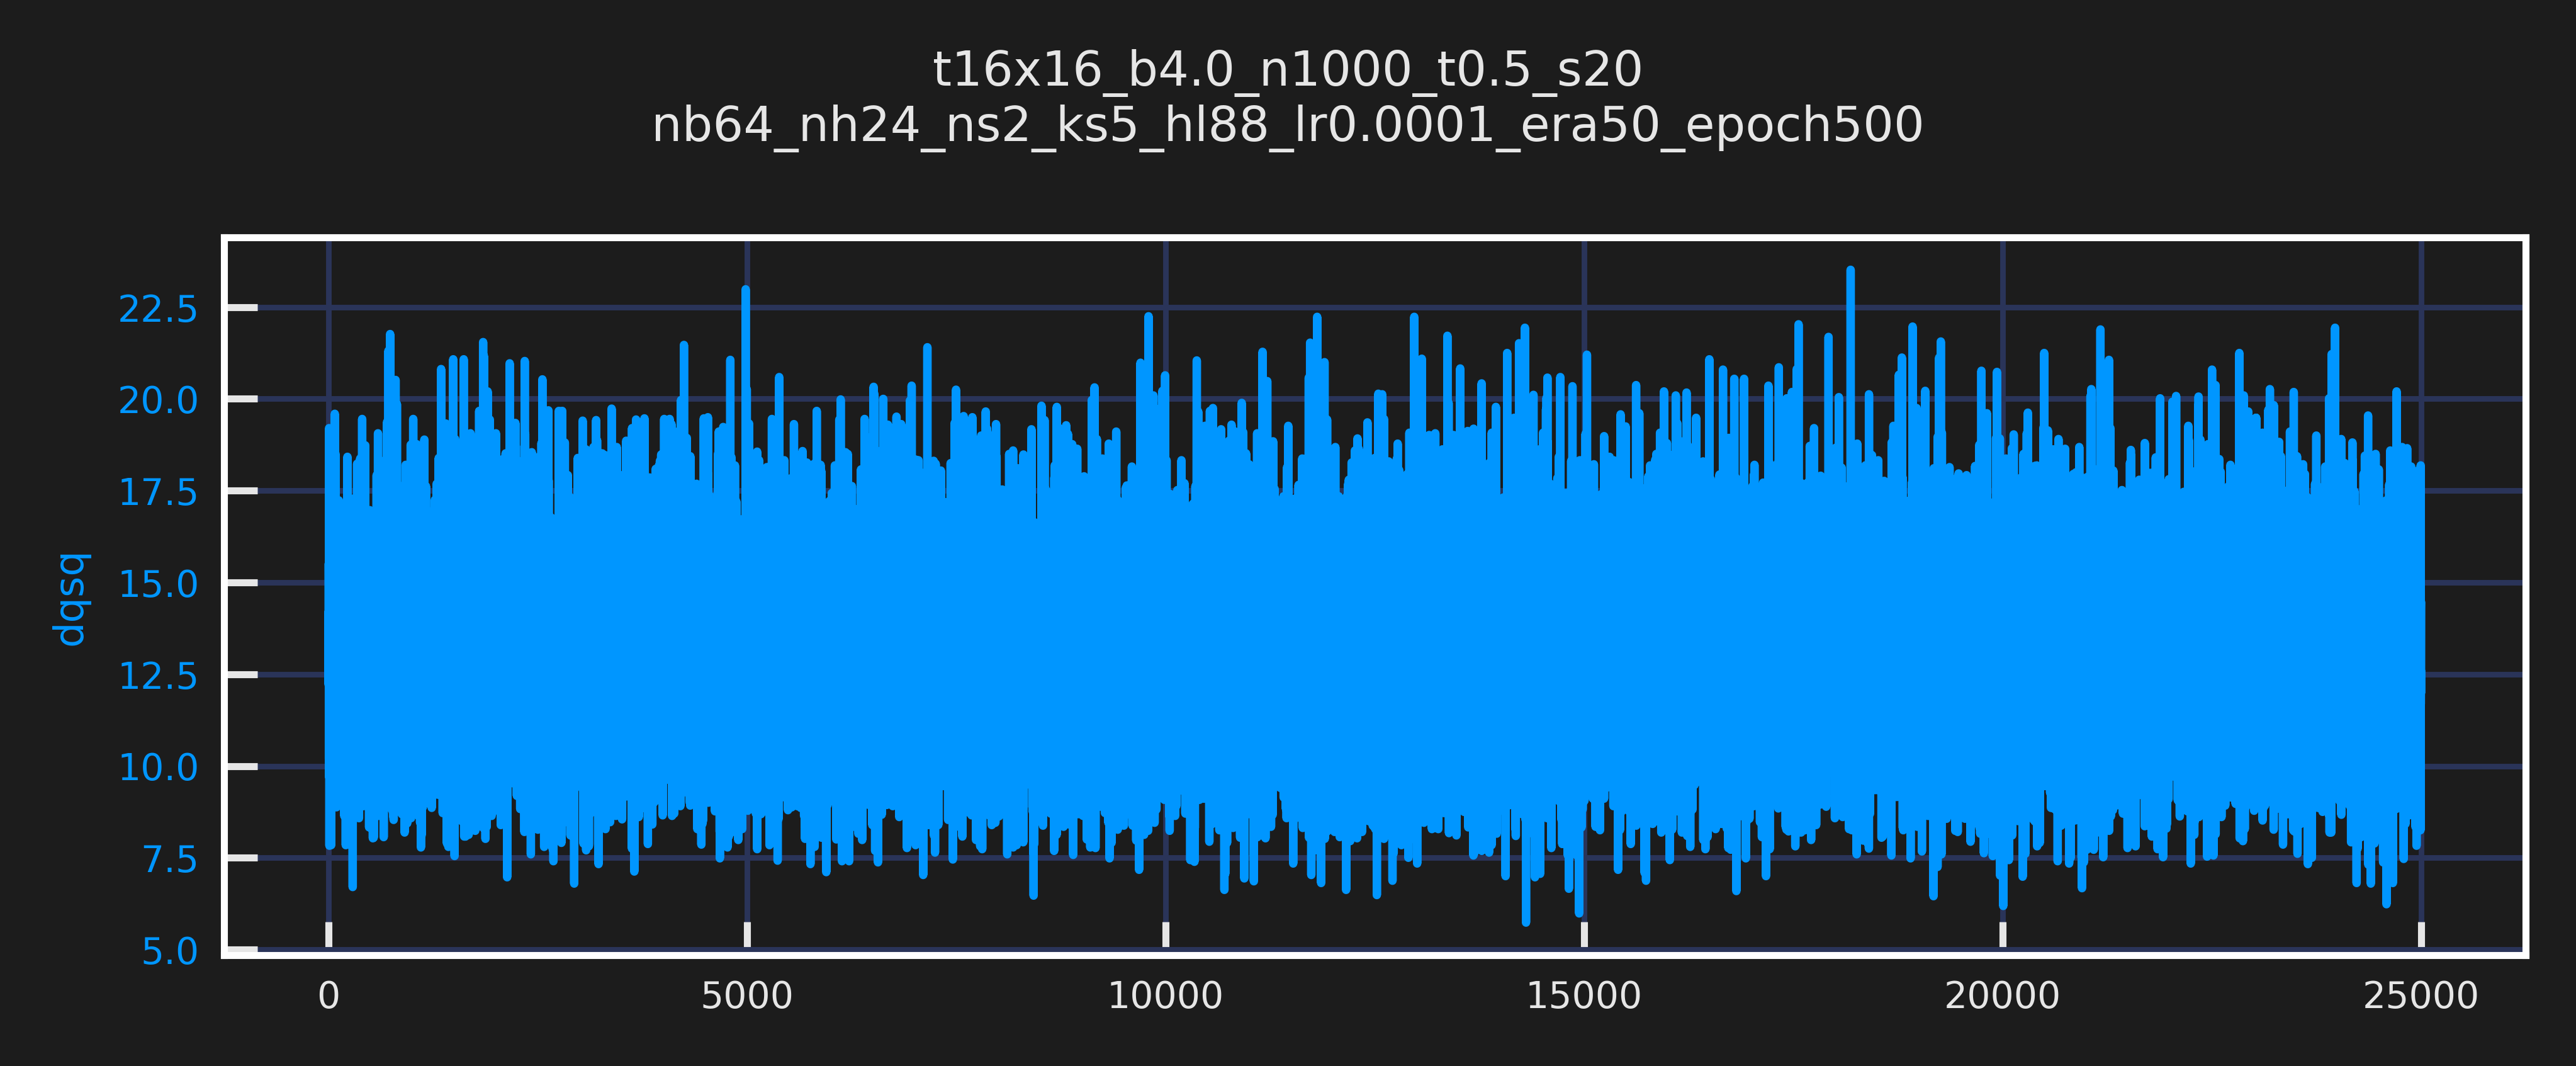

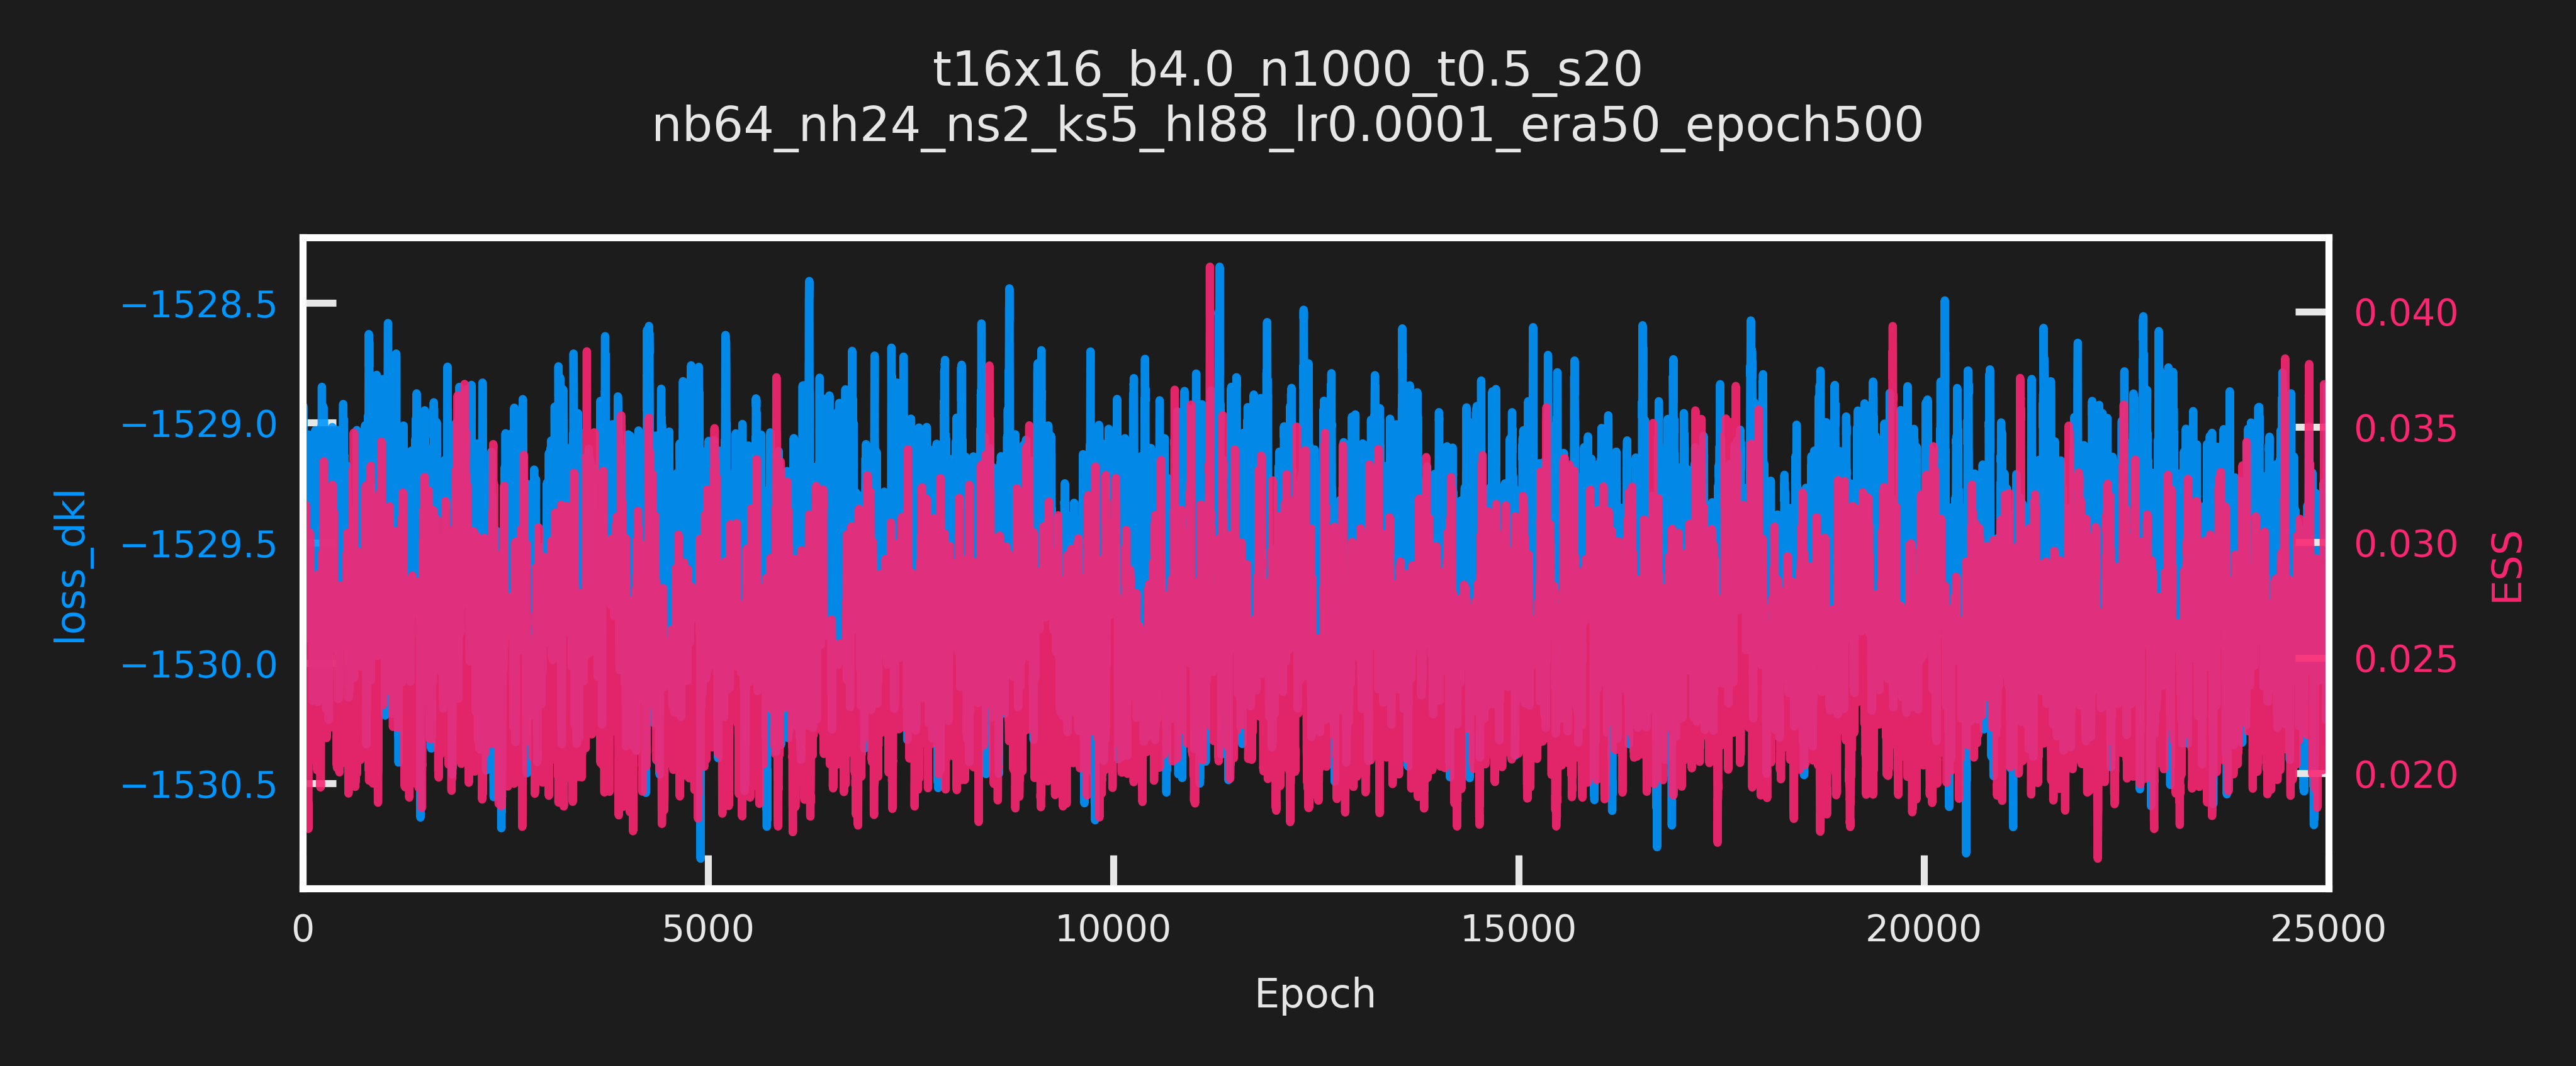

─────────────────────────────── ERA=0, last took: 0 min 0 sec ───────────────────────────────

[17:46:12]  dt=0.127 loss=-1529.519 ess=0.016 logp=838.496 logq=-691.023 dqsq=11.266         
            plaq=0.819

[17:46:26]  dt=0.128 loss=-1527.312 ess=0.030 logp=832.527 logq=-694.786 dqsq=12.750         
            plaq=0.813

[17:46:40]  dt=0.128 loss=-1529.807 ess=0.032 logp=834.457 logq=-695.350 dqsq=9.453          
            plaq=0.815

[17:46:54]  dt=0.129 loss=-1527.088 ess=0.039 logp=834.529 logq=-692.559 dqsq=9.719          
            plaq=0.815

[17:47:08]  dt=0.129 loss=-1529.208 ess=0.034 logp=839.748 logq=-689.461 dqsq=10.828         
            plaq=0.820

[17:47:09]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era0-epoch499.tar

───────────────────────────── ERA=1, last took: 1 min 9.79 sec ──────────────────────────────

[17:47:22]  dt=0.130 loss=-1529.568 ess=0.031 logp=839.175 logq=-690.394 dqsq=14.531         
            plaq=0.820

[17:47:37]  dt=0.130 loss=-1528.945 ess=0.019 logp=840.339 logq=-688.606 dqsq=9.875          
            plaq=0.821

[17:47:51]  dt=0.130 loss=-1529.507 ess=0.019 logp=840.175 logq=-689.332 dqsq=14.094         
            plaq=0.820

[17:48:05]  dt=0.130 loss=-1529.165 ess=0.034 logp=839.690 logq=-689.475 dqsq=10.094         
            plaq=0.820

[17:48:19]  dt=0.130 loss=-1529.737 ess=0.034 logp=841.209 logq=-688.527 dqsq=10.062         
            plaq=0.821

[17:48:20]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era1-epoch499.tar

───────────────────────────── ERA=2, last took: 1 min 10.95 sec ─────────────────────────────

[17:48:34]  dt=0.130 loss=-1528.552 ess=0.016 logp=835.841 logq=-692.712 dqsq=16.125         
            plaq=0.816

[17:48:48]  dt=0.130 loss=-1529.397 ess=0.016 logp=837.014 logq=-692.383 dqsq=10.875         
            plaq=0.817

[17:49:02]  dt=0.130 loss=-1531.408 ess=0.021 logp=838.772 logq=-692.636 dqsq=11.750         
            plaq=0.819

[17:49:16]  dt=0.130 loss=-1530.333 ess=0.016 logp=839.995 logq=-690.339 dqsq=12.859         
            plaq=0.820

[17:49:31]  dt=0.130 loss=-1530.977 ess=0.021 logp=841.101 logq=-689.876 dqsq=12.266         
            plaq=0.821

[17:49:32]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era2-epoch499.tar

───────────────────────────── ERA=3, last took: 1 min 11.35 sec ─────────────────────────────

[17:49:45]  dt=0.130 loss=-1528.462 ess=0.028 logp=836.720 logq=-691.742 dqsq=9.391          
            plaq=0.817

[17:49:59]  dt=0.130 loss=-1528.837 ess=0.017 logp=836.338 logq=-692.499 dqsq=15.016         
            plaq=0.817

[17:50:14]  dt=0.130 loss=-1528.392 ess=0.019 logp=837.544 logq=-690.848 dqsq=11.016         
            plaq=0.818

[17:50:28]  dt=0.130 loss=-1528.380 ess=0.038 logp=838.034 logq=-690.346 dqsq=12.687         
            plaq=0.818

[17:50:42]  dt=0.130 loss=-1528.354 ess=0.035 logp=837.025 logq=-691.329 dqsq=9.250          
            plaq=0.817

[17:50:43]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era3-epoch499.tar

───────────────────────────── ERA=4, last took: 1 min 11.54 sec ─────────────────────────────

[17:50:58]  dt=0.130 loss=-1529.432 ess=0.039 logp=838.679 logq=-690.753 dqsq=11.266         
            plaq=0.819

[17:51:12]  dt=0.130 loss=-1530.526 ess=0.016 logp=839.365 logq=-691.161 dqsq=10.844         
            plaq=0.820

[17:51:26]  dt=0.130 loss=-1530.275 ess=0.029 logp=841.673 logq=-688.602 dqsq=12.172         
            plaq=0.822

[17:51:40]  dt=0.131 loss=-1530.901 ess=0.016 logp=840.329 logq=-690.571 dqsq=15.547         
            plaq=0.821

[17:51:55]  dt=0.130 loss=-1530.925 ess=0.017 logp=839.169 logq=-691.756 dqsq=11.000         
            plaq=0.820

[17:51:56]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era4-epoch499.tar

───────────────────────────── ERA=5, last took: 1 min 11.14 sec ─────────────────────────────

[17:52:09]  dt=0.130 loss=-1528.598 ess=0.020 logp=837.424 logq=-691.174 dqsq=14.438         
            plaq=0.818

[17:52:23]  dt=0.130 loss=-1528.258 ess=0.043 logp=837.880 logq=-690.378 dqsq=14.688         
            plaq=0.818

[17:52:38]  dt=0.130 loss=-1528.793 ess=0.035 logp=838.532 logq=-690.261 dqsq=14.906         
            plaq=0.819

[17:52:52]  dt=0.130 loss=-1530.862 ess=0.016 logp=840.746 logq=-690.116 dqsq=13.141         
            plaq=0.821

[17:53:06]  dt=0.130 loss=-1530.459 ess=0.028 logp=839.407 logq=-691.052 dqsq=15.844         
            plaq=0.820

[17:53:07]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era5-epoch499.tar

───────────────────────────── ERA=6, last took: 1 min 11.28 sec ─────────────────────────────

[17:53:21]  dt=0.130 loss=-1528.875 ess=0.026 logp=836.576 logq=-692.300 dqsq=15.906         
            plaq=0.817

[17:53:35]  dt=0.130 loss=-1529.896 ess=0.038 logp=835.171 logq=-694.725 dqsq=10.688         
            plaq=0.816

[17:53:49]  dt=0.130 loss=-1530.444 ess=0.035 logp=838.110 logq=-692.333 dqsq=10.453         
            plaq=0.818

[17:54:04]  dt=0.130 loss=-1530.720 ess=0.018 logp=838.457 logq=-692.263 dqsq=10.156         
            plaq=0.819

[17:54:18]  dt=0.130 loss=-1530.419 ess=0.045 logp=837.611 logq=-692.807 dqsq=16.188         
            plaq=0.818

[17:54:19]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era6-epoch499.tar

───────────────────────────── ERA=7, last took: 1 min 11.63 sec ─────────────────────────────

[17:54:33]  dt=0.134 loss=-1530.576 ess=0.018 logp=841.125 logq=-689.452 dqsq=11.562         
            plaq=0.821

[17:54:48]  dt=0.134 loss=-1527.374 ess=0.017 logp=835.703 logq=-691.671 dqsq=11.047         
            plaq=0.816

[17:55:03]  dt=0.132 loss=-1529.895 ess=0.053 logp=840.632 logq=-689.263 dqsq=13.484         
            plaq=0.821

[17:55:17]  dt=0.133 loss=-1528.483 ess=0.016 logp=839.607 logq=-688.876 dqsq=11.500         
            plaq=0.820

[17:55:32]  dt=0.132 loss=-1528.868 ess=0.016 logp=840.765 logq=-688.103 dqsq=9.766          
            plaq=0.821

[17:55:33]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era7-epoch499.tar

───────────────────────────── ERA=8, last took: 1 min 13.91 sec ─────────────────────────────

[17:55:47]  dt=0.132 loss=-1529.688 ess=0.018 logp=838.466 logq=-691.223 dqsq=9.688          
            plaq=0.819

[17:56:02]  dt=0.132 loss=-1530.317 ess=0.021 logp=838.554 logq=-691.764 dqsq=13.281         
            plaq=0.819

[17:56:17]  dt=0.133 loss=-1529.365 ess=0.074 logp=839.082 logq=-690.283 dqsq=12.406         
            plaq=0.819

[17:56:31]  dt=0.132 loss=-1528.632 ess=0.030 logp=836.711 logq=-691.921 dqsq=15.594         
            plaq=0.817

[17:56:46]  dt=0.132 loss=-1528.682 ess=0.016 logp=836.039 logq=-692.643 dqsq=11.797         
            plaq=0.816

[17:56:47]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era8-epoch499.tar

───────────────────────────── ERA=9, last took: 1 min 13.5 sec ──────────────────────────────

[17:57:01]  dt=0.132 loss=-1528.742 ess=0.022 logp=837.148 logq=-691.595 dqsq=11.578         
            plaq=0.818

[17:57:15]  dt=0.132 loss=-1526.825 ess=0.016 logp=835.826 logq=-690.999 dqsq=14.328         
            plaq=0.816

[17:57:30]  dt=0.132 loss=-1529.550 ess=0.065 logp=841.311 logq=-688.240 dqsq=12.062         
            plaq=0.822

[17:57:45]  dt=0.132 loss=-1528.415 ess=0.016 logp=837.182 logq=-691.233 dqsq=12.906         
            plaq=0.818

[17:58:00]  dt=0.131 loss=-1532.106 ess=0.059 logp=838.841 logq=-693.265 dqsq=16.047         
            plaq=0.819

[17:58:01]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era9-epoch499.tar

──────────────────────────── ERA=10, last took: 1 min 13.32 sec ─────────────────────────────

[17:58:15]  dt=0.132 loss=-1530.049 ess=0.040 logp=839.674 logq=-690.375 dqsq=10.828         
            plaq=0.820

[17:58:29]  dt=0.132 loss=-1532.921 ess=0.025 logp=842.030 logq=-690.891 dqsq=10.078         
            plaq=0.822

[17:58:44]  dt=0.132 loss=-1528.014 ess=0.030 logp=837.230 logq=-690.784 dqsq=14.375         
            plaq=0.818

[17:58:59]  dt=0.133 loss=-1531.030 ess=0.031 logp=840.004 logq=-691.026 dqsq=11.766         
            plaq=0.820

[17:59:13]  dt=0.132 loss=-1530.737 ess=0.016 logp=838.094 logq=-692.642 dqsq=10.703         
            plaq=0.818

[17:59:14]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era10-epoch499.tar

──────────────────────────── ERA=11, last took: 1 min 13.37 sec ─────────────────────────────

[17:59:28]  dt=0.132 loss=-1526.616 ess=0.033 logp=832.070 logq=-694.545 dqsq=14.062         
            plaq=0.813

[17:59:43]  dt=0.132 loss=-1532.431 ess=0.057 logp=844.608 logq=-687.823 dqsq=15.719         
            plaq=0.825

[17:59:58]  dt=0.132 loss=-1529.266 ess=0.016 logp=837.924 logq=-691.343 dqsq=10.797         
            plaq=0.818

[18:00:12]  dt=0.132 loss=-1527.991 ess=0.022 logp=838.081 logq=-689.910 dqsq=8.594          
            plaq=0.818

[18:00:27]  dt=0.132 loss=-1530.116 ess=0.025 logp=838.180 logq=-691.937 dqsq=13.641         
            plaq=0.819

[18:00:28]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era11-epoch499.tar

──────────────────────────── ERA=12, last took: 1 min 13.53 sec ─────────────────────────────

[18:00:42]  dt=0.132 loss=-1529.584 ess=0.034 logp=838.041 logq=-691.544 dqsq=12.516         
            plaq=0.818

[18:00:57]  dt=0.132 loss=-1530.388 ess=0.018 logp=838.674 logq=-691.714 dqsq=9.609          
            plaq=0.819

[18:01:12]  dt=0.132 loss=-1531.737 ess=0.029 logp=841.942 logq=-689.795 dqsq=10.531         
            plaq=0.822

[18:01:27]  dt=0.132 loss=-1529.112 ess=0.025 logp=837.240 logq=-691.871 dqsq=13.562         
            plaq=0.818

[18:01:41]  dt=0.132 loss=-1527.608 ess=0.028 logp=834.450 logq=-693.158 dqsq=15.984         
            plaq=0.815

[18:01:43]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era12-epoch499.tar

──────────────────────────── ERA=13, last took: 1 min 13.77 sec ─────────────────────────────

[18:01:57]  dt=0.132 loss=-1529.392 ess=0.062 logp=837.686 logq=-691.706 dqsq=12.672         
            plaq=0.818

[18:02:11]  dt=0.132 loss=-1528.302 ess=0.016 logp=839.864 logq=-688.438 dqsq=14.359         
            plaq=0.820

[18:02:26]  dt=0.132 loss=-1528.617 ess=0.016 logp=835.609 logq=-693.008 dqsq=12.312         
            plaq=0.816

[18:02:41]  dt=0.132 loss=-1530.753 ess=0.016 logp=842.271 logq=-688.482 dqsq=11.391         
            plaq=0.823

[18:02:56]  dt=0.132 loss=-1530.033 ess=0.018 logp=840.995 logq=-689.038 dqsq=9.812          
            plaq=0.821

[18:02:57]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era13-epoch499.tar

──────────────────────────── ERA=14, last took: 1 min 13.91 sec ─────────────────────────────

[18:03:11]  dt=0.132 loss=-1529.106 ess=0.017 logp=837.307 logq=-691.799 dqsq=9.078          
            plaq=0.818

[18:03:26]  dt=0.132 loss=-1527.385 ess=0.035 logp=839.876 logq=-687.510 dqsq=13.250         
            plaq=0.820

[18:03:41]  dt=0.132 loss=-1530.808 ess=0.024 logp=840.530 logq=-690.278 dqsq=13.906         
            plaq=0.821

[18:03:56]  dt=0.135 loss=-1528.479 ess=0.052 logp=837.820 logq=-690.660 dqsq=12.000         
            plaq=0.818

[18:04:10]  dt=0.132 loss=-1529.479 ess=0.064 logp=838.132 logq=-691.347 dqsq=17.312         
            plaq=0.818

[18:04:12]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era14-epoch499.tar

──────────────────────────── ERA=15, last took: 1 min 14.15 sec ─────────────────────────────

[18:04:26]  dt=0.133 loss=-1528.889 ess=0.016 logp=839.764 logq=-689.125 dqsq=14.359         
            plaq=0.820

[18:04:41]  dt=0.134 loss=-1531.248 ess=0.016 logp=842.432 logq=-688.816 dqsq=12.578         
            plaq=0.823

[18:04:56]  dt=0.133 loss=-1528.896 ess=0.056 logp=840.024 logq=-688.871 dqsq=10.859         
            plaq=0.820

[18:05:11]  dt=0.133 loss=-1530.595 ess=0.060 logp=845.445 logq=-685.150 dqsq=8.641          
            plaq=0.826

[18:05:26]  dt=0.133 loss=-1529.841 ess=0.018 logp=837.550 logq=-692.291 dqsq=11.109         
            plaq=0.818

[18:05:27]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era15-epoch499.tar

───────────────────────────── ERA=16, last took: 1 min 14.7 sec ─────────────────────────────

[18:05:41]  dt=0.133 loss=-1527.426 ess=0.021 logp=836.183 logq=-691.243 dqsq=14.437         
            plaq=0.817

[18:05:56]  dt=0.134 loss=-1530.608 ess=0.017 logp=837.810 logq=-692.798 dqsq=13.391         
            plaq=0.818

[18:06:11]  dt=0.133 loss=-1529.701 ess=0.048 logp=842.337 logq=-687.364 dqsq=7.922          
            plaq=0.823

[18:06:26]  dt=0.133 loss=-1531.371 ess=0.089 logp=842.193 logq=-689.178 dqsq=10.875         
            plaq=0.822

[18:06:41]  dt=0.133 loss=-1531.631 ess=0.030 logp=839.481 logq=-692.150 dqsq=13.125         
            plaq=0.820

[18:06:43]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era16-epoch499.tar

──────────────────────────── ERA=17, last took: 1 min 14.89 sec ─────────────────────────────

[18:06:57]  dt=0.134 loss=-1530.350 ess=0.044 logp=840.850 logq=-689.499 dqsq=13.562         
            plaq=0.821

[18:07:12]  dt=0.135 loss=-1529.142 ess=0.021 logp=835.881 logq=-693.261 dqsq=12.125         
            plaq=0.816

[18:07:27]  dt=0.133 loss=-1530.642 ess=0.018 logp=843.088 logq=-687.554 dqsq=12.875         
            plaq=0.823

[18:07:42]  dt=0.132 loss=-1528.360 ess=0.016 logp=839.165 logq=-689.195 dqsq=14.062         
            plaq=0.819

[18:07:57]  dt=0.133 loss=-1529.444 ess=0.021 logp=839.100 logq=-690.344 dqsq=12.453         
            plaq=0.819

[18:07:58]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era17-epoch499.tar

──────────────────────────── ERA=18, last took: 1 min 15.02 sec ─────────────────────────────

[18:08:12]  dt=0.133 loss=-1529.580 ess=0.016 logp=837.959 logq=-691.621 dqsq=14.547         
            plaq=0.818

[18:08:27]  dt=0.133 loss=-1526.995 ess=0.027 logp=836.404 logq=-690.590 dqsq=12.500         
            plaq=0.817

[18:08:42]  dt=0.133 loss=-1530.259 ess=0.026 logp=839.836 logq=-690.423 dqsq=16.078         
            plaq=0.820

[18:08:58]  dt=0.133 loss=-1531.088 ess=0.024 logp=838.663 logq=-692.424 dqsq=15.922         
            plaq=0.819

[18:09:13]  dt=0.133 loss=-1531.234 ess=0.021 logp=840.724 logq=-690.510 dqsq=13.547         
            plaq=0.821

[18:09:14]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era18-epoch499.tar

──────────────────────────── ERA=19, last took: 1 min 15.07 sec ─────────────────────────────

[18:09:28]  dt=0.133 loss=-1531.908 ess=0.020 logp=840.952 logq=-690.956 dqsq=18.047         
            plaq=0.821

[18:09:43]  dt=0.133 loss=-1528.663 ess=0.039 logp=836.840 logq=-691.823 dqsq=10.891         
            plaq=0.817

[18:09:58]  dt=0.133 loss=-1530.016 ess=0.016 logp=837.256 logq=-692.759 dqsq=10.922         
            plaq=0.818

[18:10:13]  dt=0.133 loss=-1528.990 ess=0.036 logp=837.869 logq=-691.121 dqsq=13.062         
            plaq=0.818

[18:10:28]  dt=0.133 loss=-1529.914 ess=0.018 logp=838.264 logq=-691.650 dqsq=16.047         
            plaq=0.819

[18:10:30]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era19-epoch499.tar

───────────────────────────── ERA=20, last took: 1 min 15.3 sec ─────────────────────────────

[18:10:44]  dt=0.133 loss=-1530.909 ess=0.016 logp=842.539 logq=-688.370 dqsq=10.375         
            plaq=0.823

[18:10:59]  dt=0.133 loss=-1529.326 ess=0.040 logp=838.250 logq=-691.075 dqsq=16.094         
            plaq=0.819

[18:11:15]  dt=0.133 loss=-1529.943 ess=0.016 logp=841.378 logq=-688.565 dqsq=14.672         
            plaq=0.822

[18:11:30]  dt=0.133 loss=-1527.909 ess=0.016 logp=838.188 logq=-689.722 dqsq=11.031         
            plaq=0.819

[18:11:45]  dt=0.132 loss=-1531.339 ess=0.031 logp=840.165 logq=-691.174 dqsq=15.375         
            plaq=0.820

[18:11:46]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era20-epoch499.tar

──────────────────────────── ERA=21, last took: 1 min 15.43 sec ─────────────────────────────

[18:12:01]  dt=0.133 loss=-1529.416 ess=0.017 logp=835.634 logq=-693.783 dqsq=11.562         
            plaq=0.816

[18:12:16]  dt=0.133 loss=-1529.070 ess=0.019 logp=837.972 logq=-691.097 dqsq=9.078          
            plaq=0.818

[18:12:31]  dt=0.132 loss=-1529.404 ess=0.024 logp=837.554 logq=-691.850 dqsq=14.812         
            plaq=0.818

[18:12:46]  dt=0.133 loss=-1530.182 ess=0.024 logp=838.310 logq=-691.872 dqsq=11.063         
            plaq=0.819

[18:13:01]  dt=0.133 loss=-1529.835 ess=0.016 logp=837.242 logq=-692.594 dqsq=10.328         
            plaq=0.818

[18:13:03]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era21-epoch499.tar

──────────────────────────── ERA=22, last took: 1 min 15.55 sec ─────────────────────────────

[18:13:17]  dt=0.133 loss=-1531.374 ess=0.017 logp=841.806 logq=-689.568 dqsq=13.484         
            plaq=0.822

[18:13:32]  dt=0.133 loss=-1530.426 ess=0.016 logp=840.147 logq=-690.279 dqsq=13.109         
            plaq=0.820

[18:13:47]  dt=0.133 loss=-1531.939 ess=0.016 logp=841.379 logq=-690.560 dqsq=15.219         
            plaq=0.822

[18:14:02]  dt=0.132 loss=-1527.872 ess=0.023 logp=832.793 logq=-695.079 dqsq=11.469         
            plaq=0.813

[18:14:18]  dt=0.133 loss=-1529.107 ess=0.016 logp=838.918 logq=-690.188 dqsq=13.344         
            plaq=0.819

[18:14:19]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era22-epoch499.tar

──────────────────────────── ERA=23, last took: 1 min 15.74 sec ─────────────────────────────

[18:14:34]  dt=0.133 loss=-1531.712 ess=0.027 logp=844.206 logq=-687.505 dqsq=12.438         
            plaq=0.824

[18:14:49]  dt=0.133 loss=-1528.838 ess=0.016 logp=839.145 logq=-689.693 dqsq=11.781         
            plaq=0.819

[18:15:04]  dt=0.133 loss=-1529.122 ess=0.039 logp=836.930 logq=-692.193 dqsq=16.312         
            plaq=0.817

[18:15:19]  dt=0.132 loss=-1526.907 ess=0.030 logp=833.396 logq=-693.510 dqsq=14.922         
            plaq=0.814

[18:15:34]  dt=0.133 loss=-1529.410 ess=0.032 logp=838.873 logq=-690.537 dqsq=11.297         
            plaq=0.819

[18:15:36]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era23-epoch499.tar

──────────────────────────── ERA=24, last took: 1 min 15.96 sec ─────────────────────────────

[18:15:51]  dt=0.134 loss=-1527.645 ess=0.017 logp=836.577 logq=-691.068 dqsq=14.766         
            plaq=0.817

[18:16:06]  dt=0.134 loss=-1528.961 ess=0.031 logp=839.289 logq=-689.672 dqsq=10.188         
            plaq=0.820

[18:16:21]  dt=0.134 loss=-1529.499 ess=0.056 logp=839.150 logq=-690.349 dqsq=11.312         
            plaq=0.819

[18:16:37]  dt=0.135 loss=-1528.681 ess=0.019 logp=838.153 logq=-690.528 dqsq=12.297         
            plaq=0.819

[18:16:52]  dt=0.133 loss=-1529.816 ess=0.016 logp=837.807 logq=-692.009 dqsq=11.125         
            plaq=0.818

[18:16:54]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era24-epoch499.tar

──────────────────────────── ERA=25, last took: 1 min 16.68 sec ─────────────────────────────

[18:17:08]  dt=0.137 loss=-1530.550 ess=0.021 logp=839.234 logq=-691.316 dqsq=15.156         
            plaq=0.820

[18:17:24]  dt=0.131 loss=-1527.818 ess=0.043 logp=836.190 logq=-691.628 dqsq=12.125         
            plaq=0.817

[18:17:39]  dt=0.131 loss=-1530.068 ess=0.037 logp=842.132 logq=-687.936 dqsq=12.672         
            plaq=0.822

[18:17:53]  dt=0.130 loss=-1529.823 ess=0.038 logp=839.555 logq=-690.268 dqsq=14.938         
            plaq=0.820

[18:18:08]  dt=0.131 loss=-1530.209 ess=0.052 logp=838.702 logq=-691.507 dqsq=12.016         
            plaq=0.819

[18:18:10]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era25-epoch499.tar

──────────────────────────── ERA=26, last took: 1 min 15.58 sec ─────────────────────────────

[18:18:25]  dt=0.131 loss=-1526.513 ess=0.036 logp=833.596 logq=-692.917 dqsq=15.516         
            plaq=0.814

[18:18:40]  dt=0.130 loss=-1527.775 ess=0.033 logp=835.997 logq=-691.778 dqsq=12.375         
            plaq=0.816

[18:18:56]  dt=0.131 loss=-1527.653 ess=0.016 logp=837.363 logq=-690.290 dqsq=15.156         
            plaq=0.818

[18:19:11]  dt=0.132 loss=-1530.439 ess=0.033 logp=841.161 logq=-689.278 dqsq=15.297         
            plaq=0.821

[18:19:26]  dt=0.131 loss=-1527.664 ess=0.030 logp=838.919 logq=-688.745 dqsq=13.406         
            plaq=0.819

[18:19:27]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era26-epoch499.tar

──────────────────────────── ERA=27, last took: 1 min 16.24 sec ─────────────────────────────

[18:19:42]  dt=0.131 loss=-1530.517 ess=0.016 logp=841.047 logq=-689.470 dqsq=17.891         
            plaq=0.821

[18:19:57]  dt=0.131 loss=-1531.239 ess=0.016 logp=843.753 logq=-687.486 dqsq=17.641         
            plaq=0.824

[18:20:12]  dt=0.131 loss=-1529.587 ess=0.030 logp=843.711 logq=-685.876 dqsq=15.672         
            plaq=0.824

[18:20:27]  dt=0.147 loss=-1529.045 ess=0.047 logp=837.607 logq=-691.439 dqsq=13.594         
            plaq=0.818

[18:20:43]  dt=0.131 loss=-1531.833 ess=0.037 logp=840.919 logq=-690.914 dqsq=10.891         
            plaq=0.821

[18:20:44]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era27-epoch499.tar

──────────────────────────── ERA=28, last took: 1 min 15.86 sec ─────────────────────────────

[18:20:59]  dt=0.131 loss=-1528.237 ess=0.016 logp=837.321 logq=-690.916 dqsq=9.969          
            plaq=0.818

[18:21:14]  dt=0.131 loss=-1528.174 ess=0.020 logp=836.778 logq=-691.396 dqsq=17.062         
            plaq=0.817

[18:21:29]  dt=0.131 loss=-1530.008 ess=0.016 logp=837.967 logq=-692.041 dqsq=15.062         
            plaq=0.818

[18:21:44]  dt=0.131 loss=-1529.031 ess=0.028 logp=838.040 logq=-690.991 dqsq=11.422         
            plaq=0.818

[18:21:59]  dt=0.131 loss=-1530.478 ess=0.029 logp=841.340 logq=-689.139 dqsq=14.094         
            plaq=0.822

[18:22:01]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era28-epoch499.tar

──────────────────────────── ERA=29, last took: 1 min 15.52 sec ─────────────────────────────

[18:22:16]  dt=0.134 loss=-1529.988 ess=0.019 logp=842.481 logq=-687.507 dqsq=12.938         
            plaq=0.823

[18:22:31]  dt=0.134 loss=-1531.347 ess=0.017 logp=842.740 logq=-688.607 dqsq=12.328         
            plaq=0.823

[18:22:46]  dt=0.134 loss=-1526.791 ess=0.022 logp=834.433 logq=-692.358 dqsq=13.375         
            plaq=0.815

[18:23:02]  dt=0.131 loss=-1528.525 ess=0.020 logp=833.761 logq=-694.764 dqsq=15.219         
            plaq=0.814

[18:23:17]  dt=0.131 loss=-1529.231 ess=0.020 logp=840.751 logq=-688.480 dqsq=11.375         
            plaq=0.821

[18:23:19]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era29-epoch499.tar

──────────────────────────── ERA=30, last took: 1 min 16.21 sec ─────────────────────────────

[18:23:33]  dt=0.131 loss=-1529.287 ess=0.016 logp=837.972 logq=-691.314 dqsq=10.219         
            plaq=0.818

[18:23:49]  dt=0.131 loss=-1529.289 ess=0.017 logp=836.331 logq=-692.958 dqsq=9.781          
            plaq=0.817

[18:24:04]  dt=0.131 loss=-1530.143 ess=0.022 logp=841.486 logq=-688.657 dqsq=14.594         
            plaq=0.822

[18:24:19]  dt=0.131 loss=-1528.061 ess=0.016 logp=838.377 logq=-689.684 dqsq=13.953         
            plaq=0.819

[18:24:34]  dt=0.132 loss=-1529.510 ess=0.017 logp=838.074 logq=-691.436 dqsq=11.625         
            plaq=0.818

[18:24:36]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era30-epoch499.tar

──────────────────────────── ERA=31, last took: 1 min 16.54 sec ─────────────────────────────

[18:24:51]  dt=0.131 loss=-1530.207 ess=0.023 logp=841.276 logq=-688.931 dqsq=15.406         
            plaq=0.822

[18:25:06]  dt=0.131 loss=-1529.213 ess=0.016 logp=839.725 logq=-689.488 dqsq=15.047         
            plaq=0.820

[18:25:22]  dt=0.151 loss=-1532.020 ess=0.016 logp=843.103 logq=-688.916 dqsq=13.812         
            plaq=0.823

[18:25:37]  dt=0.134 loss=-1529.391 ess=0.044 logp=837.690 logq=-691.701 dqsq=10.938         
            plaq=0.818

[18:25:53]  dt=0.133 loss=-1529.850 ess=0.016 logp=836.850 logq=-692.999 dqsq=10.078         
            plaq=0.817

[18:25:55]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era31-epoch499.tar

──────────────────────────── ERA=32, last took: 1 min 17.26 sec ─────────────────────────────

[18:26:10]  dt=0.133 loss=-1531.575 ess=0.020 logp=841.491 logq=-690.084 dqsq=14.875         
            plaq=0.822

[18:26:25]  dt=0.134 loss=-1530.251 ess=0.026 logp=840.293 logq=-689.958 dqsq=18.828         
            plaq=0.821

[18:26:41]  dt=0.133 loss=-1529.220 ess=0.019 logp=836.707 logq=-692.513 dqsq=12.406         
            plaq=0.817

[18:26:56]  dt=0.143 loss=-1530.107 ess=0.016 logp=839.838 logq=-690.269 dqsq=9.562          
            plaq=0.820

[18:27:12]  dt=0.131 loss=-1533.325 ess=0.031 logp=847.016 logq=-686.309 dqsq=12.250         
            plaq=0.827

[18:27:14]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era32-epoch499.tar

──────────────────────────── ERA=33, last took: 1 min 17.96 sec ─────────────────────────────

[18:27:29]  dt=0.132 loss=-1530.376 ess=0.036 logp=839.568 logq=-690.808 dqsq=8.688          
            plaq=0.820

[18:27:44]  dt=0.131 loss=-1529.255 ess=0.034 logp=837.014 logq=-692.242 dqsq=13.641         
            plaq=0.817

[18:28:00]  dt=0.131 loss=-1529.247 ess=0.016 logp=843.418 logq=-685.828 dqsq=12.797         
            plaq=0.824

[18:28:15]  dt=0.131 loss=-1528.784 ess=0.035 logp=836.608 logq=-692.176 dqsq=10.859         
            plaq=0.817

[18:28:30]  dt=0.131 loss=-1530.536 ess=0.018 logp=840.851 logq=-689.685 dqsq=13.172         
            plaq=0.821

[18:28:32]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era33-epoch499.tar

──────────────────────────── ERA=34, last took: 1 min 17.11 sec ─────────────────────────────

[18:28:48]  dt=0.134 loss=-1530.501 ess=0.016 logp=840.548 logq=-689.953 dqsq=13.344         
            plaq=0.821

[18:29:03]  dt=0.133 loss=-1528.749 ess=0.023 logp=837.172 logq=-691.577 dqsq=13.000         
            plaq=0.818

[18:29:19]  dt=0.134 loss=-1530.771 ess=0.021 logp=841.056 logq=-689.714 dqsq=9.406          
            plaq=0.821

[18:29:34]  dt=0.133 loss=-1527.707 ess=0.016 logp=838.724 logq=-688.983 dqsq=14.031         
            plaq=0.819

[18:29:50]  dt=0.134 loss=-1529.231 ess=0.025 logp=839.267 logq=-689.964 dqsq=12.328         
            plaq=0.820

[18:29:52]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era34-epoch499.tar

──────────────────────────── ERA=35, last took: 1 min 18.37 sec ─────────────────────────────

[18:30:07]  dt=0.133 loss=-1529.741 ess=0.016 logp=837.569 logq=-692.171 dqsq=13.312         
            plaq=0.818

[18:30:23]  dt=0.134 loss=-1530.769 ess=0.026 logp=840.593 logq=-690.176 dqsq=10.250         
            plaq=0.821

[18:30:39]  dt=0.133 loss=-1529.811 ess=0.022 logp=837.965 logq=-691.845 dqsq=14.359         
            plaq=0.818

[18:30:54]  dt=0.133 loss=-1529.438 ess=0.016 logp=838.623 logq=-690.815 dqsq=12.797         
            plaq=0.819

[18:31:10]  dt=0.134 loss=-1529.920 ess=0.016 logp=842.317 logq=-687.604 dqsq=16.047         
            plaq=0.823

[18:31:12]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era35-epoch499.tar

──────────────────────────── ERA=36, last took: 1 min 18.59 sec ─────────────────────────────

[18:31:27]  dt=0.134 loss=-1530.698 ess=0.039 logp=840.448 logq=-690.250 dqsq=14.687         
            plaq=0.821

[18:31:43]  dt=0.133 loss=-1529.692 ess=0.018 logp=837.478 logq=-692.214 dqsq=17.453         
            plaq=0.818

[18:31:59]  dt=0.132 loss=-1531.582 ess=0.030 logp=843.525 logq=-688.057 dqsq=10.969         
            plaq=0.824

[18:32:14]  dt=0.135 loss=-1530.859 ess=0.016 logp=841.074 logq=-689.785 dqsq=11.359         
            plaq=0.821

[18:32:29]  dt=0.131 loss=-1528.011 ess=0.021 logp=839.315 logq=-688.697 dqsq=9.734          
            plaq=0.820

[18:32:31]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era36-epoch499.tar

──────────────────────────── ERA=37, last took: 1 min 18.04 sec ─────────────────────────────

[18:32:46]  dt=0.131 loss=-1530.619 ess=0.046 logp=842.588 logq=-688.031 dqsq=14.406         
            plaq=0.823

[18:33:02]  dt=0.131 loss=-1530.446 ess=0.025 logp=841.230 logq=-689.216 dqsq=14.953         
            plaq=0.822

[18:33:17]  dt=0.131 loss=-1529.252 ess=0.016 logp=839.916 logq=-689.337 dqsq=12.047         
            plaq=0.820

[18:33:32]  dt=0.141 loss=-1528.819 ess=0.031 logp=838.457 logq=-690.363 dqsq=7.484          
            plaq=0.819

[18:33:48]  dt=0.131 loss=-1529.893 ess=0.016 logp=842.220 logq=-687.673 dqsq=13.703         
            plaq=0.822

[18:33:50]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era37-epoch499.tar

──────────────────────────── ERA=38, last took: 1 min 17.29 sec ─────────────────────────────

[18:34:05]  dt=0.131 loss=-1527.258 ess=0.018 logp=836.256 logq=-691.002 dqsq=15.438         
            plaq=0.817

[18:34:20]  dt=0.130 loss=-1529.565 ess=0.069 logp=841.541 logq=-688.024 dqsq=11.844         
            plaq=0.822

[18:34:36]  dt=0.131 loss=-1529.294 ess=0.018 logp=835.335 logq=-693.959 dqsq=11.516         
            plaq=0.816

[18:34:51]  dt=0.131 loss=-1530.045 ess=0.016 logp=841.882 logq=-688.163 dqsq=15.594         
            plaq=0.822

[18:35:06]  dt=0.131 loss=-1527.519 ess=0.016 logp=838.239 logq=-689.280 dqsq=11.094         
            plaq=0.819

[18:35:09]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era38-epoch499.tar

──────────────────────────── ERA=39, last took: 1 min 16.99 sec ─────────────────────────────

[18:35:24]  dt=0.131 loss=-1530.383 ess=0.016 logp=839.357 logq=-691.027 dqsq=17.406         
            plaq=0.820

[18:35:40]  dt=0.132 loss=-1530.762 ess=0.021 logp=839.186 logq=-691.576 dqsq=15.750         
            plaq=0.820

[18:35:55]  dt=0.134 loss=-1529.774 ess=0.044 logp=840.983 logq=-688.791 dqsq=12.234         
            plaq=0.821

[18:36:11]  dt=0.134 loss=-1531.094 ess=0.025 logp=845.092 logq=-686.002 dqsq=9.688          
            plaq=0.825

[18:36:27]  dt=0.133 loss=-1528.558 ess=0.016 logp=838.042 logq=-690.516 dqsq=14.234         
            plaq=0.818

[18:36:29]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era39-epoch499.tar

──────────────────────────── ERA=40, last took: 1 min 18.84 sec ─────────────────────────────

[18:36:44]  dt=0.133 loss=-1529.891 ess=0.019 logp=838.951 logq=-690.940 dqsq=16.750         
            plaq=0.819

[18:37:01]  dt=0.134 loss=-1528.183 ess=0.044 logp=837.647 logq=-690.536 dqsq=10.844         
            plaq=0.818

[18:37:16]  dt=0.134 loss=-1529.667 ess=0.024 logp=839.814 logq=-689.853 dqsq=11.141         
            plaq=0.820

[18:37:32]  dt=0.133 loss=-1530.436 ess=0.043 logp=841.150 logq=-689.286 dqsq=13.375         
            plaq=0.821

[18:37:48]  dt=0.134 loss=-1529.931 ess=0.016 logp=837.819 logq=-692.112 dqsq=9.453          
            plaq=0.818

[18:37:50]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era40-epoch499.tar

──────────────────────────── ERA=41, last took: 1 min 19.27 sec ─────────────────────────────

[18:38:05]  dt=0.132 loss=-1531.457 ess=0.017 logp=843.924 logq=-687.533 dqsq=12.922         
            plaq=0.824

[18:38:21]  dt=0.133 loss=-1530.748 ess=0.016 logp=842.800 logq=-687.949 dqsq=8.375          
            plaq=0.823

[18:38:37]  dt=0.131 loss=-1530.402 ess=0.021 logp=838.588 logq=-691.813 dqsq=14.266         
            plaq=0.819

[18:38:52]  dt=0.131 loss=-1529.204 ess=0.022 logp=838.773 logq=-690.431 dqsq=11.969         
            plaq=0.819

[18:39:08]  dt=0.131 loss=-1528.482 ess=0.039 logp=837.063 logq=-691.420 dqsq=13.188         
            plaq=0.817

[18:39:10]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era41-epoch499.tar

──────────────────────────── ERA=42, last took: 1 min 18.31 sec ─────────────────────────────

[18:39:25]  dt=0.131 loss=-1530.584 ess=0.050 logp=842.151 logq=-688.433 dqsq=9.531          
            plaq=0.822

[18:39:40]  dt=0.131 loss=-1529.208 ess=0.054 logp=838.181 logq=-691.028 dqsq=17.562         
            plaq=0.819

[18:39:56]  dt=0.131 loss=-1528.741 ess=0.018 logp=839.579 logq=-689.162 dqsq=12.969         
            plaq=0.820

[18:40:11]  dt=0.139 loss=-1530.492 ess=0.017 logp=843.629 logq=-686.863 dqsq=10.234         
            plaq=0.824

[18:40:27]  dt=0.131 loss=-1526.557 ess=0.023 logp=836.363 logq=-690.194 dqsq=11.234         
            plaq=0.817

[18:40:29]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era42-epoch499.tar

──────────────────────────── ERA=43, last took: 1 min 17.62 sec ─────────────────────────────

[18:40:44]  dt=0.131 loss=-1530.886 ess=0.028 logp=840.704 logq=-690.182 dqsq=10.828         
            plaq=0.821

[18:41:00]  dt=0.131 loss=-1528.648 ess=0.018 logp=836.031 logq=-692.617 dqsq=16.453         
            plaq=0.816

[18:41:15]  dt=0.131 loss=-1528.385 ess=0.028 logp=834.726 logq=-693.659 dqsq=14.547         
            plaq=0.815

[18:41:31]  dt=0.133 loss=-1528.846 ess=0.019 logp=839.524 logq=-689.322 dqsq=12.656         
            plaq=0.820

[18:41:47]  dt=0.142 loss=-1529.355 ess=0.016 logp=839.782 logq=-689.573 dqsq=12.281         
            plaq=0.820

[18:41:49]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era43-epoch499.tar

──────────────────────────── ERA=44, last took: 1 min 18.19 sec ─────────────────────────────

[18:42:04]  dt=0.131 loss=-1530.055 ess=0.025 logp=838.769 logq=-691.285 dqsq=11.938         
            plaq=0.819

[18:42:20]  dt=0.131 loss=-1530.610 ess=0.046 logp=840.466 logq=-690.144 dqsq=12.172         
            plaq=0.821

[18:42:35]  dt=0.131 loss=-1529.538 ess=0.031 logp=838.383 logq=-691.155 dqsq=13.156         
            plaq=0.819

[18:42:51]  dt=0.130 loss=-1529.180 ess=0.016 logp=838.428 logq=-690.751 dqsq=9.016          
            plaq=0.819

[18:43:06]  dt=0.130 loss=-1530.126 ess=0.079 logp=839.029 logq=-691.097 dqsq=12.922         
            plaq=0.819

[18:43:09]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era44-epoch499.tar

──────────────────────────── ERA=45, last took: 1 min 17.68 sec ─────────────────────────────

[18:43:24]  dt=0.131 loss=-1526.700 ess=0.016 logp=833.874 logq=-692.826 dqsq=9.828          
            plaq=0.814

[18:43:40]  dt=0.131 loss=-1530.918 ess=0.020 logp=840.708 logq=-690.210 dqsq=11.984         
            plaq=0.821

[18:43:55]  dt=0.131 loss=-1530.749 ess=0.028 logp=839.948 logq=-690.801 dqsq=14.016         
            plaq=0.820

[18:44:11]  dt=0.131 loss=-1530.404 ess=0.016 logp=841.369 logq=-689.036 dqsq=12.219         
            plaq=0.822

[18:44:26]  dt=0.131 loss=-1530.911 ess=0.022 logp=840.063 logq=-690.848 dqsq=13.625         
            plaq=0.820

[18:44:28]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era45-epoch499.tar

───────────────────────────── ERA=46, last took: 1 min 18.1 sec ─────────────────────────────

[18:44:43]  dt=0.131 loss=-1529.688 ess=0.016 logp=839.367 logq=-690.320 dqsq=15.406         
            plaq=0.820

[18:44:59]  dt=0.131 loss=-1529.125 ess=0.016 logp=838.579 logq=-690.546 dqsq=12.438         
            plaq=0.819

[18:45:15]  dt=0.131 loss=-1528.354 ess=0.049 logp=836.179 logq=-692.175 dqsq=14.531         
            plaq=0.817

[18:45:31]  dt=0.131 loss=-1529.014 ess=0.034 logp=836.002 logq=-693.013 dqsq=13.797         
            plaq=0.816

[18:45:46]  dt=0.131 loss=-1530.355 ess=0.018 logp=840.278 logq=-690.077 dqsq=14.188         
            plaq=0.821

[18:45:48]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era46-epoch499.tar

──────────────────────────── ERA=47, last took: 1 min 18.12 sec ─────────────────────────────

[18:46:03]  dt=0.131 loss=-1529.587 ess=0.042 logp=838.393 logq=-691.193 dqsq=9.609          
            plaq=0.819

[18:46:19]  dt=0.131 loss=-1531.309 ess=0.032 logp=841.796 logq=-689.513 dqsq=10.109         
            plaq=0.822

[18:46:35]  dt=0.131 loss=-1529.954 ess=0.032 logp=838.481 logq=-691.473 dqsq=15.297         
            plaq=0.819

[18:46:51]  dt=0.133 loss=-1529.330 ess=0.016 logp=838.035 logq=-691.295 dqsq=13.281         
            plaq=0.818

[18:47:07]  dt=0.133 loss=-1530.045 ess=0.016 logp=841.869 logq=-688.176 dqsq=10.359         
            plaq=0.822

[18:47:09]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era47-epoch499.tar

──────────────────────────── ERA=48, last took: 1 min 18.77 sec ─────────────────────────────

[18:47:25]  dt=0.134 loss=-1530.682 ess=0.016 logp=840.503 logq=-690.179 dqsq=12.250         
            plaq=0.821

[18:47:40]  dt=0.133 loss=-1529.264 ess=0.023 logp=837.358 logq=-691.906 dqsq=15.312         
            plaq=0.818

[18:47:56]  dt=0.133 loss=-1530.544 ess=0.019 logp=838.224 logq=-692.320 dqsq=9.328          
            plaq=0.819

[18:48:12]  dt=0.133 loss=-1529.479 ess=0.016 logp=835.877 logq=-693.602 dqsq=12.984         
            plaq=0.816

[18:48:29]  dt=0.143 loss=-1530.970 ess=0.048 logp=841.889 logq=-689.081 dqsq=11.750         
            plaq=0.822

[18:48:31]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era48-epoch499.tar

──────────────────────────── ERA=49, last took: 1 min 19.94 sec ─────────────────────────────

[18:48:46]  dt=0.134 loss=-1531.255 ess=0.020 logp=841.646 logq=-689.609 dqsq=13.437         
            plaq=0.822

[18:49:02]  dt=0.134 loss=-1531.091 ess=0.019 logp=842.789 logq=-688.303 dqsq=9.141          
            plaq=0.823

[18:49:18]  dt=0.133 loss=-1528.313 ess=0.016 logp=837.148 logq=-691.165 dqsq=12.859         
            plaq=0.818

[18:49:34]  dt=0.133 loss=-1529.844 ess=0.053 logp=836.442 logq=-693.401 dqsq=13.922         
            plaq=0.817

[18:49:51]  dt=0.133 loss=-1528.311 ess=0.032 logp=835.491 logq=-692.819 dqsq=14.453         
            plaq=0.816

[18:49:53]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era49-epoch499.tar

[18:49:55]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/checkpoints/c
            kpt-era50-epoch501.tar

[18:49:57]  Saving live plots to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/t16x16_b4.0_n10
            00_t0.5_s20/nb64_nh24_ns2_ks5_hl88_lr0.0001_era50_epoch500/training/plots

[18:49:58]  Saving train_history to ../../logs/t16x16_b4.0_n1000_t0.5_s20/nb64_nh24_ns2_ks5_h
            l88_lr0.0001_era50_epoch500/training/train_history.z.

In [13]:
layers = train_outputs['model']['layers']
train_outputs16 = transfer(L=16, param_init=param,
                           config_init=train_config,
                           layers_init=layers, 
                           new_lr=0.0001, run_hmc=True)

In [7]:
# ----------------------------------------------------------------
# Run inference on transferred model and evaluate / plot metrics
# ----------------------------------------------------------------
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble

action_fn16 = qed.BatchAction(param16.beta)
dirs16 = train_outputs16['dirs']
logdir16 = dirs16['logdir']

inf_dir16 = os.path.join(logdir16, 'inference')
inf_pdir16 = os.path.join(inf_dir16, 'plots')
history16 = make_mcmc_ensemble(model=train_outputs16['model'],
                               action_fn=action_fn16,
                               batch_size=train_config16.batch_size,
                               num_samples=1000)
plot_history(history=history16,
             param=param16, config=train_config16, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step', outdir=inf_pdir16)

# OLD

In [3]:
%matplotlib inline

In [ ]:
import matplotlib as mpl

from fthmc.train import train
from fthmc.utils.param import Param
from fthmc.config import TrainConfig, PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_u1_equiv_layers, set_weights
from fthmc.utils.plot_helpers import save_live_plots

import fthmc.utils.qed_helpers as qed

import datetime

from fthmc.config import LOGS_DIR

mpl.rcParams['text.usetex'] = False
plt.style.use('/Users/saforem2/.matplotlib/stylelib/molokai.mplstyle')

param = {
    'L': 4,
    'tau': 0.5,
    'nrun': 2,
    'beta': 4.,
    'nstep': 5,
    'ntraj': 1000,
    'nprint': 100,
    'seed': 1331,
}

train_config = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 50,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 20,
    'plot_freq': 20,
})

param = Param(**param)
logger.log(repr(param))
logger.log(repr(train_config))

#logdir = io.make_experiment_dirs(param, train_config)

## Specify directories for saving model, etc

In [ ]:
from fthmc.hmc import run_hmc

#hmc_mdir = io.tstamp_dir(os.path.join(logdir, 'hmc'))
#hmc_mdir = io.tstamp_dir(os.path.join(dirs, 'hmc'))

hmc_fields, hmc_history = run_hmc(param,
                                  keep_fields=True,
                                  save_history=True)

## Define `TrainConfig` and build model as
```python
model = {
    'prior': MultivariateUniform(...),
    'model': make_u1_equiv_layers(...),
}
```

### Train `model_init`:

In [ ]:
train_config.n_epoch = 100

In [ ]:
from fthmc.train import train

%matplotlib inline
plt.style.use('default')
plt.style.use('/Users/saforem2/.matplotlib/stylelib/molokai.mplstyle')
sns.set_context('paper', font_scale=0.6)

train_outputs = train(param,
                      train_config,
                      pre_model=None,
                      figsize=(5, 2))

pre_flow_plots = train_outputs['plots']
pre_flow_history = train_outputs['history']
flow_act = train_outputs['action']
pre_flow_model = train_outputs['model']
pre_flow_optimizer = train_outputs['optimizer']

## Run inference on trained model and plot history

In [ ]:
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble

action_fn = qed.BatchAction(param.beta)
dirs = train_outputs['dirs']
logdir = dirs['logdir']

inf_dir = os.path.join(logdir, 'inference')
inf_pdir = os.path.join(inf_dir, 'plots')
history = make_mcmc_ensemble(model=train_outputs['model'], action_fn=action_fn,
                             batch_size=train_config.batch_size, num_samples=1000)
plot_history(history=history,
             param=param, config=train_config, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step', outdir=inf_pdir)

### Transfer to new lattice

In [ ]:
from dataclasses import asdict
from fthmc.train import train, transfer_to_new_lattice
%matplotlib inline

plt.style.use('default')
plt.style.use('/Users/saforem2/.matplotlib/stylelib/molokai.mplstyle')
sns.set_context('paper', font_scale=0.6)

layers = train_outputs['model']['layers']


xfr = transfer_to_new_lattice(L=6,
                              layers=layers,
                              param_init=param)
param6 = xfr['param']
model6 = xfr['model']

cfg_dict = asdict(train_config)
cfg_dict['base_lr'] = 0.0005
train_config6 = TrainConfig(**cfg_dict)

train_outputs6 = train(param6,
                       train_config6,
                       model=model6,
                       pre_model=None,
                       figsize=(5, 2))

#pre_flow_plots = train_outputs['plots']
#pre_flow_history = train_outputs['history']
#flow_act = train_outputs['action']
#pre_flow_model = train_outputs['model']
#pre_flow_optimizer = train_outputs['optimizer']

In [ ]:
txfrtxfr

In [ ]:
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed

tstamp = io.get_timestamp('%Y-%m-%d-%H%M%S')

history = make_mcmc_ensemble(model=train_outputs['model'],
                             action_fn=train_outputs['action'],
                             batch_size=train_config.batch_size,
                             num_samples=1000)

pdir = os.path.join(PLOTS_DIR, 'inference', 'pre_flow_model', TSTAMP)
if os.path.isdir(pdir):
    pdir = os.path.join(PLOTS_DIR, 'inference', 'pre_flow_model', tstamp)
    
mdir = os.path.join(PLOTS_DIR,' inference', 'pre_flow_model', TSTAMP)
if os.path.isdir(mdir):
    mdir = os.path.join(METRICS_DIR, 'inference', 'pre_flow_model', TSTAMP)
    
io.check_else_make_dir(pdir)
io.check_else_make_dir(mdir)

plot_history(history=history,
             param=param, skip=['epoch', 'x'],
             num_chains=2, therm_frac=0.0,#, thin=10,
             xlabel='MC Step', outdir=pdir, alpha=0.5)

mfile = os.path.join(mdir, 'inference_metrics.z')

io.save_history(history, mfile, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

In [ ]:
from fthmc.config import grab

#for key, val in history.items():
#    #x = grab(val)
#    if key == 'x':
#        continue
#        
#    logger.log(f'({key}) shape: {val.shape}, mean: {np.mean(val)}')
np.mean(history['accepted'])
#np.mean(history['accepted'])

In [ ]:
from fthmc.utils.samplers import generate_ensemble

outputs = generate_ensemble(pre_flow_model, flow_act, logger=logger)

history = outputs['history']
#u1_ens = outputs['ensemble']

pre_flow = pre_flow_model['layers']

In [ ]:
import matplotlib.pyplot as plt

from fthmc.utils.plot_helpers import plot_history

tstamp = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir = os.path.join(PLOTS_DIR, 'training', 'pre_flow_model', TSTAMP)
if os.path.isdir(pdir):
    pdir = os.path.join(PLOTS_DIR, 'training', 'pre_flow_model', tstamp)
    
mdir = os.path.join(METRICS_DIR, 'training', 'pre_flow_model', TSTAMP)
if os.path.isdir(mdir):
    mdir = os.path.join(METRICS_DIR, 'training', 'pre_flow_model', tstamp)
    
io.check_else_make_dir(pdir)
io.check_else_make_dir(mdir)

plot_history(history=train_outputs['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=outdir, alpha=0.5)

mfile = os.path.join(mdir, 'train_metrics.z')
io.save_history(train_outputs['history'], mfile, name='train_metrics')

In [ ]:
train_force = False
flow_model = None

if train_force:
    flow_model, flow_act = flow_train(param, with_force=True, pre_model=pre_flow_model)
else:
    flow_model = pre_flow_model
    
u1_ens = generate_ensemble(flow_model, flow_act, logger=logger)
flow = flow_model['layers']
flow.eval()

# Try increasing $\beta$ on `4x4` lattice

In [ ]:
from dataclasses import asdict

pdict = asdict(param)
logger.log(pdict)

In [ ]:
type(pre_flow_model['layers'])

In [ ]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history

param4 = Param(**{
    'L': 4,
    'tau': 1.,
    'nrun': 5,
    'beta': 4.5,
    'nstep': 10,
    'ntraj': 256,
    'nprint': 100,
    'seed': 1331,
})

logger.log(repr(param4))

flow4 = make_net_from_layers(lattice_shape=tuple(param.lat),
                              nets=get_nets(pre_flow_model['layers']))


train_config4 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 100,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 256,
    'print_freq': 100,
    'plot_freq': 100,
})

prior4 = MultivariateUniform(torch.zeros((2, *param4.lat)),
                              2. * PI * torch.ones(tuple(param4.lat)))

model4 = {'layers': flow4, 'prior': prior4}

DAYSTR4 = io.get_timestamp('%Y-%m-%d')
NOW4 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP4 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR4 = os.path.join(LOGS_DIR,
                           param4.uniquestr())
METRICS_DIR4 = os.path.join(PARAM_DIR4, 'metrics')
MODEL_DIR4 = os.path.join(PARAM_DIR4, 'models')
PLOTS_DIR4 = os.path.join(PARAM_DIR4, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR4)
io.check_else_make_dir(MODEL_DIR4)
io.check_else_make_dir(METRICS_DIR4)
io.check_else_make_dir(PLOTS_DIR4)

train_outputs4 = train(param4,
                        train_config4,
                        model=model4,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots4 = train_outputs4['plots']
pre_flow_history4 = train_outputs4['history']
flow_act4 = train_outputs4['action']

pre_flow_model4 = train_outputs4['model']
pre_flow_optimizer4 = train_outputs4['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step4 = train_config4.n_era * train_config4.n_epoch

outfile4 = os.path.join(MODEL_DIR4, 'pre_flow_model', TSTAMP4, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step4,
    outfile=outfile4,
    model=pre_flow_model4['layers'],
    optimizer=pre_flow_optimizer4,
    history=train_outputs4['history'],
    overwrite=True,
)

plots4 = train_outputs4['plots']
outdir4 = os.path.join(PLOTS_DIR4, 'training', 'pre_flow_model', TSTAMP4)

save_live_plots(plots4, outdir4)


tstamp4 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir4 = os.path.join(PLOTS_DIR4, 'training', 'pre_flow_model', TSTAMP4)
if os.path.isdir(pdir4):
    pdir4 = os.path.join(PLOTS_DIR4, 'training', 'pre_flow_model', tstamp4)
    
mdir4 = os.path.join(METRICS_DIR4, 'training', 'pre_flow_model', TSTAMP4)
if os.path.isdir(mdir4):
    mdir4 = os.path.join(METRICS_DIR4, 'training', 'pre_flow_model', tstamp4)
    
io.check_else_make_dir(pdir4)
io.check_else_make_dir(mdir4)

plot_history(history=train_outputs4['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir4, alpha=0.5)

mfile4 = os.path.join(mdir4, 'train_metrics.z')
io.save_history(train_outputs4['history'], mfile4, name='train_metrics')


history4 = make_mcmc_ensemble(model=train_outputs4['model'],
                               action_fn=train_outputs4['action'],
                               batch_size=train_config4.batch_size,
                               num_samples=10000)

pdir4 = os.path.join(PLOTS_DIR4, 'inference', 'pre_flow_model', TSTAMP4)
if os.path.isdir(pdir):
    pdir4 = os.path.join(PLOTS_DIR4, 'inference', 'pre_flow_model', tstamp4)
    
mdir4 = os.path.join(PLOTS_DIR4,'inference', 'pre_flow_model', TSTAMP4)
if os.path.isdir(mdir):
    mdir4 = os.path.join(METRICS_DIR4, 'inference', 'pre_flow_model', TSTAMP4)
    
io.check_else_make_dir(pdir4)
io.check_else_make_dir(mdir4)

plot_history(history=history4,
             param=param4,
             outdir=pdir4,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile4 = os.path.join(mdir4, 'inference_metrics.z')

io.save_history(history4, mfile4, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

## Extract layers from `pre_flow_model` and transfer learning to larger lattice

## Transfer up to $8\times8$ lattice

In [ ]:
logger.log(repr(param))
logger.log(train_config)

In [ ]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history

param8 = Param(**{
    'L': 8,
    'tau': 1.,
    'nrun': 5,
    'beta': 4.5,
    'nstep': 10,
    'ntraj': 256,
    'nprint': 100,
    'seed': 1331,
})

logger.log(repr(param8))

flow8 = make_net_from_layers(lattice_shape=tuple(param8.lat),
                             nets=get_nets(pre_flow_model['layers']))


train_config8 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 100,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 256,
    'print_freq': 100,
    'plot_freq': 100,
})
logger.log(repr(param8))

prior8 = MultivariateUniform(torch.zeros((2, *param8.lat)),
                              2. * PI * torch.ones(tuple(param8.lat)))

model8 = {'layers': flow8, 'prior': prior8}

DAYSTR8 = io.get_timestamp('%Y-%m-%d')
NOW8 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP8 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR8 = os.path.join(LOGS_DIR,
                           param8.uniquestr())
METRICS_DIR8 = os.path.join(PARAM_DIR8, 'metrics')
MODEL_DIR8 = os.path.join(PARAM_DIR8, 'models')
PLOTS_DIR8 = os.path.join(PARAM_DIR8, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR8)
io.check_else_make_dir(MODEL_DIR8)
io.check_else_make_dir(METRICS_DIR8)
io.check_else_make_dir(PLOTS_DIR8)

train_outputs8 = train(param8,
                        train_config8,
                        model=model8,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots8 = train_outputs8['plots']
pre_flow_history8 = train_outputs8['history']
flow_act8 = train_outputs8['action']

pre_flow_model8 = train_outputs8['model']
pre_flow_optimizer8 = train_outputs8['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step8 = train_config8.n_era * train_config8.n_epoch

outfile8 = os.path.join(MODEL_DIR8, 'pre_flow_model', TSTAMP8, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step8,
    outfile=outfile8,
    model=pre_flow_model8['layers'],
    optimizer=pre_flow_optimizer8,
    history=train_outputs8['history'],
    overwrite=True,
)

plots8 = train_outputs8['plots']
outdir8 = os.path.join(PLOTS_DIR8, 'training', 'pre_flow_model', TSTAMP8)

save_live_plots(plots8, outdir8)


tstamp8 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir8 = os.path.join(PLOTS_DIR8, 'training', 'pre_flow_model', TSTAMP8)
if os.path.isdir(pdir8):
    pdir8 = os.path.join(PLOTS_DIR8, 'training', 'pre_flow_model', tstamp8)
    
mdir8 = os.path.join(METRICS_DIR8, 'training', 'pre_flow_model', TSTAMP8)
if os.path.isdir(mdir8):
    mdir8 = os.path.join(METRICS_DIR8, 'training', 'pre_flow_model', tstamp8)
    
io.check_else_make_dir(pdir8)
io.check_else_make_dir(mdir8)

plot_history(history=train_outputs8['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir8, alpha=0.5)

mfile8 = os.path.join(mdir8, 'train_metrics.z')
io.save_history(train_outputs8['history'], mfile8, name='train_metrics')


history8 = make_mcmc_ensemble(model=train_outputs8['model'],
                               action_fn=train_outputs8['action'],
                               batch_size=train_config8.batch_size,
                               num_samples=10000)

pdir8 = os.path.join(PLOTS_DIR8, 'inference', 'pre_flow_model', TSTAMP8)
if os.path.isdir(pdir):
    pdir8 = os.path.join(PLOTS_DIR8, 'inference', 'pre_flow_model', tstamp8)
    
mdir8 = os.path.join(PLOTS_DIR8,'inference', 'pre_flow_model', TSTAMP8)
if os.path.isdir(mdir):
    mdir8 = os.path.join(METRICS_DIR8, 'inference', 'pre_flow_model', TSTAMP8)
    
io.check_else_make_dir(pdir8)
io.check_else_make_dir(mdir8)

plot_history(history=history8,
             param=param8,
             outdir=pdir8,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile8 = os.path.join(mdir8, 'inference_metrics.z')

io.save_history(history8, mfile8, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

# Try increasing $\beta$, using previously trained `8x8` network

In [ ]:
param8_1 = Param(
    beta=3.,
    L=8,
    tau=0.5,
    nstep=10,
    ntraj=256,
    nrun=5,
    nprint=100,
    seed=1331,
    randinit=False,
    nth=2,
    nth_interop=2,
)

logger.log(repr(param8_1))

flow8_1 = make_net_from_layers(lattice_shape=tuple(param8_1.lat),
                              nets=get_nets(pre_flow_model['layers']))


train_config8_1 = TrainConfig(
    n_era=10,
    n_epoch=100,
    n_layers=24,
    n_s_nets=2,
    hidden_sizes=[8, 8],
    kernel_size=3,
    base_lr=0.001,
    batch_size=64,
    print_freq=10,
    plot_freq=10,
    with_force=False,
)

prior8_1 = MultivariateUniform(torch.zeros((2, *param8_1.lat)),
                              2. * PI * torch.ones(tuple(param8_1.lat)))

model8_1 = {'layers': flow8_1, 'prior': prior8_1}

DAYSTR8_1 = io.get_timestamp('%Y-%m-%d')
NOW8_1 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP8_1 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR8_1 = os.path.join(LOGS_DIR,
                           param8_1.uniquestr())
METRICS_DIR8_1 = os.path.join(PARAM_DIR8_1, 'metrics')
MODEL_DIR8_1 = os.path.join(PARAM_DIR8_1, 'models')
PLOTS_DIR8_1 = os.path.join(PARAM_DIR8_1, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR8_1)
io.check_else_make_dir(MODEL_DIR8_1)
io.check_else_make_dir(METRICS_DIR8_1)
io.check_else_make_dir(PLOTS_DIR8_1)

train_outputs8_1 = train(param8_1,
                        train_config8_1,
                        model=model8_1,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots8_1 = train_outputs8_1['plots']
pre_flow_history8_1 = train_outputs8_1['history']
flow_act8_1 = train_outputs8_1['action']

pre_flow_model8_1 = train_outputs8_1['model']
pre_flow_optimizer8_1 = train_outputs8_1['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step8_1 = train_config8_1.n_era * train_config8_1.n_epoch

outfile8_1 = os.path.join(MODEL_DIR8_1, 'pre_flow_model', TSTAMP8_1, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step8_1,
    outfile=outfile8_1,
    model=pre_flow_model8_1['layers'],
    optimizer=pre_flow_optimizer8_1,
    history=train_outputs8_1['history'],
    overwrite=True,
)

plots8_1 = train_outputs8_1['plots']
outdir8_1 = os.path.join(PLOTS_DIR8_1, 'training', 'pre_flow_model', TSTAMP8_1)

save_live_plots(plots8_1, outdir8_1)


tstamp8_1 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir8_1 = os.path.join(PLOTS_DIR8_1, 'training', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(pdir8_1):
    pdir8_1 = os.path.join(PLOTS_DIR8_1, 'training', 'pre_flow_model', tstamp8_1)
    
mdir8_1 = os.path.join(METRICS_DIR8_1, 'training', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(mdir8_1):
    mdir8_1 = os.path.join(METRICS_DIR8_1, 'training', 'pre_flow_model', tstamp8_1)
    
io.check_else_make_dir(pdir8_1)
io.check_else_make_dir(mdir8_1)

plot_history(history=train_outputs8_1['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir8_1, alpha=0.5)

mfile8_1 = os.path.join(mdir8_1, 'train_metrics.z')
io.save_history(train_outputs8_1['history'], mfile8_1, name='train_metrics')


history8_1 = make_mcmc_ensemble(model=train_outputs8_1['model'],
                               action_fn=train_outputs8_1['action'],
                               batch_size=train_config8_1.batch_size,
                               num_samples=10000)

pdir8_1 = os.path.join(PLOTS_DIR8_1, 'inference', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(pdir):
    pdir8_1 = os.path.join(PLOTS_DIR8_1, 'inference', 'pre_flow_model', tstamp8_1)
    
mdir8_1 = os.path.join(PLOTS_DIR8_1,'inference', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(mdir):
    mdir8_1 = os.path.join(METRICS_DIR8_1, 'inference', 'pre_flow_model', TSTAMP8_1)
    
io.check_else_make_dir(pdir8_1)
io.check_else_make_dir(mdir8_1)

plot_history(history=history8_1,
             param=param8_1,
             outdir=pdir8_1,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile8_1 = os.path.join(mdir8_1, 'inference_metrics.z')

io.save_history(history8_1, mfile8_1, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

# Try increasing $\beta$ again...

In [1]:
param8_1 = Param(
    beta=3.,
    L=8,
    tau=0.5,
    nstep=10,
    ntraj=256,
    nrun=5,
    nprint=100,
    seed=1331,
    randinit=False,
    nth=2,
    nth_interop=2,
)

logger.log(repr(param8_1))

flow8_1 = make_net_from_layers(lattice_shape=tuple(param8_1.lat),
                              nets=get_nets(pre_flow_model['layers']))


train_config8_1 = TrainConfig(
    n_era=10,
    n_epoch=100,
    n_layers=24,
    n_s_nets=2,
    hidden_sizes=[8, 8],
    kernel_size=3,
    base_lr=0.001,
    batch_size=64,
    print_freq=10,
    plot_freq=10,
    with_force=False,
)

prior8_1 = MultivariateUniform(torch.zeros((2, *param8_1.lat)),
                              2. * PI * torch.ones(tuple(param8_1.lat)))

model8_1 = {'layers': flow8_1, 'prior': prior8_1}

DAYSTR8_1 = io.get_timestamp('%Y-%m-%d')
NOW8_1 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP8_1 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR8_1 = os.path.join(LOGS_DIR,
                           param8_1.uniquestr())
METRICS_DIR8_1 = os.path.join(PARAM_DIR8_1, 'metrics')
MODEL_DIR8_1 = os.path.join(PARAM_DIR8_1, 'models')
PLOTS_DIR8_1 = os.path.join(PARAM_DIR8_1, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR8_1)
io.check_else_make_dir(MODEL_DIR8_1)
io.check_else_make_dir(METRICS_DIR8_1)
io.check_else_make_dir(PLOTS_DIR8_1)

train_outputs8_1 = train(param8_1,
                        train_config8_1,
                        model=model8_1,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots8_1 = train_outputs8_1['plots']
pre_flow_history8_1 = train_outputs8_1['history']
flow_act8_1 = train_outputs8_1['action']

pre_flow_model8_1 = train_outputs8_1['model']
pre_flow_optimizer8_1 = train_outputs8_1['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step8_1 = train_config8_1.n_era * train_config8_1.n_epoch

outfile8_1 = os.path.join(MODEL_DIR8_1, 'pre_flow_model', TSTAMP8_1, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step8_1,
    outfile=outfile8_1,
    model=pre_flow_model8_1['layers'],
    optimizer=pre_flow_optimizer8_1,
    history=train_outputs8_1['history'],
    overwrite=True,
)

plots8_1 = train_outputs8_1['plots']
outdir8_1 = os.path.join(PLOTS_DIR8_1, 'training', 'pre_flow_model', TSTAMP8_1)

save_live_plots(plots8_1, outdir8_1)


tstamp8_1 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir8_1 = os.path.join(PLOTS_DIR8_1, 'training', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(pdir8_1):
    pdir8_1 = os.path.join(PLOTS_DIR8_1, 'training', 'pre_flow_model', tstamp8_1)
    
mdir8_1 = os.path.join(METRICS_DIR8_1, 'training', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(mdir8_1):
    mdir8_1 = os.path.join(METRICS_DIR8_1, 'training', 'pre_flow_model', tstamp8_1)
    
io.check_else_make_dir(pdir8_1)
io.check_else_make_dir(mdir8_1)

plot_history(history=train_outputs8_1['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir8_1, alpha=0.5)

mfile8_1 = os.path.join(mdir8_1, 'train_metrics.z')
io.save_history(train_outputs8_1['history'], mfile8_1, name='train_metrics')


history8_1 = make_mcmc_ensemble(model=train_outputs8_1['model'],
                               action_fn=train_outputs8_1['action'],
                               batch_size=train_config8_1.batch_size,
                               num_samples=10000)

pdir8_1 = os.path.join(PLOTS_DIR8_1, 'inference', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(pdir):
    pdir8_1 = os.path.join(PLOTS_DIR8_1, 'inference', 'pre_flow_model', tstamp8_1)
    
mdir8_1 = os.path.join(PLOTS_DIR8_1,'inference', 'pre_flow_model', TSTAMP8_1)
if os.path.isdir(mdir):
    mdir8_1 = os.path.join(METRICS_DIR8_1, 'inference', 'pre_flow_model', TSTAMP8_1)
    
io.check_else_make_dir(pdir8_1)
io.check_else_make_dir(mdir8_1)

plot_history(history=history8_1,
             param=param8_1,
             outdir=pdir8_1,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile8_1 = os.path.join(mdir8_1, 'inference_metrics.z')

io.save_history(history8_1, mfile8_1, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

NameError: name 'Param' is not defined

NameError: name 'Param' is not defined

# Transfer to `12x12` lattice

In [ ]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history


param12 = {
    'L': 12,
    'tau': 0.5,
    'nrun': 5,
    'beta': 2.,
    'nstep': 10,
    'ntraj': 256,
    'nprint': 50,
    'seed': 1331,
    'randinit': True,
}

param12 = Param(**param12)
logger.log(repr(param12))

flow12 = make_net_from_layers(lattice_shape=tuple(param12.lat),
                              nets=get_nets(pre_flow_model['layers']))

train_config12 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 100,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 10,
    'plot_freq': 10,
})

prior12 = MultivariateUniform(torch.zeros((2, *param12.lat)),
                              2. * PI * torch.ones(tuple(param12.lat)))

model12 = {'layers': flow12, 'prior': prior12}

DAYSTR12 = io.get_timestamp('%Y-%m-%d')
NOW12 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP12 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR12 = os.path.join(LOGS_DIR,
                           param12.uniquestr())
METRICS_DIR12 = os.path.join(PARAM_DIR12, 'metrics')
MODEL_DIR12 = os.path.join(PARAM_DIR12, 'models')
PLOTS_DIR12 = os.path.join(PARAM_DIR12, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR12)
io.check_else_make_dir(MODEL_DIR12)
io.check_else_make_dir(METRICS_DIR12)
io.check_else_make_dir(PLOTS_DIR12)

train_outputs12 = train(param12,
                        train_config12,
                        model=model12,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots12 = train_outputs12['plots']
pre_flow_history12 = train_outputs12['history']
flow_act12 = train_outputs12['action']

pre_flow_model12 = train_outputs12['model']
pre_flow_optimizer12 = train_outputs12['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step12 = train_config12.n_era * train_config12.n_epoch

outfile12 = os.path.join(MODEL_DIR12, 'pre_flow_model', TSTAMP12, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step12,
    outfile=outfile12,
    model=pre_flow_model12['layers'],
    optimizer=pre_flow_optimizer12,
    history=train_outputs12['history'],
    overwrite=True,
)

plots12 = train_outputs12['plots']
outdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', TSTAMP12)

save_live_plots(plots12, outdir12)


tstamp12 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', TSTAMP12)
if os.path.isdir(pdir12):
    pdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', tstamp12)
    
mdir12 = os.path.join(METRICS_DIR12, 'training', 'pre_flow_model', TSTAMP12)
if os.path.isdir(mdir12):
    mdir12 = os.path.join(METRICS_DIR12, 'training', 'pre_flow_model', tstamp12)
    
io.check_else_make_dir(pdir12)
io.check_else_make_dir(mdir12)

plot_history(history=train_outputs12['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir12, alpha=0.5)

mfile12 = os.path.join(mdir12, 'train_metrics.z')
io.save_history(train_outputs12['history'], mfile12, name='train_metrics')


history12 = make_mcmc_ensemble(model=train_outputs12['model'],
                               action_fn=train_outputs12['action'],
                               batch_size=train_config12.batch_size,
                               num_samples=10000)

pdir12 = os.path.join(PLOTS_DIR12, 'inference', 'pre_flow_model', TSTAMP12)
if os.path.isdir(pdir):
    pdir12 = os.path.join(PLOTS_DIR12, 'inference', 'pre_flow_model', tstamp12)
    
mdir12 = os.path.join(PLOTS_DIR12,'inference', 'pre_flow_model', TSTAMP12)
if os.path.isdir(mdir):
    mdir12 = os.path.join(METRICS_DIR12, 'inference', 'pre_flow_model', TSTAMP12)
    
io.check_else_make_dir(pdir12)
io.check_else_make_dir(mdir12)

plot_history(history=history12,
             param=param12,
             outdir=pdir12,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile12 = os.path.join(mdir12, 'inference_metrics.z')

io.save_history(history12, mfile12, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

In [ ]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history


param16 = {
    'L': 16,
    'tau': 0.5,
    'nrun': 5,
    'beta': 2.,
    'nstep': 10,
    'ntraj': 256,
    'nprint': 50,
    'seed': 1331,
    'randinit': True,
}

param16 = Param(**param16)
logger.log(repr(param16))

flow16 = make_net_from_layers(lattice_shape=tuple(param16.lat),
                              nets=get_nets(pre_flow_model['layers']))

train_config16 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 100,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 10,
    'plot_freq': 10,
})

prior16 = MultivariateUniform(torch.zeros((2, *param16.lat)),
                              2. * PI * torch.ones(tuple(param16.lat)))

model16 = {'layers': flow16, 'prior': prior16}

DAYSTR16 = io.get_timestamp('%Y-%m-%d')
NOW16 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP16 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR16 = os.path.join(LOGS_DIR,
                           param16.uniquestr())
METRICS_DIR16 = os.path.join(PARAM_DIR16, 'metrics')
MODEL_DIR16 = os.path.join(PARAM_DIR16, 'models')
PLOTS_DIR16 = os.path.join(PARAM_DIR16, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR16)
io.check_else_make_dir(MODEL_DIR16)
io.check_else_make_dir(METRICS_DIR16)
io.check_else_make_dir(PLOTS_DIR16)

train_outputs16 = train(param16,
                        train_config16,
                        model=model16,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots16 = train_outputs16['plots']
pre_flow_history16 = train_outputs16['history']
flow_act16 = train_outputs16['action']

pre_flow_model16 = train_outputs16['model']
pre_flow_optimizer16 = train_outputs16['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step16 = train_config16.n_era * train_config16.n_epoch

outfile16 = os.path.join(MODEL_DIR16, 'pre_flow_model', TSTAMP16, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step16,
    outfile=outfile16,
    model=pre_flow_model16['layers'],
    optimizer=pre_flow_optimizer16,
    history=train_outputs16['history'],
    overwrite=True,
)

plots16 = train_outputs16['plots']
outdir16 = os.path.join(PLOTS_DIR16, 'training', 'pre_flow_model', TSTAMP16)

save_live_plots(plots16, outdir16)


tstamp16 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir16 = os.path.join(PLOTS_DIR16, 'training', 'pre_flow_model', TSTAMP16)
if os.path.isdir(pdir16):
    pdir16 = os.path.join(PLOTS_DIR16, 'training', 'pre_flow_model', tstamp16)
    
mdir16 = os.path.join(METRICS_DIR16, 'training', 'pre_flow_model', TSTAMP16)
if os.path.isdir(mdir16):
    mdir16 = os.path.join(METRICS_DIR16, 'training', 'pre_flow_model', tstamp16)
    
io.check_else_make_dir(pdir16)
io.check_else_make_dir(mdir16)

plot_history(history=train_outputs16['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir16, alpha=0.5)

mfile16 = os.path.join(mdir16, 'train_metrics.z')
io.save_history(train_outputs16['history'], mfile16, name='train_metrics')


history16 = make_mcmc_ensemble(model=train_outputs16['model'],
                               action_fn=train_outputs16['action'],
                               batch_size=train_config16.batch_size,
                               num_samples=10000)

pdir16 = os.path.join(PLOTS_DIR16, 'inference', 'pre_flow_model', TSTAMP16)
if os.path.isdir(pdir):
    pdir16 = os.path.join(PLOTS_DIR16, 'inference', 'pre_flow_model', tstamp16)
    
mdir16 = os.path.join(PLOTS_DIR16,'inference', 'pre_flow_model', TSTAMP16)
if os.path.isdir(mdir):
    mdir16 = os.path.join(METRICS_DIR16, 'inference', 'pre_flow_model', TSTAMP16)
    
io.check_else_make_dir(pdir16)
io.check_else_make_dir(mdir16)

plot_history(history=history16,
             param=param16,
             outdir=pdir16,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile16 = os.path.join(mdir16, 'inference_metrics.z')

io.save_history(history16, mfile16, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

In [ ]:
logger.log(repr(param))

In [ ]:
logger.log(train_config)

In [ ]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets

param12 = {
    'L': 12,
    'tau': 0.5,
    'nrun': 5,
    'beta': 2.,
    'nstep': 10,
    'ntraj': 256,
    'nprint': 50,
    'seed': 1331,
    'randinit': True,
}

param12 = Param(**param12)
logger.log(repr(param12))

flow12 = make_net_from_layers(lattice_shape=tuple(param12.lat),
                              nets=get_nets(pre_flow_model['layers']))

train_config12 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 1000,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [12, 12],
    'kernel_size': 5,
    'batch_size': 256,
    'print_freq': 100,
    'plot_freq': 100,
})

prior12 = MultivariateUniform(torch.zeros((2, *param12.lat)),
                              2. * PI * torch.ones(tuple(param12.lat)))

model12 = {'layers': flow12, 'prior': prior12}

In [ ]:
DAYSTR12 = io.get_timestamp('%Y-%m-%d')
NOW12 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP12 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR12 = os.path.join(LOGS_DIR,
                           param12.uniquestr())
METRICS_DIR12 = os.path.join(PARAM_DIR12, 'metrics')
MODEL_DIR12 = os.path.join(PARAM_DIR12, 'models')
PLOTS_DIR12 = os.path.join(PARAM_DIR12, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR12)
io.check_else_make_dir(MODEL_DIR12)
io.check_else_make_dir(METRICS_DIR12)
io.check_else_make_dir(PLOTS_DIR12)

In [ ]:
train_outputs12 = train(param12,
                        train_config12,
                        model=model12,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots12 = train_outputs12['plots']
pre_flow_history12 = train_outputs12['history']
flow_act12 = train_outputs12['action']

pre_flow_model12 = train_outputs12['model']
pre_flow_optimizer12 = train_outputs12['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step12 = train_config12.n_era * train_config12.n_epoch

outfile12 = os.path.join(MODEL_DIR12, 'pre_flow_model', TSTAMP12, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step12,
    outfile=outfile12,
    model=pre_flow_model12['layers'],
    optimizer=pre_flow_optimizer12,
    history=train_outputs12['history'],
    overwrite=True,
)

plots12 = train_outputs12['plots']
outdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', TSTAMP12)

save_live_plots(plots12, outdir12)

In [ ]:
from fthmc.utils.plot_helpers import plot_history

tstamp12 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', TSTAMP12)
if os.path.isdir(pdir12):
    pdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', tstamp12)
    
mdir12 = os.path.join(METRICS_DIR12, 'training', 'pre_flow_model', TSTAMP12)
if os.path.isdir(mdir12):
    mdir12 = os.path.join(METRICS_DIR12, 'training', 'pre_flow_model', tstamp12)
    
io.check_else_make_dir(pdir12)
io.check_else_make_dir(mdir12)

plot_history(history=train_outputs12['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir12, alpha=0.5)

mfile12 = os.path.join(mdir12, 'train_metrics.z')
io.save_history(train_outputs12['history'], mfile12, name='train_metrics')

In [ ]:
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed


history12 = make_mcmc_ensemble(model=train_outputs12['model'],
                               action_fn=train_outputs12['action'],
                               batch_size=train_config12.batch_size,
                               num_samples=10000)

pdir12 = os.path.join(PLOTS_DIR12, 'inference', 'pre_flow_model', TSTAMP12)
if os.path.isdir(pdir):
    pdir12 = os.path.join(PLOTS_DIR12, 'inference', 'pre_flow_model', tstamp12)
    
mdir12 = os.path.join(PLOTS_DIR12,'inference', 'pre_flow_model', TSTAMP12)
if os.path.isdir(mdir):
    mdir12 = os.path.join(METRICS_DIR12, 'inference', 'pre_flow_model', TSTAMP12)
    
io.check_else_make_dir(pdir12)
io.check_else_make_dir(mdir12)

plot_history(history=history12,
             param=param12,
             outdir=pdir12,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile12 = os.path.join(mdir12, 'inference_metrics.z')

io.save_history(history12, mfile12, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

In [ ]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed

from fthmc.utils.plot_helpers import plot_history

param16 = {
    'L': 16,
    'tau': 0.5,
    'nrun': 5,
    'beta': 2.,
    'nstep': 10,
    'ntraj': 256,
    'nprint': 50,
    'seed': 1331,
    'randinit': True,
}

param16 = Param(**param16)
logger.log(repr(param16))

flow16 = make_net_from_layers(lattice_shape=tuple(param16.lat),
                              nets=get_nets(pre_flow_model12['layers']))

train_config16 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 1000,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [16, 16],
    'kernel_size': 5,
    'batch_size': 256,
    'print_freq': 100,
    'plot_freq': 100,
})

prior16 = MultivariateUniform(torch.zeros((2, *param16.lat)),
                              2. * PI * torch.ones(tuple(param16.lat)))

model16 = {'layers': flow16, 'prior': prior16}

DAYSTR16 = io.get_timestamp('%Y-%m-%d')
NOW16 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP16 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR16 = os.path.join(LOGS_DIR,
                           param16.uniquestr())
METRICS_DIR16 = os.path.join(PARAM_DIR16, 'metrics')
MODEL_DIR16 = os.path.join(PARAM_DIR16, 'models')
PLOTS_DIR16 = os.path.join(PARAM_DIR16, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR16)
io.check_else_make_dir(MODEL_DIR16)
io.check_else_make_dir(METRICS_DIR16)
io.check_else_make_dir(PLOTS_DIR16)


train_outputs16 = train(param16,
                        train_config16,
                        model=model16,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots16 = train_outputs16['plots']
pre_flow_history16 = train_outputs16['history']
flow_act16 = train_outputs16['action']

pre_flow_model16 = train_outputs16['model']
pre_flow_optimizer16 = train_outputs16['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step16 = train_config16.n_era * train_config16.n_epoch

outfile16 = os.path.join(MODEL_DIR16, 'pre_flow_model', TSTAMP16, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step16,
    outfile=outfile16,
    model=pre_flow_model16['layers'],
    optimizer=pre_flow_optimizer16,
    history=train_outputs16['history'],
    overwrite=True,
)

plots16 = train_outputs16['plots']
outdir16 = os.path.join(PLOTS_DIR16, 'training', 'pre_flow_model', TSTAMP16)

save_live_plots(plots16, outdir16)


tstamp16 = io.get_timestamp('%Y-%m-%d-%H%M%S')

pdir16 = os.path.join(PLOTS_DIR16, 'training', 'pre_flow_model', TSTAMP16)
if os.path.isdir(pdir16):
    pdir16 = os.path.join(PLOTS_DIR16, 'training', 'pre_flow_model', tstamp16)
    
mdir16 = os.path.join(METRICS_DIR16, 'training', 'pre_flow_model', TSTAMP16)
if os.path.isdir(mdir16):
    mdir16 = os.path.join(METRICS_DIR16, 'training', 'pre_flow_model', tstamp16)
    
io.check_else_make_dir(pdir16)
io.check_else_make_dir(mdir16)

plot_history(history=train_outputs16['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=pdir16, alpha=0.5)

mfile16 = os.path.join(mdir16, 'train_metrics.z')
io.save_history(train_outputs16['history'], mfile16, name='train_metrics')



history16 = make_mcmc_ensemble(model=train_outputs16['model'],
                               action_fn=train_outputs16['action'],
                               batch_size=train_config16.batch_size,
                               num_samples=10000)

pdir16 = os.path.join(PLOTS_DIR16, 'inference', 'pre_flow_model', TSTAMP16)
if os.path.isdir(pdir):
    pdir16 = os.path.join(PLOTS_DIR16, 'inference', 'pre_flow_model', tstamp16)
    
mdir16 = os.path.join(PLOTS_DIR16,'inference', 'pre_flow_model', TSTAMP16)
if os.path.isdir(mdir):
    mdir16 = os.path.join(METRICS_DIR16, 'inference', 'pre_flow_model', TSTAMP16)
    
io.check_else_make_dir(pdir16)
io.check_else_make_dir(mdir16)

plot_history(history=history16,
             param=param16,
             outdir=pdir16,
             skip=['epoch', 'x'],
             num_chains=2,
             therm_frac=0.0,#, thin=10,
             xlabel='MC Step',
             alpha=0.5)

mfile16 = os.path.join(mdir16, 'inference_metrics.z')

io.save_history(history16, mfile16, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

In [ ]:
pre_flow_model.keys()

In [ ]:
layers8 = pre_flow_model['layers']
logger.log([val.shape for _, val in layers8.state_dict().items()])

In [ ]:
layers12 = model12['layers']
logger.log([val.shape for _, val in layers12.state_dict().items()])

In [ ]:
layers12 = model12['layers']
logger.log(layers12.state_dict())

In [ ]:
import seaborn as sns

from dataclasses import asdict
from copy import deepcopy
from utils.distributions import MultivariateUniform
from utils.layers import make_u1_equiv_layers, set_weights
from math import pi as PI
import utils.qed_helpers as qed

TWO_PI = 2 * PI
# from train import train

sns.set_context('notebook')
sns.set_palette('bright')

train_cfg_force = asdict(train_config)
train_cfg_force['with_force'] = True

tconfig_force = TrainConfig(**train_cfg_force)

link_shape = (2, *param.lat)
lattice_shape = tuple(param.lat)
u1_action = qed.BatchAction(param.beta)

prior = MultivariateUniform(torch.zeros(link_shape),
                            TWO_PI * torch.ones(link_shape))

tconfig_force
layers = make_u1_equiv_layers(lattice_shape=lattice_shape,
                              n_layers=tconfig_force.n_layers,
                              n_mixture_comps=tconfig_force.n_s_nets,
                              hidden_sizes=tconfig_force.hidden_sizes,
                              kernel_size=tconfig_force.kernel_size)

set_weights(layers)

model_force = {
    'prior': prior,
    'layers': layers,
}
                              

outputs = train(param, tconfig_force,
                model=model_force,
                pre_model=pre_flow_model,
                figsize=(8, 2.),
                use_alt=False,
                force_factor=0.001,
                dkl_factor=1.)#, logger=logger)

flow_model_force = outputs['model']
flow_model_force_history = outputs['history']
flow_action_force = outputs['action']

In [ ]:
def test_force(
    param: Param,
    model: dict,
    x: torch.Tensor = None,
    pre_model: dict = None
):
    """Test the force.
    
    If `x` is None:
      - Draw samples `xi (~ pre_prior)` from prior and pass through `pre_model` 
        to get `x (~ pre_posterior)`.
     
    Pass `x` backwards through the `model` to get `xi (~ prior)`.
    
    Calculate `force(xi)` and `norm(force(xi))`.
    """
    if x is None:
        if pre_model is None:
            raise ValueError(f'Either `x` or `pre_model` must be specified.')
            
        # Draw samples `xi` from prior
        pre_xi = pre_model['prior'].sample_n(1)
        
        # Pass `xi` through layers in `pre_model`
        x = qed.ft_flow(pre_model['layers'], pre_xi)
        
    # Pass `x` backwards through layers in `model`
    xi = qed.ft_flow_inv(model['layers'], x)
    # Calculate force
    force = qed.ft_force(param, model['layers'], xi)
    force_norm = torch.linalg.norm(force)
    return force_norm

In [ ]:
from train import run as hmc_run
fields, metrics = hmc_run(param, logger=logger, keep_fields=True)

#metrics_dir = os.path.join(OUTDIR, 'metrics', 'hmc')
#metrics_file = os.path.join(metrics_dir, 'metrics.z')
#io.savez(metrics, metrics_file)

In [ ]:
#field_arr = torch.stack(tuple(fields.values()), dim=0)
len(fields)
#
field_arr = np.array([qed.grab(torch.stack(i)) for i in fields])
field_arr.shape
#logger.log(field_arr.shape)

In [ ]:
for field in field_arr:
    force_tf = test_force(param, flow_model_force, pre_model=pre_flow_model)
    logger.log(f'ft_flow(players, pxi), (pxi ~ pre_prior): {force_tf:.5g}') 
    
    x = torch.from_numpy(field[-1]).squeeze()[None, :]
    if torch.cuda.is_available():
        x = x.cuda()
    
    #x_ = field_arr.squeeze()[None, :]
    force_ = test_force(param, flow_model_force, x=x, pre_model=pre_flow_model)
    logger.log(f'ft_flow(layers, field_arr), (pxi ~ pre_prior): {force_:.5g}')

In [ ]:
# field_arr generated from generic HMC run
for idx, fields in enumerate(field_arr):
    # x generated from HMC
    x = torch.from_numpy(fields)
    if torch.cuda.is_available():
        x = x.cuda()
        
    # flow HMC samples backwards through `flow_model_force` and calculate force
    force1 = test_force(param, flow_model_force, x=x)
    
    # sample x ~ pre_flow_model_prior, flow through `pre_flow_model` to get xi 
    # flow xi backwards through `flow_model_force` and calculate force
    force2 = test_force(param, flow_model_force, pre_model=pre_flow_model)
    
    logger.log(f'run={idx}\n'
               f'  (xi ~ HMC): force_xi={force1:.5g}\n'
               f"  (xi ~ pre_flow_model_prior): force_xi_pre={force2:.5g}")

In [ ]:
#field_run = torch.stack(tuple(fields.values()), dim=0)
##flows = flow

#x0 = field_arr[0][None, :]
#x = field_arr[0][None, :]

# select last trajectory from last run
x = torch.from_numpy(field_arr[-1][-1][None, :]).cuda()
x0 = torch.from_numpy(field_arr[-1][-1][None, :]).cuda()

if torch.cuda.is_available():
    x = x.cuda()

plaq0 = qed.action(param, x) / (-param.beta * param.volume)
logger.log(f'plaq(field_arr[0])={plaq0:.8g}')

#logger\.log(f'plaq(field_run[0]) {qed.action(param, x) / (-param.beta*param.volume)}')
# field.requires_grad_(True)
#x = field_run[0][None, :]
logJ = 0.0
for layer in reversed(flow_model_force['layers']):
    x, lJ = layer.reverse(x)
    logJ += lJ

# x is the prior distribution now
    
x.requires_grad_(True)
    
y = x
logJy = 0.0
for layer in flow_model_force['layers']:
    y, lJ = layer.forward(y)
    logJy += lJ
    
s = qed.action(param, y[0][None, :]) - logJy

logger.log(f'sum(logJ): {qed.grab(logJ.sum())}')
logger.log(f'sum(logJy): {qed.grab(logJy.sum())}')
#print(logJ,logJy)


# print("eff_action", s + 136.3786)

logger.log(f'original_action: {qed.action(param, y[0][None, :]) + 91}')
#print("original_action", qed.action(param, y[0][None, :]) + 91)

logger.log(f'eff_action: {s + 56}')
#print("eff_action", {s + 56)

s.backward()

f = x.grad

x.requires_grad_(False)

logger.log(f'plaq(x) {qed.action(param, x[0][None, :]) / (-param.beta*param.volume)}  logJ {qed.grab(logJ)}  force.norm {torch.linalg.norm(f)}')
logger.log(f'plaq(y) {qed.action(param, y[0][None, :]) / (-param.beta*param.volume)}')
logger.log(f'plaq(x) {qed.action(param, x0) / (-param.beta*param.volume)}  force.norm {torch.linalg.norm(qed.force(param, x0))}')

In [ ]:
logger.log(x.shape)

field_tensor = torch.from_numpy(field_arr).cuda()

x = qed.ft_flow_inv(flow, field_tensor[-1])
# x = field_run
#for layer in reversed(flows):
#    x, lJ = layer.reverse(x)
ff = qed.ft_force(param, flow, x)
logger.log(torch.linalg.norm(ff))
fff = qed.ft_force(param, flow, x)
logger.log(torch.linalg.norm(fff))

In [ ]:
x = qed.ft_flow_inv(flow, field_tensor[-1])
logger.log(qed.grab(qed.ft_action(param, flow, x)))